In [ ]:
import xgboost as xgb
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, average_precision_score, hamming_loss, precision_score,recall_score,f1_score
import shap
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import linregress, spearmanr
import warnings
warnings.simplefilter("ignore")

# Custom plotting functions
from matplotlib.ticker import FormatStrFormatter
from upsetplot import UpSet, from_indicators

# Rounding function for plotting calibration
def round_to_005(x):
    return round(x/0.05)*0.05
    

## Optimizing embedding dimensions

### Protein embeddings

In [ ]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos','druggable']]
# PCA
pe_16 = pd.read_pickle('./UniProt/pca_embeddings_16.pkl').rename({'gene':'ID'},axis=1).round(5)
pe_32 = pd.read_pickle('./UniProt/pca_embeddings_32.pkl').rename({'gene':'ID'},axis=1).round(5)
pe_64 = pd.read_pickle('./UniProt/pca_embeddings_64.pkl').rename({'gene':'ID'},axis=1).round(5)
pe_128 = pd.read_pickle('./UniProt/pca_embeddings_128.pkl').rename({'gene':'ID'},axis=1).round(5)
pe_256 = pd.read_pickle('./UniProt/pca_embeddings_256.pkl').rename({'gene':'ID'},axis=1).round(5)
pe_512 = pd.read_pickle('./UniProt/pca_embeddings_512.pkl').rename({'gene':'ID'},axis=1).round(5)
# UMAP
umap_8 = pd.read_pickle('./UniProt/umap_embeddings_8.pkl').rename({'gene':'ID'},axis=1).round(5)
umap_16 = pd.read_pickle('./UniProt/umap_embeddings_16.pkl').rename({'gene':'ID'},axis=1).round(5)
umap_32 = pd.read_pickle('./UniProt/umap_embeddings_32.pkl').rename({'gene':'ID'},axis=1).round(5)
umap_64 = pd.read_pickle('./UniProt/umap_embeddings_64.pkl').rename({'gene':'ID'},axis=1).round(5)
# Autoencoder
ae_32 = pd.read_pickle('./UniProt/ae_embeddings_32.pkl').rename({'gene':'ID'},axis=1).round(5) 

num_folds_outer = 8
num_folds_inner = 8

model_names = ['pe_16','pe_32','pe_64','pe_128','pe_256','pe_512','umap_8','umap_16','umap_32','umap_64','ae_32'] 
    
for i in model_names:
    print(i)    

    if i == 'pe_16':
        X = data[['ID']].merge(pe_16, how='left').drop('ID', axis=1)
    elif i == 'pe_32':
        X = data[['ID']].merge(pe_32, how='left').drop('ID', axis=1)
    elif i == 'pe_64':
        X = data[['ID']].merge(pe_64, how='left').drop('ID', axis=1)
    elif i == 'pe_128':
        X = data[['ID']].merge(pe_128, how='left').drop('ID', axis=1)
    elif i == 'pe_128_ae':
        X = data[['ID']].merge(pe_128_ae, how='left').drop('ID', axis=1)
    elif i == 'pe_256':
        X = data[['ID']].merge(pe_256, how='left').drop('ID', axis=1)
    elif i == 'pe_512':
        X = data[['ID']].merge(pe_512, how='left').drop('ID', axis=1)
    elif i == 'umap_8':
        X = data[['ID']].merge(umap_8, how='left').drop('ID', axis=1)
    elif i == 'umap_16':
        X = data[['ID']].merge(umap_16, how='left').drop('ID', axis=1)
    elif i == 'umap_32':
        X = data[['ID']].merge(umap_32, how='left').drop('ID', axis=1)
    elif i == 'umap_64':
        X = data[['ID']].merge(umap_64, how='left').drop('ID', axis=1)
    elif i == 'ae_32':
        X = data[['ID']].merge(ae_32, how='left').drop('ID', axis=1)
        
    y = data[["neg","other","pos","druggable"]].values
    y_binary = (y > 0).astype(int)
    
    ids = data["ID"].values
    
    outer_kf = KFold(n_splits=num_folds_outer, shuffle=True, random_state=42)
    fold_counter_outer = 0
    
    all_preds = []
    all_ids = []
    
    shap_neg = pd.DataFrame()
    shap_oth = pd.DataFrame()
    shap_pos = pd.DataFrame()
    
    for outer_train_idx, holdout_idx in outer_kf.split(X):
        fold_counter_outer += 1
        print(fold_counter_outer)
        X_outer_train, X_holdout = X.iloc[outer_train_idx], X.iloc[holdout_idx]
        y_outer_train, y_holdout = y[outer_train_idx], y[holdout_idx]
        y_holdout_binary = y_binary[holdout_idx]
        ids_holdout = ids[holdout_idx]
    
        inner_kf = KFold(n_splits=num_folds_inner, shuffle=True, random_state=42)
        fold_counter_inner = 0
        print(fold_counter_inner)
        holdout_preds_all = []
        for inner_train_idx, val_idx in inner_kf.split(X_outer_train):
            fold_counter_inner += 1
            X_inner_train, X_val = X_outer_train.iloc[inner_train_idx], X_outer_train.iloc[val_idx]
            y_inner_train, y_val = y_outer_train[inner_train_idx], y_outer_train[val_idx]
    
            dtrain = xgb.DMatrix(X_inner_train, label=y_inner_train, enable_categorical=True)
            dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
            dholdout = xgb.DMatrix(X_holdout, enable_categorical=True)
    
            params = {
                "objective":"reg:logistic",
                "max_depth":7,
                "alpha":5,
                "lambda":1,
                "eta":0.1,
                "min_child_weight":10,
                "nthread":12,
            }
    
            model = xgb.train(
                params, dtrain, num_boost_round=2000,
                early_stopping_rounds=15,
                evals=[(dval,"eval")],
                verbose_eval=False
            )
            
            preds_holdout = model.predict(dholdout)
            preds_holdout = preds_holdout.reshape(len(X_holdout), -1)
            holdout_preds_all.append(preds_holdout)
    
        holdout_preds_all = np.mean(np.stack(holdout_preds_all, axis=0), axis=0)
        
        binary_preds = (holdout_preds_all > 0.5).astype(int)
        for c in range(y_holdout_binary.shape[1]):
            auroc = roc_auc_score(y_holdout_binary[:,c], holdout_preds_all[:,c])
            auprc = average_precision_score(y_holdout_binary[:,c], holdout_preds_all[:,c])
            prop_positives = y_holdout_binary[:,c].mean()
            print(f"Outer Fold {fold_counter_outer}, Class {c}: AUROC={auroc}, AUPRC={auprc}, Proportion positives={prop_positives}")
        hl = hamming_loss(y_holdout_binary, binary_preds)
        print(f"Outer Fold {fold_counter_outer}: Hamming Loss={hl}")
    
        # Store holdout predictions
        fold_df = pd.DataFrame({
            "ID": ids_holdout,
            "pred_neg": holdout_preds_all[:,0],
            "pred_other": holdout_preds_all[:,1],
            "pred_pos": holdout_preds_all[:,2],
            "pred_druggable": holdout_preds_all[:,3]
        })
        all_preds.append(fold_df)
        all_ids.extend(ids_holdout)
    
    # Concatenate all holdout predictions
    final_preds = pd.concat(all_preds, axis=0)
    final_preds = final_preds.groupby("ID").mean().reset_index()
    final_preds.to_csv(f"./Training/Predictions/dg_{i}_holdout_predictions.csv", index=False)


In [86]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos','druggable']]

model_names = ['pe_16','pe_32','pe_64','pe_128','pe_256','pe_512','umap_8','umap_16','umap_32','umap_64','ae_32']
metrics = []

def bootstrap_metrics(y_true, y_score, n_boot=500):
    np.random.seed(42)
    results = {'auroc': [], 'auprc': [], 'brier': []}
    
    for _ in range(n_boot):
        idx = np.random.randint(0, len(y_true), len(y_true))
        yt, ys = y_true[idx], y_score[idx]
        results['auroc'].append(roc_auc_score(yt, ys))
        results['auprc'].append(average_precision_score(yt, ys))
        results['brier'].append(np.mean((ys - yt) ** 2))
    
    return {k: (np.mean(v), np.percentile(v, 2.5), np.percentile(v, 97.5)) for k, v in results.items()}

for i in model_names:
    res=pd.read_csv(f'./Training/Predictions/dg_{i}_holdout_predictions.csv').merge(data)
    y_true, y_score = res[['druggable']].values.ravel(), res[['pred_druggable']].values.ravel()
    boot_metrics = bootstrap_metrics(y_true, y_score)
    metrics.extend([{'model': i, 'metric': k, 'mean': m, 'ci_low': l, 'ci_high': h} for k, (m, l, h) in boot_metrics.items()])
    
pd.DataFrame(metrics).to_pickle('./Training/Metrics/protein_embeddings.pkl')


In [88]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos']]

model_names = ['pe_16','pe_32','pe_64','pe_128','pe_256','pe_512','umap_8','umap_16','umap_32','umap_64','ae_32']
metrics = pd.DataFrame()

def bootstrap_all_metrics(y_true,y_score,n_boot):
    np.random.seed(42)
    out={f'auroc_{c}':[] for c in ['neg','other','pos']}
    out.update({f'auprc_{c}':[] for c in ['neg','other','pos']})
    for x in ['auroc_micro','auroc_macro','auprc_micro','auprc_macro','hamming']:
        out[x]=[]
    for _ in range(n_boot):
        idx=np.random.randint(0,len(y_true),len(y_true))
        yt,ys=y_true[idx],y_score[idx]
        for i,c in enumerate(['neg','other','pos']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:,i],ys[:,i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:,i],ys[:,i]))
        out['auroc_micro'].append(roc_auc_score(yt,ys,average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt,ys,average='macro'))
        out['auprc_micro'].append(average_precision_score(yt,ys,average='micro'))
        out['auprc_macro'].append(average_precision_score(yt,ys,average='macro'))
        out['hamming'].append(hamming_loss(yt,(ys>=0.5).astype(int)))
    return {k:(np.mean(v),np.percentile(v,2.5),np.percentile(v,97.5)) for k,v in out.items()}

for i in model_names:
    res=pd.read_csv(f'./Training/Predictions/dg_{i}_holdout_predictions.csv').merge(data)
    y_true=res[['neg','other','pos']].values
    y_score=res[['pred_neg','pred_other','pred_pos']].values
    boot=bootstrap_all_metrics(y_true,y_score,10)
    new_records=[]
    for k,(m,l,h) in boot.items():
        new_records.append({'model':i,'metric':k,'mean':m,'ci_low':l,'ci_high':h})
    metrics=pd.concat([metrics,pd.DataFrame(new_records)],ignore_index=True)

metrics.to_pickle('./Training/Metrics/protein_embeddings_doe.pkl')


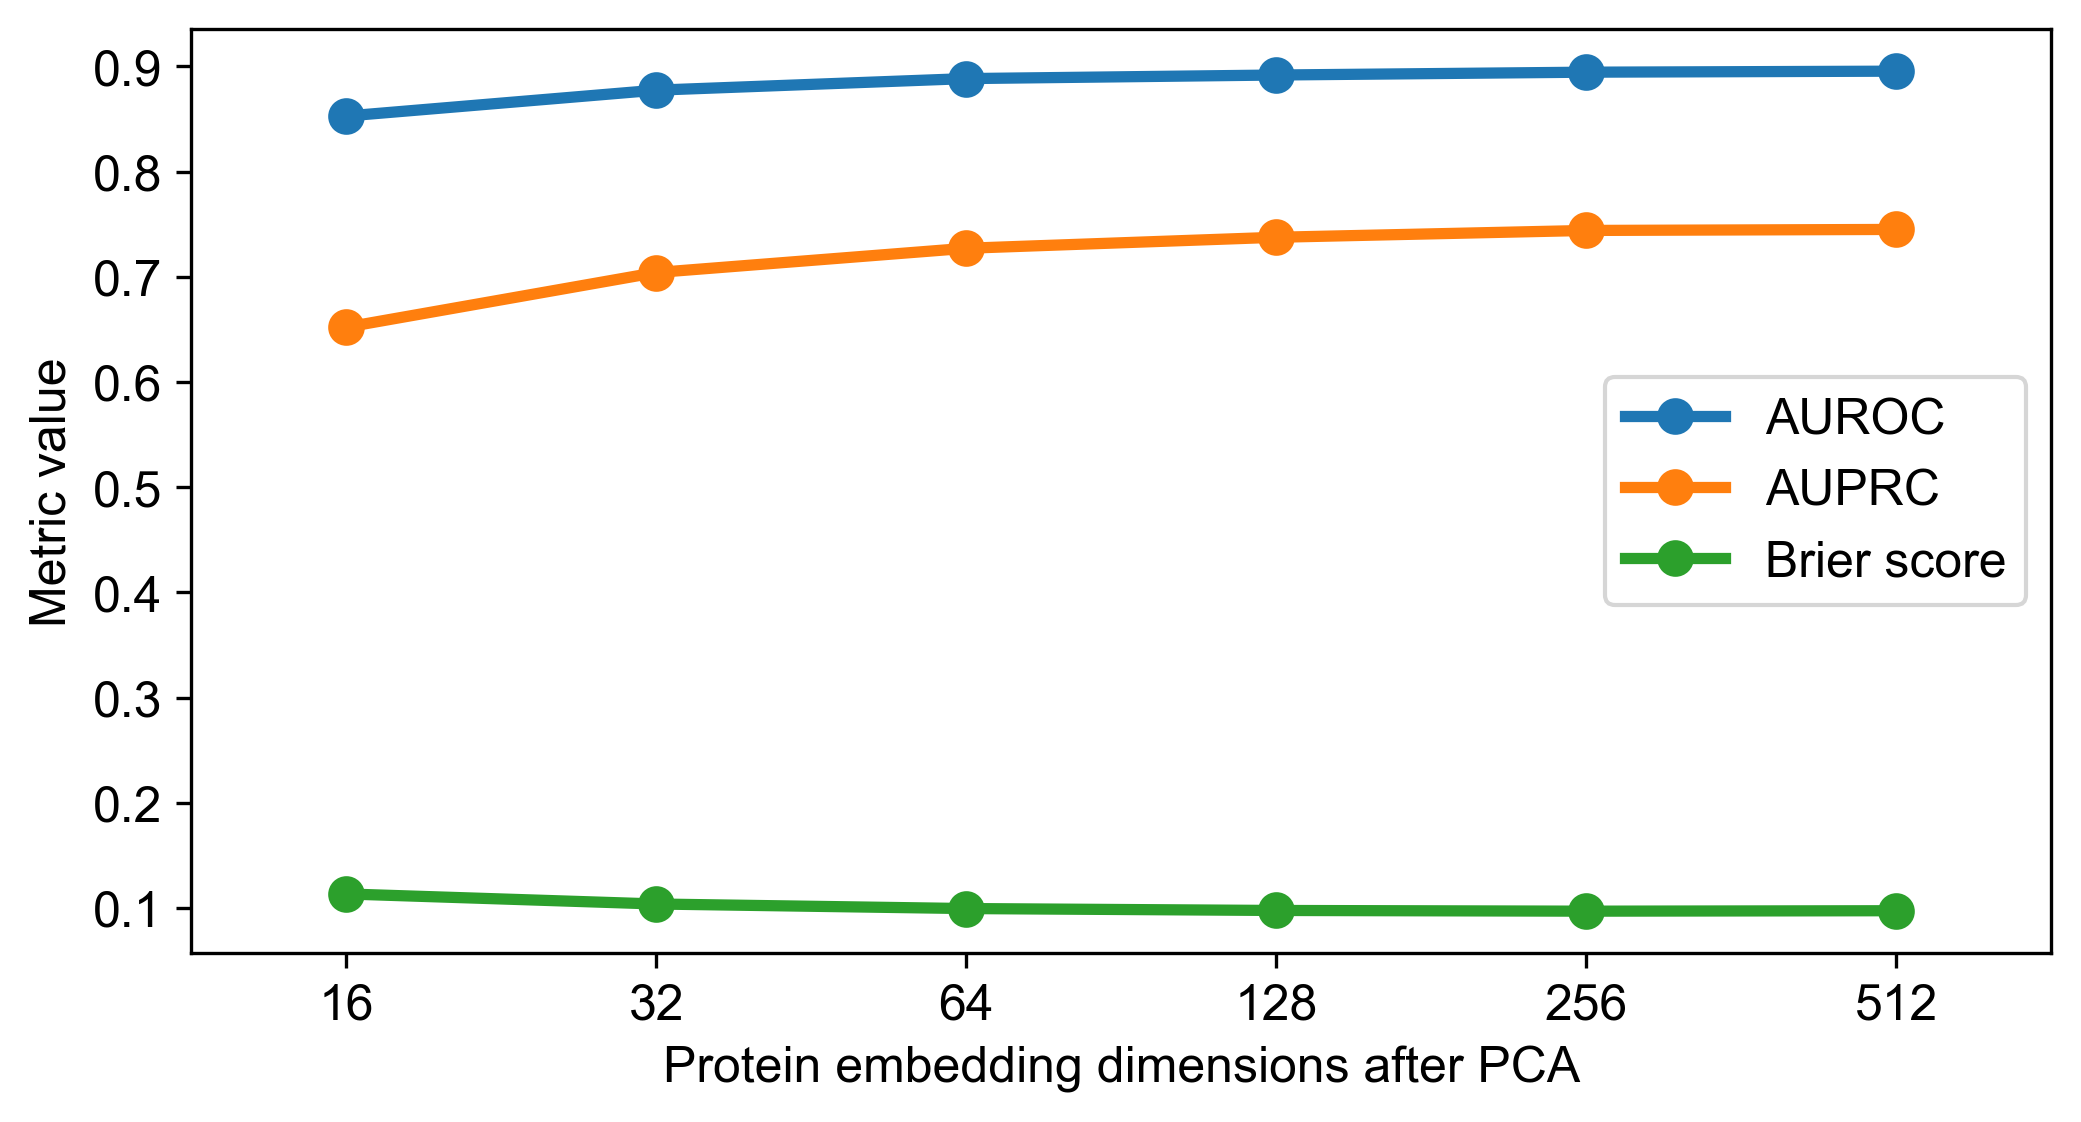

In [34]:
metrics = pd.read_pickle('./Training/Metrics/protein_embeddings.pkl')
metrics = metrics.loc[metrics['model'].str.contains('pe')]
metrics['dim'] = metrics['model'].str.split('_').str[1].astype(int)
metrics['metric'] = metrics['metric'].map({'auroc':'AUROC','auprc':'AUPRC','brier':'Brier score'})

plt.figure(figsize=(8,4), dpi=300)
sns.pointplot(metrics,x='dim',y='mean',hue='metric')
plt.xlabel('Protein embedding dimensions after PCA')
plt.ylabel('Metric value')
plt.legend(title='')

### GenePT embeddings

In [72]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)
gene_embed = pd.read_pickle('./GenePT/genept_em3l.pkl').rename({'gene':'ID'},axis=1).round(5).iloc[:, :1025]
data = data.drop(['source','tdl'],axis=1).merge(gene_embed, how='left')
data.columns = data.columns.astype(str)


In [ ]:
num_folds_outer = 8
num_folds_inner = 8

model_names = [16,32,64,128,256,512,1024] 
    
for i in model_names:
    print(i)    

    X = data.iloc[:,55:(55+i)]
    y = data[["neg","other","pos","druggable"]].values
    y_binary = (y > 0).astype(int)
    
    ids = data["ID"].values
    
    outer_kf = KFold(n_splits=num_folds_outer, shuffle=True, random_state=42)
    fold_counter_outer = 0
    
    all_preds = []
    all_ids = []
    
    shap_neg = pd.DataFrame()
    shap_oth = pd.DataFrame()
    shap_pos = pd.DataFrame()
    
    for outer_train_idx, holdout_idx in outer_kf.split(X):
        fold_counter_outer += 1
        print(fold_counter_outer)
        X_outer_train, X_holdout = X.iloc[outer_train_idx], X.iloc[holdout_idx]
        y_outer_train, y_holdout = y[outer_train_idx], y[holdout_idx]
        y_holdout_binary = y_binary[holdout_idx]
        ids_holdout = ids[holdout_idx]
    
        inner_kf = KFold(n_splits=num_folds_inner, shuffle=True, random_state=42)
        fold_counter_inner = 0
        print(fold_counter_inner)
        holdout_preds_all = []
        for inner_train_idx, val_idx in inner_kf.split(X_outer_train):
            fold_counter_inner += 1
            X_inner_train, X_val = X_outer_train.iloc[inner_train_idx], X_outer_train.iloc[val_idx]
            y_inner_train, y_val = y_outer_train[inner_train_idx], y_outer_train[val_idx]
    
            dtrain = xgb.DMatrix(X_inner_train, label=y_inner_train, enable_categorical=True)
            dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
            dholdout = xgb.DMatrix(X_holdout, enable_categorical=True)
    
            params = {
                "objective":"reg:logistic",
                "max_depth":7,
                "alpha":5,
                "lambda":1,
                "eta":0.1,
                "min_child_weight":10,
                "nthread":12,
            }
    
            model = xgb.train(
                params, dtrain, num_boost_round=2000,
                early_stopping_rounds=15,
                evals=[(dval,"eval")],
                verbose_eval=False
            )
    
            # Save model
            # model.save_model(f"./Training/Models/dg_{i}_outer{fold_counter_outer}_inner{fold_counter_inner}.json")

            preds_holdout = model.predict(dholdout)
            preds_holdout = preds_holdout.reshape(len(X_holdout), -1)
            holdout_preds_all.append(preds_holdout)
    
        holdout_preds_all = np.mean(np.stack(holdout_preds_all, axis=0), axis=0)
        
        binary_preds = (holdout_preds_all > 0.5).astype(int)
        for c in range(y_holdout_binary.shape[1]):
            auroc = roc_auc_score(y_holdout_binary[:,c], holdout_preds_all[:,c])
            auprc = average_precision_score(y_holdout_binary[:,c], holdout_preds_all[:,c])
            prop_positives = y_holdout_binary[:,c].mean()
            print(f"Outer Fold {fold_counter_outer}, Class {c}: AUROC={auroc}, AUPRC={auprc}, Proportion positives={prop_positives}")
        hl = hamming_loss(y_holdout_binary, binary_preds)
        print(f"Outer Fold {fold_counter_outer}: Hamming Loss={hl}")
    
        # Store holdout predictions
        fold_df = pd.DataFrame({
            "ID": ids_holdout,
            "pred_neg": holdout_preds_all[:,0],
            "pred_other": holdout_preds_all[:,1],
            "pred_pos": holdout_preds_all[:,2],
            "pred_druggable": holdout_preds_all[:,3]
        })
        all_preds.append(fold_df)
        all_ids.extend(ids_holdout)
    
    # Concatenate all holdout predictions
    final_preds = pd.concat(all_preds, axis=0)
    final_preds = final_preds.groupby("ID").mean().reset_index()
    final_preds.to_csv(f"./Training/Predictions/dg_genept_{i}_holdout_predictions.csv", index=False)


In [89]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','druggable']]

model_names = ['genept_16','genept_32','genept_64','genept_128','genept_256','genept_512','genept_1024']
metrics = []

def bootstrap_metrics(y_true, y_score, n_boot=500):
    np.random.seed(42)
    results = {'auroc': [], 'auprc': [], 'brier': []}
    
    for _ in range(n_boot):
        idx = np.random.randint(0, len(y_true), len(y_true))
        yt, ys = y_true[idx], y_score[idx]
        results['auroc'].append(roc_auc_score(yt, ys))
        results['auprc'].append(average_precision_score(yt, ys))
        results['brier'].append(np.mean((ys - yt) ** 2))
    
    return {k: (np.mean(v), np.percentile(v, 2.5), np.percentile(v, 97.5)) for k, v in results.items()}

for i in model_names:
    res=pd.read_csv(f'./Training/Predictions/dg_{i}_holdout_predictions.csv').merge(data)
    y_true, y_score = res[['druggable']].values.ravel(), res[['pred_druggable']].values.ravel()
    boot_metrics = bootstrap_metrics(y_true, y_score)
    metrics.extend([{'model': i, 'metric': k, 'mean': m, 'ci_low': l, 'ci_high': h} for k, (m, l, h) in boot_metrics.items()])
    
pd.DataFrame(metrics).to_pickle('./Training/Metrics/genept_embeddings.pkl')


In [91]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos']]

model_names = ['genept_16','genept_32','genept_64','genept_128','genept_256','genept_512','genept_1024']
metrics = pd.DataFrame()

def bootstrap_all_metrics(y_true,y_score,n_boot):
    np.random.seed(42)
    out={f'auroc_{c}':[] for c in ['neg','other','pos']}
    out.update({f'auprc_{c}':[] for c in ['neg','other','pos']})
    for x in ['auroc_micro','auroc_macro','auprc_micro','auprc_macro','hamming']:
        out[x]=[]
    for _ in range(n_boot):
        idx=np.random.randint(0,len(y_true),len(y_true))
        yt,ys=y_true[idx],y_score[idx]
        for i,c in enumerate(['neg','other','pos']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:,i],ys[:,i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:,i],ys[:,i]))
        out['auroc_micro'].append(roc_auc_score(yt,ys,average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt,ys,average='macro'))
        out['auprc_micro'].append(average_precision_score(yt,ys,average='micro'))
        out['auprc_macro'].append(average_precision_score(yt,ys,average='macro'))
        out['hamming'].append(hamming_loss(yt,(ys>=0.5).astype(int)))
    return {k:(np.mean(v),np.percentile(v,2.5),np.percentile(v,97.5)) for k,v in out.items()}

for i in model_names:
    res=pd.read_csv(f'./Training/Predictions/dg_{i}_holdout_predictions.csv').merge(data)
    y_true=res[['neg','other','pos']].values
    y_score=res[['pred_neg','pred_other','pred_pos']].values
    boot=bootstrap_all_metrics(y_true,y_score,10)
    new_records=[]
    for k,(m,l,h) in boot.items():
        new_records.append({'model':i,'metric':k,'mean':m,'ci_low':l,'ci_high':h})
    metrics=pd.concat([metrics,pd.DataFrame(new_records)],ignore_index=True)

metrics.to_pickle('./Training/Metrics/genept_embeddings_doe.pkl')


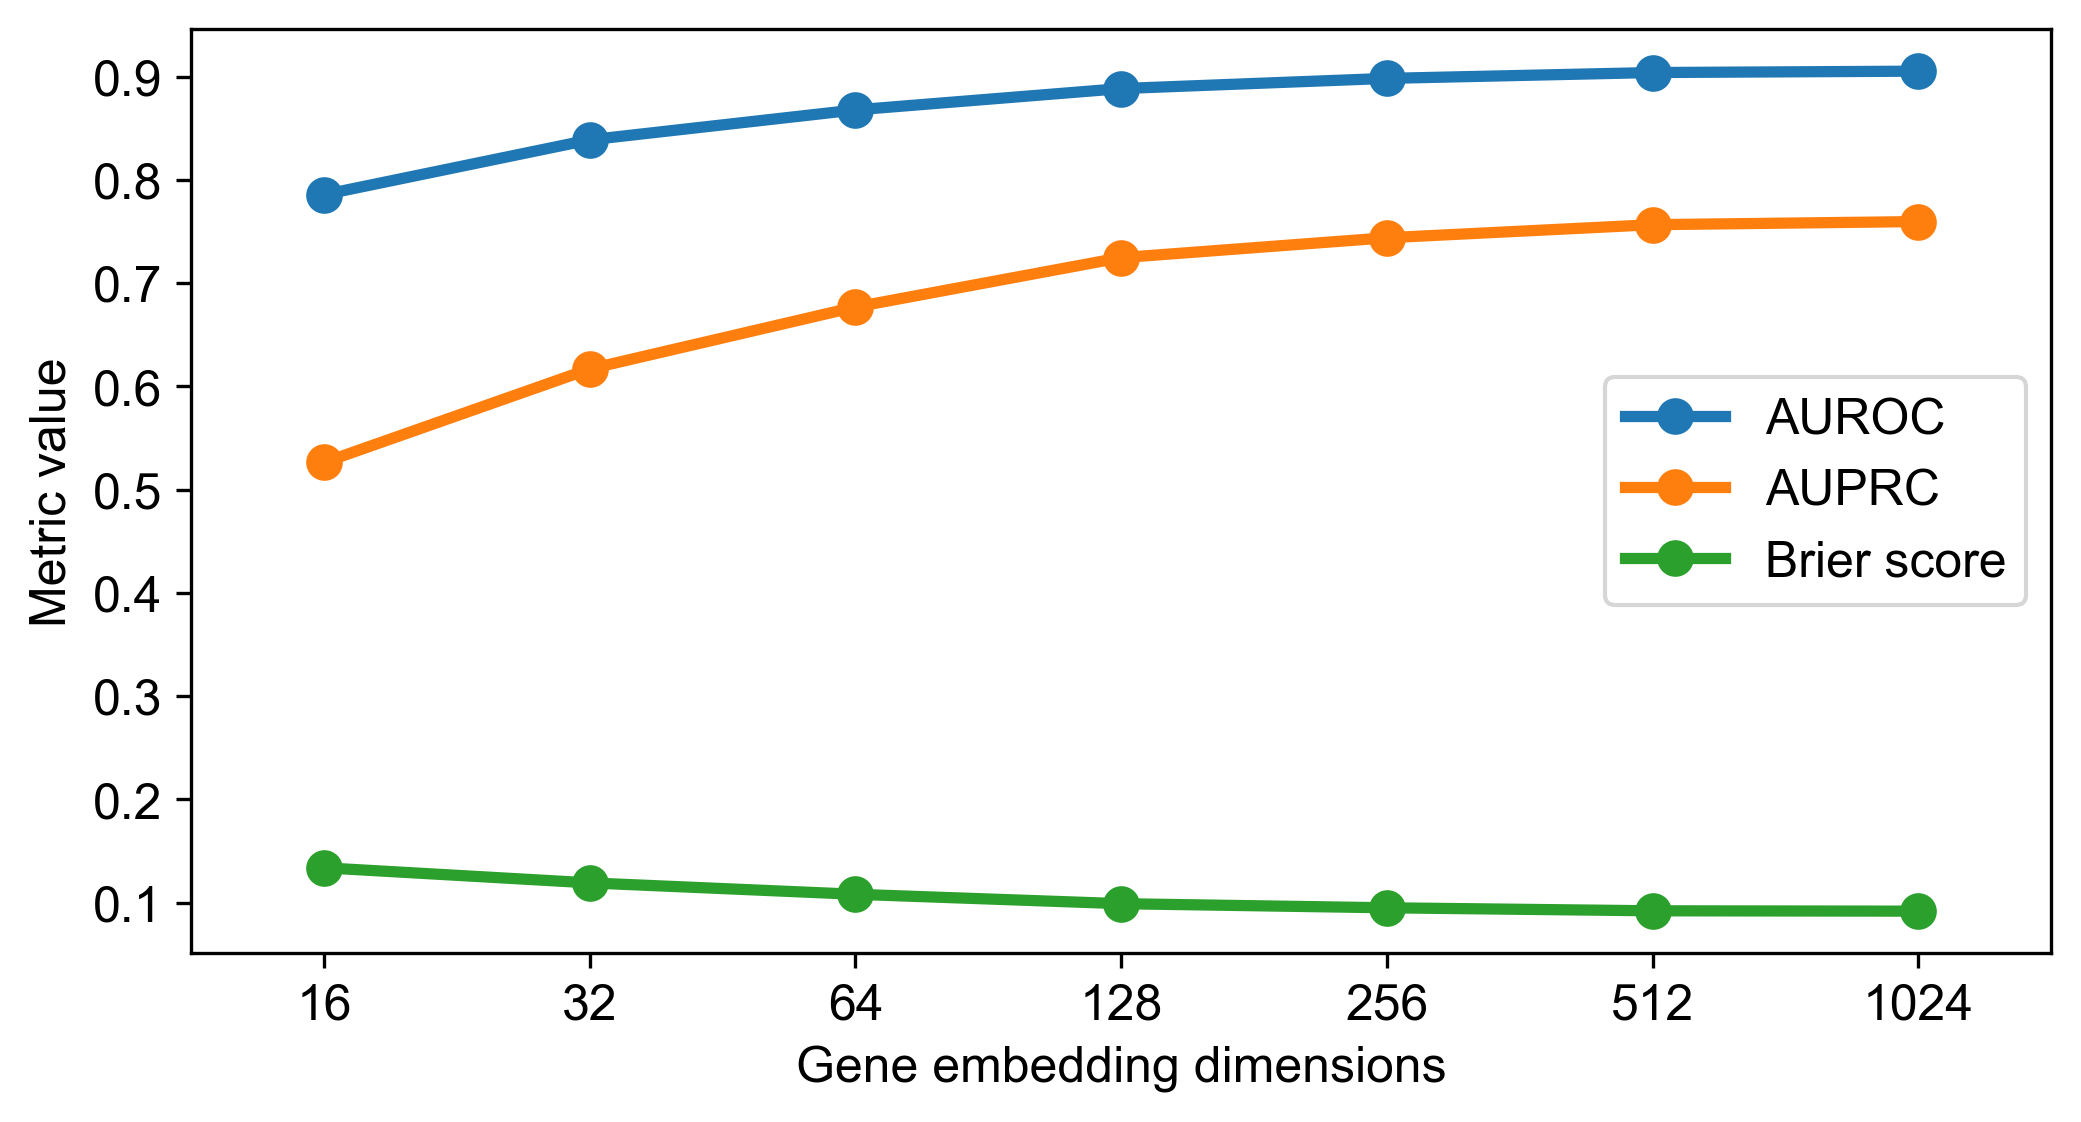

In [35]:
metrics = pd.read_pickle('./Training/Metrics/genept_embeddings.pkl')
metrics['dim'] = metrics['model'].str.split('_').str[1].astype(int)
metrics['metric'] = metrics['metric'].map({'auroc':'AUROC','auprc':'AUPRC','brier':'Brier score'})

plt.figure(figsize=(8,4), dpi=300)
sns.pointplot(metrics,x='dim',y='mean',hue='metric')
plt.xlabel('Gene embedding dimensions')
plt.ylabel('Metric value')
plt.legend(title='')

## Druggability only

In [ ]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)
gene_embed = pd.read_pickle('./GenePT/genept_em3l.pkl').rename({'gene':'ID'},axis=1).round(5).iloc[:, :257]
prot_embed = pd.read_pickle('./UniProt/pca_embeddings_128.pkl').rename({'gene':'ID'},axis=1)
data = data.drop(['source','tdl'],axis=1).merge(gene_embed, how='left').merge(prot_embed, how='left')
data.columns = data.columns.astype(str)

genetics = ['mab_count', 'tissueSpecificity', 'tissueDistribution', 
           'hasPocket', 'mouseKOScore', 'paralogMaxIdentityPercentage',
           'oncokb_oncogene', 'oncokb_suppressor', 'oncokb_sources',
           'loc_intracellular', 'loc_membrane', 'loc_secreted', 'loc_plasma',
           'class_enzyme', 'class_transporter', 'class_tf', 'class_gpcr',
           'class_vgic', 'lof.oe', 'lof.pLI', 'lof.pRec', 'lof.pNull',
           'lof.oe_ci.upper', 'mis.oe', 'mis_pphen.oe', 'syn.oe', 
           'gofcards', 'omim_ad', 'omim_ar', 'depmap_ss','clingen_hi', 
           'depmap_ce', 'badonyi_pgof', 'badonyi_pdn', 'badonyi_plof',
           'collins_phaplo', 'collins_ptriplo', 
           'protein_length', 'gtex_tau', 'af_pockets_0', 'af_pockets_0.1']
gene_embed = list(gene_embed.drop('ID',axis=1).columns.astype(str))
prot_embed = list(prot_embed.drop('ID',axis=1).columns.astype(str))


### Tuning

In [ ]:
num_folds_outer = 5
num_folds_inner = 5

if True:
    model_names = ['all']
    feature_names = [genetics + gene_embed + prot_embed]

param_grid = {
    "max_depth": [5, 6, 7],
    "alpha": [0, 1, 5, 10],
    "lambda": [1, 5, 10],
    "eta": [0.1, 0.3],
    "gamma": [0, 1, 5, 10]
}

results = []

for i, j in zip(model_names, feature_names):
    print(i)

    X = data[j].values
    y = data[["tclin_tchem", "druggable"]].values
    y_binary = (y > 0).astype(int)
    ids = data["ID"].values

    outer_kf = KFold(n_splits=num_folds_outer, shuffle=True, random_state=42)

    for fold_counter_outer, (outer_train_idx, holdout_idx) in enumerate(outer_kf.split(X), start=1):
        X_outer_train, X_holdout = X[outer_train_idx], X[holdout_idx]
        y_outer_train, y_holdout = y[outer_train_idx], y[holdout_idx]
        y_holdout_binary = y_binary[holdout_idx]

        for md in param_grid["max_depth"]:
            for a in param_grid["alpha"]:
                for l in param_grid["lambda"]:
                    for e in param_grid["eta"]:
                        for g in param_grid["gamma"]:
                            inner_kf = KFold(n_splits=num_folds_inner, shuffle=True, random_state=42)
                            holdout_preds_sum = np.zeros((len(X_holdout), y_holdout.shape[1]))

                            for inner_train_idx, val_idx in inner_kf.split(X_outer_train):
                                X_inner_train, X_val = X_outer_train[inner_train_idx], X_outer_train[val_idx]
                                y_inner_train, y_val = y_outer_train[inner_train_idx], y_outer_train[val_idx]

                                dtrain = xgb.DMatrix(X_inner_train, label=y_inner_train, enable_categorical=True)
                                dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
                                dholdout = xgb.DMatrix(X_holdout, enable_categorical=True)

                                params = {
                                    "objective": "reg:logistic",
                                    "max_depth": md,
                                    "alpha": a,
                                    "lambda": l,
                                    "eta": e,
                                    "gamma": g,
                                    "min_child_weight": 10,
                                    "nthread": 12
                                }
                                model = xgb.train(params, dtrain, num_boost_round=2000,
                                                  early_stopping_rounds=15, evals=[(dval, "eval")], verbose_eval=False)

                                holdout_preds_sum += model.predict(dholdout).reshape(len(X_holdout), -1)

                            holdout_preds_avg = holdout_preds_sum / num_folds_inner
                            binary_preds = (holdout_preds_avg > 0.5).astype(int)
                            hl = hamming_loss(y_holdout_binary, binary_preds)

                            for c in range(y_holdout_binary.shape[1]):
                                auroc = roc_auc_score(y_holdout_binary[:, c], holdout_preds_avg[:, c])
                                auprc = average_precision_score(y_holdout_binary[:, c], holdout_preds_avg[:, c])
                                prop_pos = y_holdout_binary[:, c].mean()

                                results.append({
                                    "outer_fold": fold_counter_outer,
                                    "class": c,
                                    "max_depth": md,
                                    "alpha": a,
                                    "lambda": l,
                                    "eta": e,
                                    "gamma": g,
                                    "AUROC": auroc,
                                    "AUPRC": auprc,
                                    "proportion_positives": prop_pos,
                                    "hamming_loss": hl
                                })

                            print(f"Outer Fold {fold_counter_outer}, Params md={md}, alpha={a}, lambda={l}, eta={e}, gamma={g}, Hamming Loss={hl}")

results_df = pd.DataFrame(results)
results_df.to_pickle('./Training/Metrics/druggability_tuning.pkl')


In [ ]:
results = pd.read_pickle('./Training/Metrics/druggability_tuning.pkl').sort_values('AUROC')
results = results.groupby(['max_depth','alpha','lambda','eta','gamma'])[['AUROC','AUPRC']].mean()
results.sort_values('AUROC',ascending=False)[:20]

AUROC     AUPRC
max_depth alpha lambda eta gamma                    
6         0     5      0.1 0      0.942484  0.811103
          1     1      0.1 0      0.942392  0.810049
7         5     1      0.1 0      0.942343  0.810589
          0     1      0.1 1      0.942341  0.810803
6         0     10     0.1 0      0.942332  0.810343
7         1     1      0.1 1      0.942310  0.810247
6         1     5      0.1 1      0.942273  0.810222
5         1     1      0.1 0      0.942236  0.810094
6         0     1      0.1 1      0.942221  0.810211
7         0     5      0.1 0      0.942203  0.810408
5         1     1      0.1 1      0.942174  0.809071
6         1     1      0.1 1      0.942172  0.809929
7         5     10     0.1 0      0.942166  0.810004
5         0     1      0.1 1      0.942146  0.810539
6         0     5      0.1 1      0.942145  0.809707
                10     0.1 1      0.942140  0.810159
7         0     10     0.1 1      0.942136  0.809811
          5     5      0.1 0      0.942115  0.809912
          1     1      0.1 0      0.942108  0.810023
          0     1      0.1 0      0.942106  0.810404

### Full model

In [ ]:
num_folds_outer = 8
num_folds_inner = 8
shap_enabled = True

if True:
    model_names = ['all','gene_embed','prot_embed','all_embed','genetics']
    feature_names = [genetics+gene_embed+prot_embed,gene_embed,prot_embed,gene_embed+prot_embed,genetics]

for i,j in zip(model_names, feature_names):
    print(i)    
    
    X = data[j]
    y = data[["tclin_tchem","druggable"]].values
    y_binary = (y > 0).astype(int)
    
    ids = data["ID"].values
    
    outer_kf = KFold(n_splits=num_folds_outer, shuffle=True, random_state=42)
    fold_counter_outer = 0
    
    all_preds = []
    all_ids = []

    shap_tc = pd.DataFrame()
    shap_drug = pd.DataFrame()
    
    for outer_train_idx, holdout_idx in outer_kf.split(X):
        fold_counter_outer += 1
        print(fold_counter_outer)
        X_outer_train, X_holdout = X.iloc[outer_train_idx], X.iloc[holdout_idx]
        y_outer_train, y_holdout = y[outer_train_idx], y[holdout_idx]
        y_holdout_binary = y_binary[holdout_idx]
        ids_holdout = ids[holdout_idx]
    
        inner_kf = KFold(n_splits=num_folds_inner, shuffle=True, random_state=42)
        fold_counter_inner = 0
        print(fold_counter_inner)
        holdout_preds_all = []
        for inner_train_idx, val_idx in inner_kf.split(X_outer_train):
            fold_counter_inner += 1
            X_inner_train, X_val = X_outer_train.iloc[inner_train_idx], X_outer_train.iloc[val_idx]
            y_inner_train, y_val = y_outer_train[inner_train_idx], y_outer_train[val_idx]
    
            dtrain = xgb.DMatrix(X_inner_train, label=y_inner_train, enable_categorical=True)
            dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
            dholdout = xgb.DMatrix(X_holdout, enable_categorical=True)
    
            params = {
                "objective":"reg:logistic",
                "max_depth":7,
                "alpha":5,
                "lambda":1,
                "eta":0.1,
                "min_child_weight":10,
                "nthread":12,
            }
    
            model = xgb.train(
                params, dtrain, num_boost_round=2000,
                early_stopping_rounds=15,
                evals=[(dval,"eval")],
                verbose_eval=False
            )
    
            # Save model
            # model.save_model(f"./Training/Models/druggability_{i}_outer{fold_counter_outer}_inner{fold_counter_inner}.json")

            if (i in ['all']) & (shap_enabled == True):
                if fold_counter_inner == 1:
                    explainer = shap.TreeExplainer(model)
                    explanation = explainer(dholdout)
                    ex_tc = pd.DataFrame(explanation[:,:,0].values, columns=X.columns)
                    ex_tc['ID'] = ids_holdout
                    shap_tc = pd.concat([shap_tc,ex_tc])
                    ex_drug = pd.DataFrame(explanation[:,:,1].values, columns=X.columns)
                    ex_drug['ID'] = ids_holdout
                    shap_drug = pd.concat([shap_drug,ex_drug])
                    
            preds_holdout = model.predict(dholdout)
            preds_holdout = preds_holdout.reshape(len(X_holdout), -1)
            holdout_preds_all.append(preds_holdout)
    
        holdout_preds_all = np.mean(np.stack(holdout_preds_all, axis=0), axis=0)
        
        binary_preds = (holdout_preds_all > 0.5).astype(int)
        for c in range(y_holdout_binary.shape[1]):
            auroc = roc_auc_score(y_holdout_binary[:,c], holdout_preds_all[:,c])
            auprc = average_precision_score(y_holdout_binary[:,c], holdout_preds_all[:,c])
            prop_positives = y_holdout_binary[:,c].mean()
            print(f"Outer Fold {fold_counter_outer}, Class {c}: AUROC={auroc}, AUPRC={auprc}, Proportion positives={prop_positives}")
        hl = hamming_loss(y_holdout_binary, binary_preds)
        print(f"Outer Fold {fold_counter_outer}: Hamming Loss={hl}")
    
        # Store holdout predictions
        fold_df = pd.DataFrame({
            "ID": ids_holdout,
            "pred_tc": holdout_preds_all[:,0],
            "pred_druggable": holdout_preds_all[:,1]
        })
        all_preds.append(fold_df)
        all_ids.extend(ids_holdout)
    
    # Concatenate all holdout predictions
    final_preds = pd.concat(all_preds, axis=0)
    final_preds = final_preds.groupby("ID").mean().reset_index()
    final_preds.to_csv(f"./Training/Predictions/druggability_{i}_holdout_predictions.csv", index=False)

    if (i in ['all']) & (shap_enabled == True):
        shap_tc = shap_tc.groupby('ID').mean().reset_index()
        shap_tc.to_pickle(f'./Training/SHAP/druggability_{i}_shap_tc.pkl')
        shap_drug = shap_drug.groupby('ID').mean().reset_index()
        shap_drug.to_pickle(f'./Training/SHAP/druggability_{i}_shap_drug.pkl')
        

### SHAP

In [61]:
i = 'all'
shap_all = pd.read_pickle(f'./Training/SHAP/druggability_all_shap_drug.pkl')

fv = data[shap_all.columns]
fv = shap_all[['ID']].merge(fv)
for col in ['loc_intracellular','loc_membrane','loc_secreted','loc_plasma','class_enzyme',
            'class_transporter','class_tf','class_gpcr','class_vgic','oncokb_oncogene',
            'oncokb_suppressor','oncokb_sources','omim_ad','omim_ar','gofcards','clingen_hi']:
    fv[col] = fv[col].fillna(0)

shap_all = shap_all.drop('ID', axis=1)
fv = fv.drop('ID', axis=1)

# Function to compute Spearman correlations
def compute_correlations(shap_data, fv_data):
    correlations = {}
    for col in shap_data.columns:
        if pd.api.types.is_numeric_dtype(fv_data[col]):
            mask = ~(shap_data[col].isna() | fv_data[col].isna())
            if mask.any():
                correlations[col] = spearmanr(fv_data.loc[mask, col], shap_data.loc[mask, col])[0]
    return correlations

# Function to compute SHAP absolute mean for all values and only for nonzero/non-NaN values in fv
def compute_shap_stats(shap_data, fv_data, label):
    correlations = compute_correlations(shap_data, fv_data)
    shap_values = []
    
    for col in shap_data.columns:
        all_mean = shap_data[col].abs().mean()  # Mean over all values
        
        mask = ~(fv_data[col].isna() | (fv_data[col] == 0))  # Ignore NaN and zero values in fv
        filtered_mean = shap_data.loc[mask, col].abs().mean() if mask.any() else None  # Mean over filtered values

        shap_values.append((col, all_mean, filtered_mean))

    shap_stats = pd.DataFrame(shap_values, columns=['feature', label, f'{label}_nonzero_nonNaN'])
    shap_corr = pd.DataFrame(list(correlations.items()), columns=['feature', f'{label}_corr'])
    
    return shap_stats.merge(shap_corr, how='left')

# Compute SHAP statistics for neg, pos, and other
sa = compute_shap_stats(shap_all, fv, 'druggable')

# Assign categories
sa.loc[sa['feature'].isin(genetics), 'category'] = 'Tabular features'
sa.loc[sa['feature'].isin(gene_embed), 'category'] = 'Gene embeddings'
sa.loc[sa['feature'].isin(prot_embed), 'category'] = 'Protein embeddings'

sa = sa[['feature','category','druggable','druggable_nonzero_nonNaN','druggable_corr']].sort_values('druggable',ascending=False)
sa.to_excel('./Supplemental tables/druggability_fi.xlsx', index=False)


### DrugnomeAI comparison

In [59]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','tclin_tchem','druggable']]

model_names = ['Tclin', 'Tier 1', 'Tclin & Tier 1', 'Tclin & Tchem', 'Tchem', 'Tier 1 & 2', 'Tier 1 & 2 & 3A']
metrics = pd.DataFrame()

def bootstrap_all_metrics(y_true,y_score,n_boot):
    np.random.seed(42)
    out={f'auroc_{c}':[] for c in ['tclin_tchem','druggable']}
    out.update({f'auprc_{c}':[] for c in ['tclin_tchem','druggable']})
    out.update({f'brier_{c}':[] for c in ['tclin_tchem','druggable']})
    for x in ['auroc_micro','auroc_macro','auprc_micro','auprc_macro','hamming','brier_micro','brier_macro']:
        out[x]=[]
    for _ in range(n_boot):
        idx=np.random.randint(0,len(y_true),len(y_true))
        yt,ys=y_true[idx],y_score[idx]
        for i,c in enumerate(['tclin_tchem','druggable']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:,i],ys[:,i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:,i],ys[:,i]))
            out[f'brier_{c}'].append(np.mean((ys[:,i] - yt[:,i])**2))
        out['auroc_micro'].append(roc_auc_score(yt,ys,average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt,ys,average='macro'))
        out['auprc_micro'].append(average_precision_score(yt,ys,average='micro'))
        out['auprc_macro'].append(average_precision_score(yt,ys,average='macro'))
        out['hamming'].append(hamming_loss(yt,(ys>=0.5).astype(int)))
        out['brier_micro'].append(np.mean((ys - yt)**2))
        out['brier_macro'].append(np.mean([(ys[:,i] - yt[:,i])**2 for i in range(yt.shape[1])]))

    return {k:(np.mean(v),np.percentile(v,2.5),np.percentile(v,97.5)) for k,v in out.items()}

for i in model_names:
    res=pd.read_csv('./Other/drugnomeai.csv').rename({'Gene Name':'ID'},axis=1).merge(data)
    res['pred_tc']=res[i].copy()
    res['pred_druggable']=res[i].copy()
    y_true=res[['tclin_tchem','druggable']].values
    y_score=res[['pred_tc','pred_druggable']].values
    boot=bootstrap_all_metrics(y_true,y_score,500)
    new_records=[]
    for k,(m,l,h) in boot.items():
        new_records.append({'model':i,'metric':k,'mean':m,'ci_low':l,'ci_high':h})
    metrics=pd.concat([metrics,pd.DataFrame(new_records)],ignore_index=True)

metrics.to_pickle('./Training/Metrics/druggability_drugnome.pkl')


In [ ]:
metrics = pd.read_pickle('./Training/Metrics/druggability_drugnome.pkl')

table = metrics.copy()
table.loc[table['metric'].str.contains('tclin_tchem'), 'outcome'] = 'Tclin + Tchem'
table.loc[table['metric'].str.contains('druggable'), 'outcome'] = 'All druggable'
table.loc[table['metric'].str.contains('auroc'), 'metric'] = 'AUROC'
table.loc[table['metric'].str.contains('auprc'), 'metric'] = 'AUPRC'
table.loc[table['metric'].str.contains('brier'), 'metric'] = 'Brier score'
table = table.dropna()
table['value'] = table['mean'].round(3).astype(str) + ' (' + table['ci_low'].round(3).astype(str) + '-' + table['ci_high'].round(3).astype(str) + ')'
table = pd.pivot_table(table, index=['outcome','model'], columns='metric', values='value', aggfunc='first').reset_index()
table = table[['outcome','model','AUROC','AUPRC','Brier score']]
table

metric        outcome            model                AUROC  \
0       All druggable            Tchem   0.89 (0.884-0.896)   
1       All druggable            Tclin   0.884 (0.877-0.89)   
2       All druggable    Tclin & Tchem     0.905 (0.9-0.91)   
3       All druggable   Tclin & Tier 1  0.891 (0.885-0.896)   
4       All druggable           Tier 1   0.884 (0.878-0.89)   
5       All druggable       Tier 1 & 2  0.903 (0.897-0.908)   
6       All druggable  Tier 1 & 2 & 3A  0.875 (0.868-0.881)   
7       Tclin + Tchem            Tchem  0.931 (0.926-0.936)   
8       Tclin + Tchem            Tclin  0.907 (0.899-0.914)   
9       Tclin + Tchem    Tclin & Tchem  0.944 (0.939-0.949)   
10      Tclin + Tchem   Tclin & Tier 1  0.914 (0.907-0.921)   
11      Tclin + Tchem           Tier 1  0.907 (0.901-0.914)   
12      Tclin + Tchem       Tier 1 & 2   0.925 (0.919-0.93)   
13      Tclin + Tchem  Tier 1 & 2 & 3A  0.898 (0.891-0.905)   

metric                AUPRC          Brier score  
0       0.765 (0.753-0.776)  0.096 (0.093-0.099)  
1       0.763 (0.751-0.775)   0.134 (0.13-0.139)  
2       0.806 (0.795-0.816)  0.088 (0.085-0.092)  
3       0.769 (0.757-0.781)  0.101 (0.097-0.104)  
4       0.755 (0.743-0.768)    0.104 (0.1-0.108)  
5       0.789 (0.778-0.799)  0.092 (0.089-0.096)  
6        0.74 (0.728-0.754)   0.106 (0.103-0.11)  
7       0.767 (0.752-0.783)  0.068 (0.066-0.071)  
8       0.736 (0.719-0.752)  0.072 (0.069-0.076)  
9        0.833 (0.82-0.846)   0.057 (0.055-0.06)  
10      0.722 (0.704-0.739)  0.069 (0.066-0.073)  
11      0.696 (0.677-0.713)   0.073 (0.07-0.076)  
12       0.756 (0.74-0.771)   0.073 (0.07-0.075)  
13       0.68 (0.662-0.697)    0.097 (0.094-0.1)

### Calculating metrics and plotting

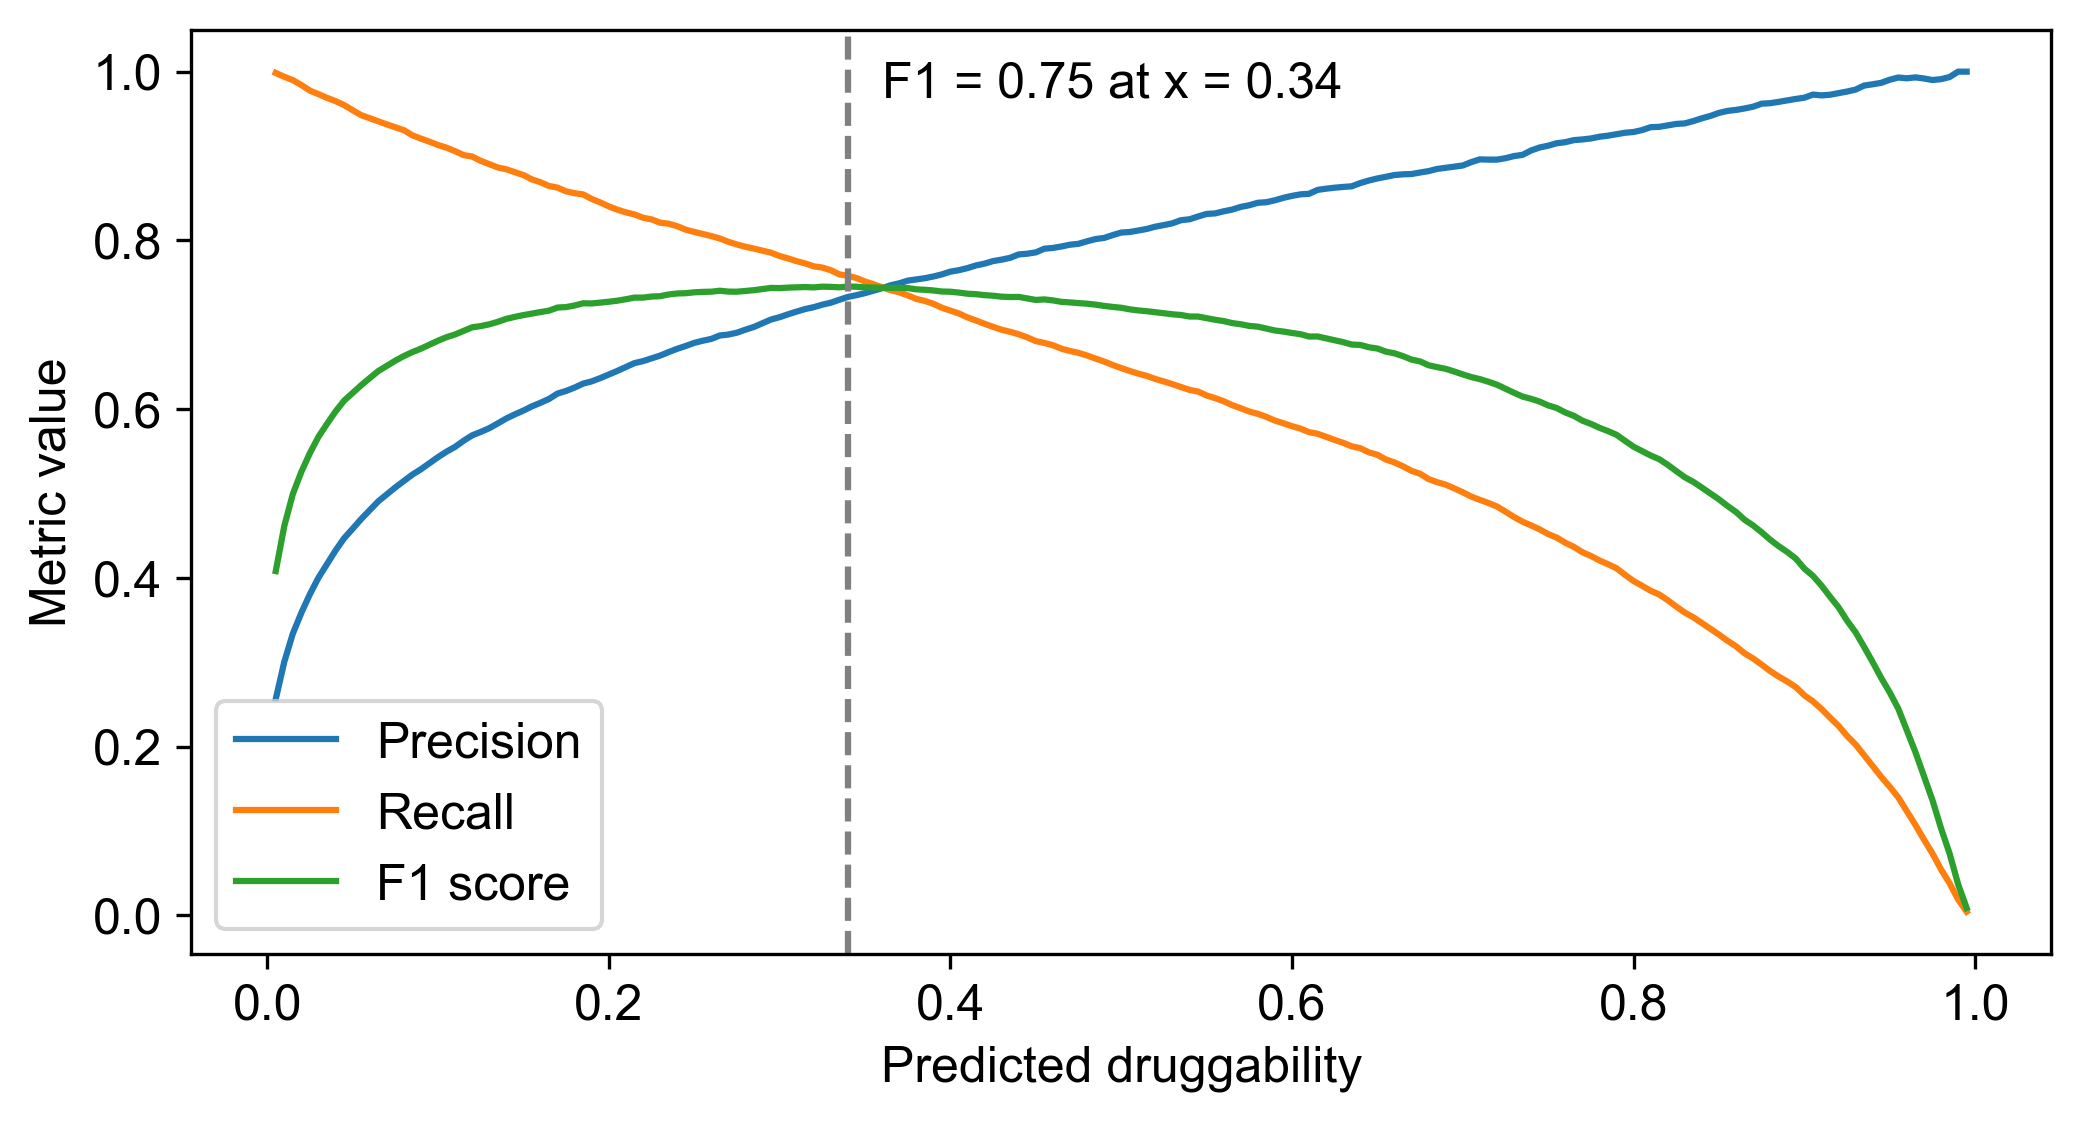

Precision at 0.5: 0.8093
Recall at 0.5: 0.6487


In [8]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','tclin_tchem','druggable']]
pred = pd.read_csv(f'./Training/Predictions/druggability_all_holdout_predictions.csv').merge(data)

plt.figure(figsize=(8,4), dpi=300)
thresholds=np.arange(0,1.0001,0.005)
rows=[]
for t in thresholds:
    b=(pred['pred_druggable']>=t).astype(int)
    if b.sum()>=5 and (len(b)-b.sum())>=5:
        p=precision_score(pred['druggable'],b,zero_division=0)
        r=recall_score(pred['druggable'],b,zero_division=0)
        f=f1_score(pred['druggable'],b,zero_division=0)
        rows.extend([[t,'Precision',p],[t,'Recall',r],[t,'F1 score',f]])
df=pd.DataFrame(rows,columns=['threshold','metric','value'])
best_f1=df[df['metric']=='F1 score']
bt=best_f1.loc[best_f1['value'].idxmax(),'threshold'] if not best_f1.empty else None
sns.lineplot(x='threshold',y='value',hue='metric',data=df)
if bt is not None:
    plt.axvline(x=bt,linestyle='--',color='gray')
    max_f1=best_f1['value'].max()
    plt.annotate(f'F1 = {max_f1:.2f} at x = {bt:.2f}',xy=(bt+0.02,0.97))
plt.legend(title='')
plt.xlabel('Predicted druggability')
plt.ylabel('Metric value')
plt.show()

t = 0.5
b = (pred['pred_druggable'] >= t).astype(int)
precision = precision_score(pred['druggable'], b, zero_division=0)
recall = recall_score(pred['druggable'], b, zero_division=0)
print(f'Precision at 0.5: {precision:.4f}')
print(f'Recall at 0.5: {recall:.4f}')


In [8]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','tclin_tchem','druggable']]

model_names = ['all','gene_embed','prot_embed','all_embed','genetics','drugnomeai']
metrics = pd.DataFrame()

def bootstrap_all_metrics(y_true,y_score,n_boot):
    np.random.seed(42)
    out={f'auroc_{c}':[] for c in ['tclin_tchem','druggable']}
    out.update({f'auprc_{c}':[] for c in ['tclin_tchem','druggable']})
    out.update({f'brier_{c}':[] for c in ['tclin_tchem','druggable']})
    for x in ['auroc_micro','auroc_macro','auprc_micro','auprc_macro','hamming','brier_micro','brier_macro']:
        out[x]=[]
    for _ in range(n_boot):
        idx=np.random.randint(0,len(y_true),len(y_true))
        yt,ys=y_true[idx],y_score[idx]
        for i,c in enumerate(['tclin_tchem','druggable']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:,i],ys[:,i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:,i],ys[:,i]))
            out[f'brier_{c}'].append(np.mean((ys[:,i] - yt[:,i])**2))
        out['auroc_micro'].append(roc_auc_score(yt,ys,average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt,ys,average='macro'))
        out['auprc_micro'].append(average_precision_score(yt,ys,average='micro'))
        out['auprc_macro'].append(average_precision_score(yt,ys,average='macro'))
        out['hamming'].append(hamming_loss(yt,(ys>=0.5).astype(int)))
        out['brier_micro'].append(np.mean((ys - yt)**2))
        out['brier_macro'].append(np.mean([(ys[:,i] - yt[:,i])**2 for i in range(yt.shape[1])]))

    return {k:(np.mean(v),np.percentile(v,2.5),np.percentile(v,97.5)) for k,v in out.items()}

for i in model_names:
    if i == 'drugnomeai':
        res=pd.read_csv('./Other/drugnomeai.csv').rename({'Gene Name':'ID'},axis=1).merge(data)
        res['pred_tc']=res['Tclin & Tchem'].copy()
        res['pred_druggable']=res['Tclin & Tchem'].copy()
    else:
        res=pd.read_csv(f'./Training/Predictions/druggability_{i}_holdout_predictions.csv').merge(data)
    y_true=res[['tclin_tchem','druggable']].values
    y_score=res[['pred_tc','pred_druggable']].values
    boot=bootstrap_all_metrics(y_true,y_score,500)
    new_records=[]
    for k,(m,l,h) in boot.items():
        new_records.append({'model':i,'metric':k,'mean':m,'ci_low':l,'ci_high':h})
    metrics=pd.concat([metrics,pd.DataFrame(new_records)],ignore_index=True)

metrics.to_pickle('./Training/Metrics/druggability.pkl')


In [22]:
metrics = pd.read_pickle('./Training/Metrics/druggability.pkl')
metrics['model'] = metrics['model'].map({'all':'All features',
                                         'gene_embed':'Gene embeddings',
                                         'prot_embed':'Protein embeddings',
                                         'all_embed':'All embeddings',
                                         'genetics':'Tabular features',
                                         'drugnomeai':'DrugnomeAI'})
metrics['model'] = pd.Categorical(metrics['model'], ['Tabular features','Gene embeddings','Protein embeddings',
                                                     'All embeddings','All features','DrugnomeAI'])

data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)
n_ids = data['ID'].nunique()
n_tclintchem = data['tclin_tchem'].sum()
n_druggable = data['druggable'].sum()


In [36]:
table = metrics.copy()
table.loc[table['metric'].str.contains('tclin_tchem'), 'outcome'] = 'Tclin + Tchem'
table.loc[table['metric'].str.contains('druggable'), 'outcome'] = 'All druggable'
table.loc[table['metric'].str.contains('auroc'), 'metric'] = 'AUROC'
table.loc[table['metric'].str.contains('auprc'), 'metric'] = 'AUPRC'
table.loc[table['metric'].str.contains('brier'), 'metric'] = 'Brier score'
table = table.dropna()
table['value'] = table['mean'].round(3).astype(str) + ' (' + table['ci_low'].round(3).astype(str) + '-' + table['ci_high'].round(3).astype(str) + ')'
table = pd.pivot_table(table, index=['outcome','model'], columns='metric', values='value', aggfunc='first').reset_index()
table = table[['outcome','model','AUROC','AUPRC','Brier score']]
table

metric        outcome               model                AUROC  \
0       All druggable    Tabular features  0.899 (0.893-0.903)   
1       All druggable     Gene embeddings  0.897 (0.891-0.902)   
2       All druggable  Protein embeddings  0.892 (0.886-0.897)   
3       All druggable      All embeddings  0.924 (0.919-0.928)   
4       All druggable        All features  0.937 (0.933-0.941)   
5       All druggable          DrugnomeAI     0.905 (0.9-0.91)   
6       Tclin + Tchem    Tabular features  0.912 (0.906-0.917)   
7       Tclin + Tchem     Gene embeddings   0.91 (0.903-0.915)   
8       Tclin + Tchem  Protein embeddings  0.899 (0.893-0.906)   
9       Tclin + Tchem      All embeddings  0.934 (0.929-0.939)   
10      Tclin + Tchem        All features  0.949 (0.945-0.953)   
11      Tclin + Tchem          DrugnomeAI  0.944 (0.939-0.949)   

metric                AUPRC          Brier score  
0        0.737 (0.724-0.75)  0.096 (0.094-0.099)  
1       0.741 (0.727-0.754)  0.096 (0.093-0.099)  
2       0.738 (0.725-0.751)  0.098 (0.095-0.101)  
3       0.799 (0.787-0.809)  0.085 (0.082-0.088)  
4          0.83 (0.82-0.84)  0.077 (0.074-0.079)  
5       0.806 (0.795-0.816)  0.088 (0.085-0.092)  
6       0.677 (0.657-0.695)  0.069 (0.066-0.071)  
7       0.679 (0.661-0.697)  0.069 (0.066-0.071)  
8        0.69 (0.673-0.706)  0.068 (0.065-0.071)  
9        0.76 (0.745-0.775)   0.06 (0.058-0.063)  
10      0.798 (0.784-0.812)  0.054 (0.052-0.056)  
11       0.833 (0.82-0.846)   0.057 (0.055-0.06)

Text(0, 0.5, 'Brier score')

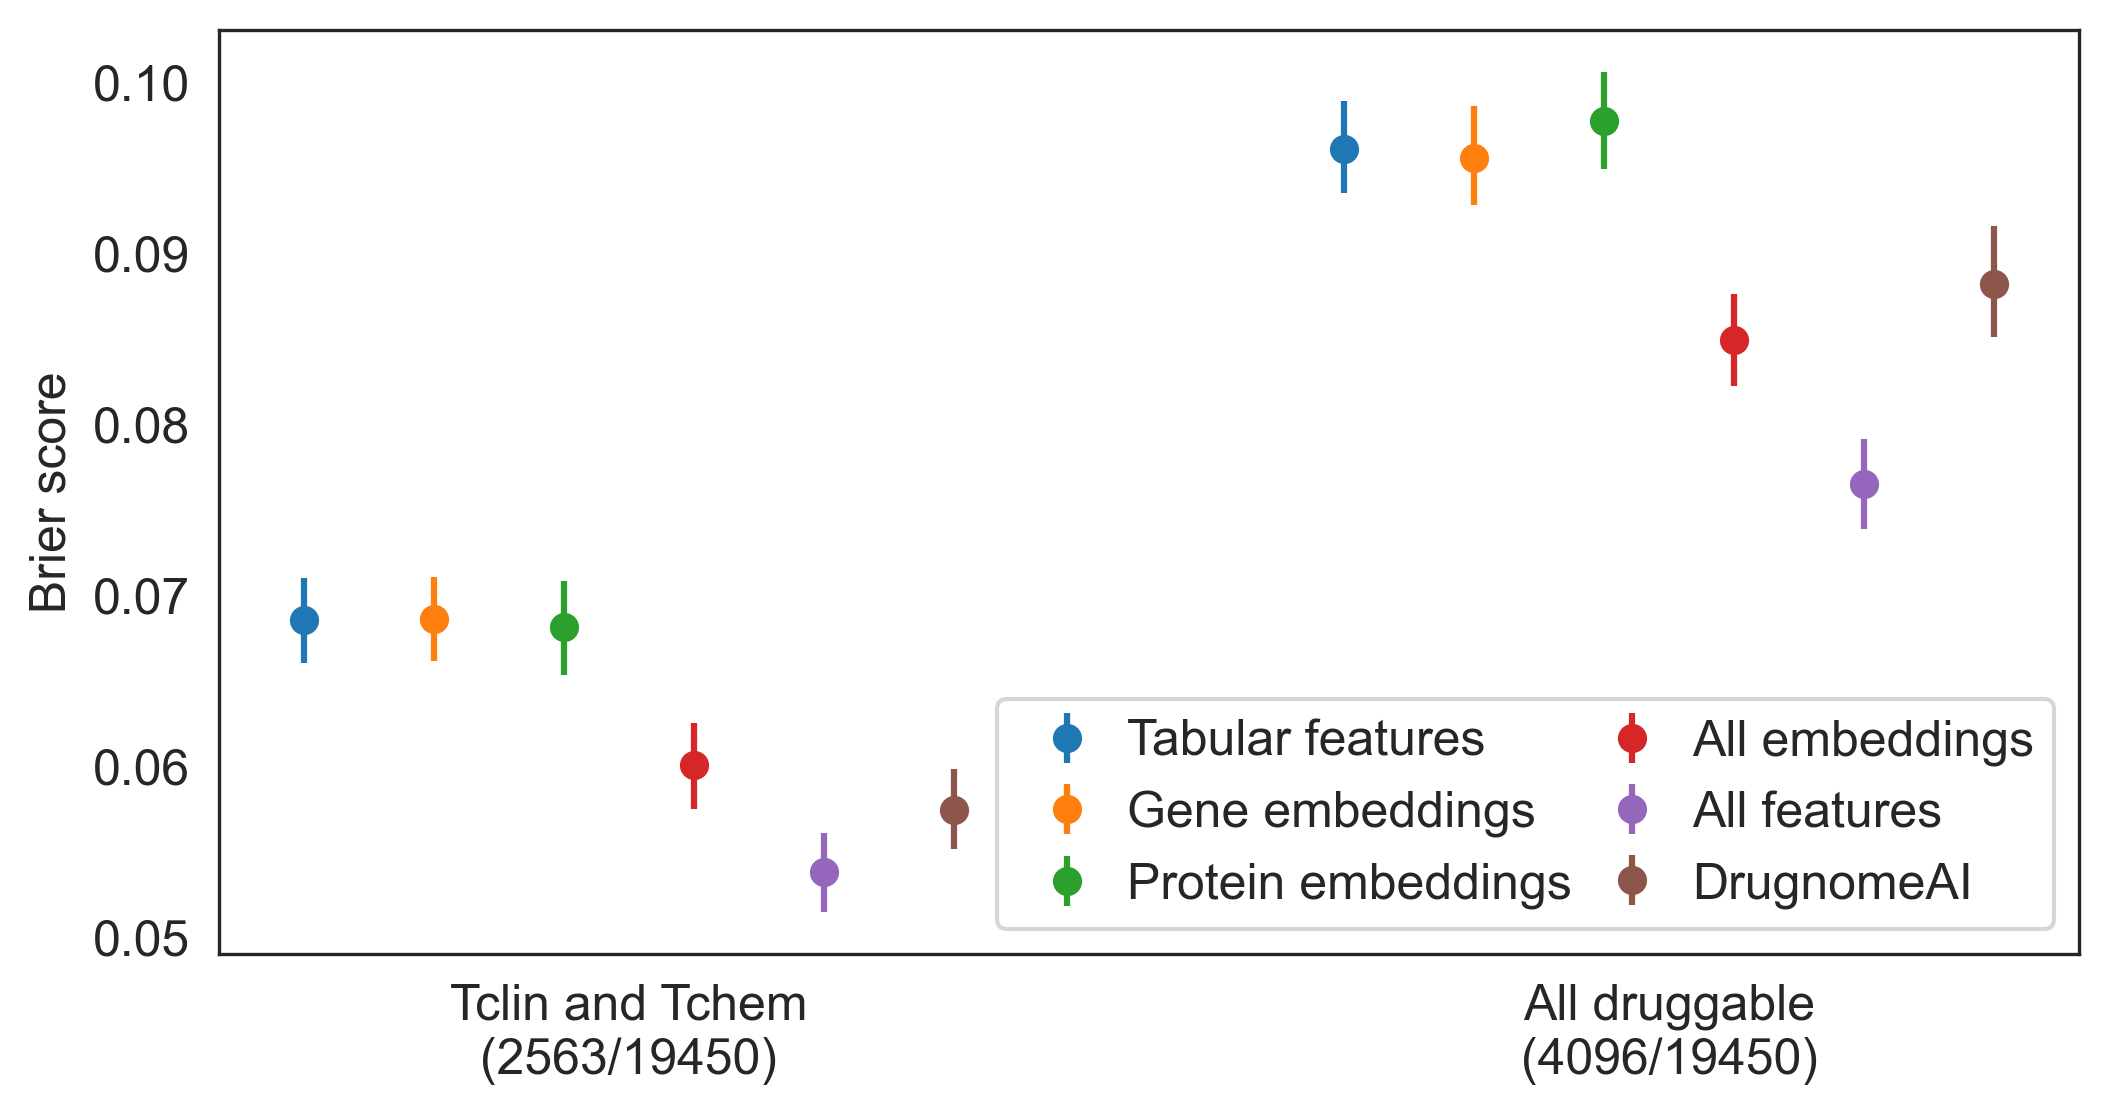

In [68]:
res = metrics.copy()
res = res.loc[~res['metric'].str.contains('micro|macro')]
res = res.loc[res['metric'].str.contains('brier')]
res['metric'] = res['metric'].map({'brier_druggable':f'All druggable\n({n_druggable}/{n_ids})',
                                   'brier_tclin_tchem':f'Tclin and Tchem\n({n_tclintchem}/{n_ids})'})
res['metric'] = pd.Categorical(res['metric'], [f'Tclin and Tchem\n({n_tclintchem}/{n_ids})',f'All druggable\n({n_druggable}/{n_ids})'])
res = res.sort_values(['model','metric'])

sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['model'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['metric'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['model'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['metric'].unique())))
ax.set_xticklabels(res['metric'].unique())
ax.legend(title='', ncols=2, loc='lower right', columnspacing=0.2, handletextpad=0.2)

#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
#plt.ylim([0.875,0.975])
plt.xlabel('')
plt.ylabel('Brier score')


Text(0, 0.5, 'AUROC')

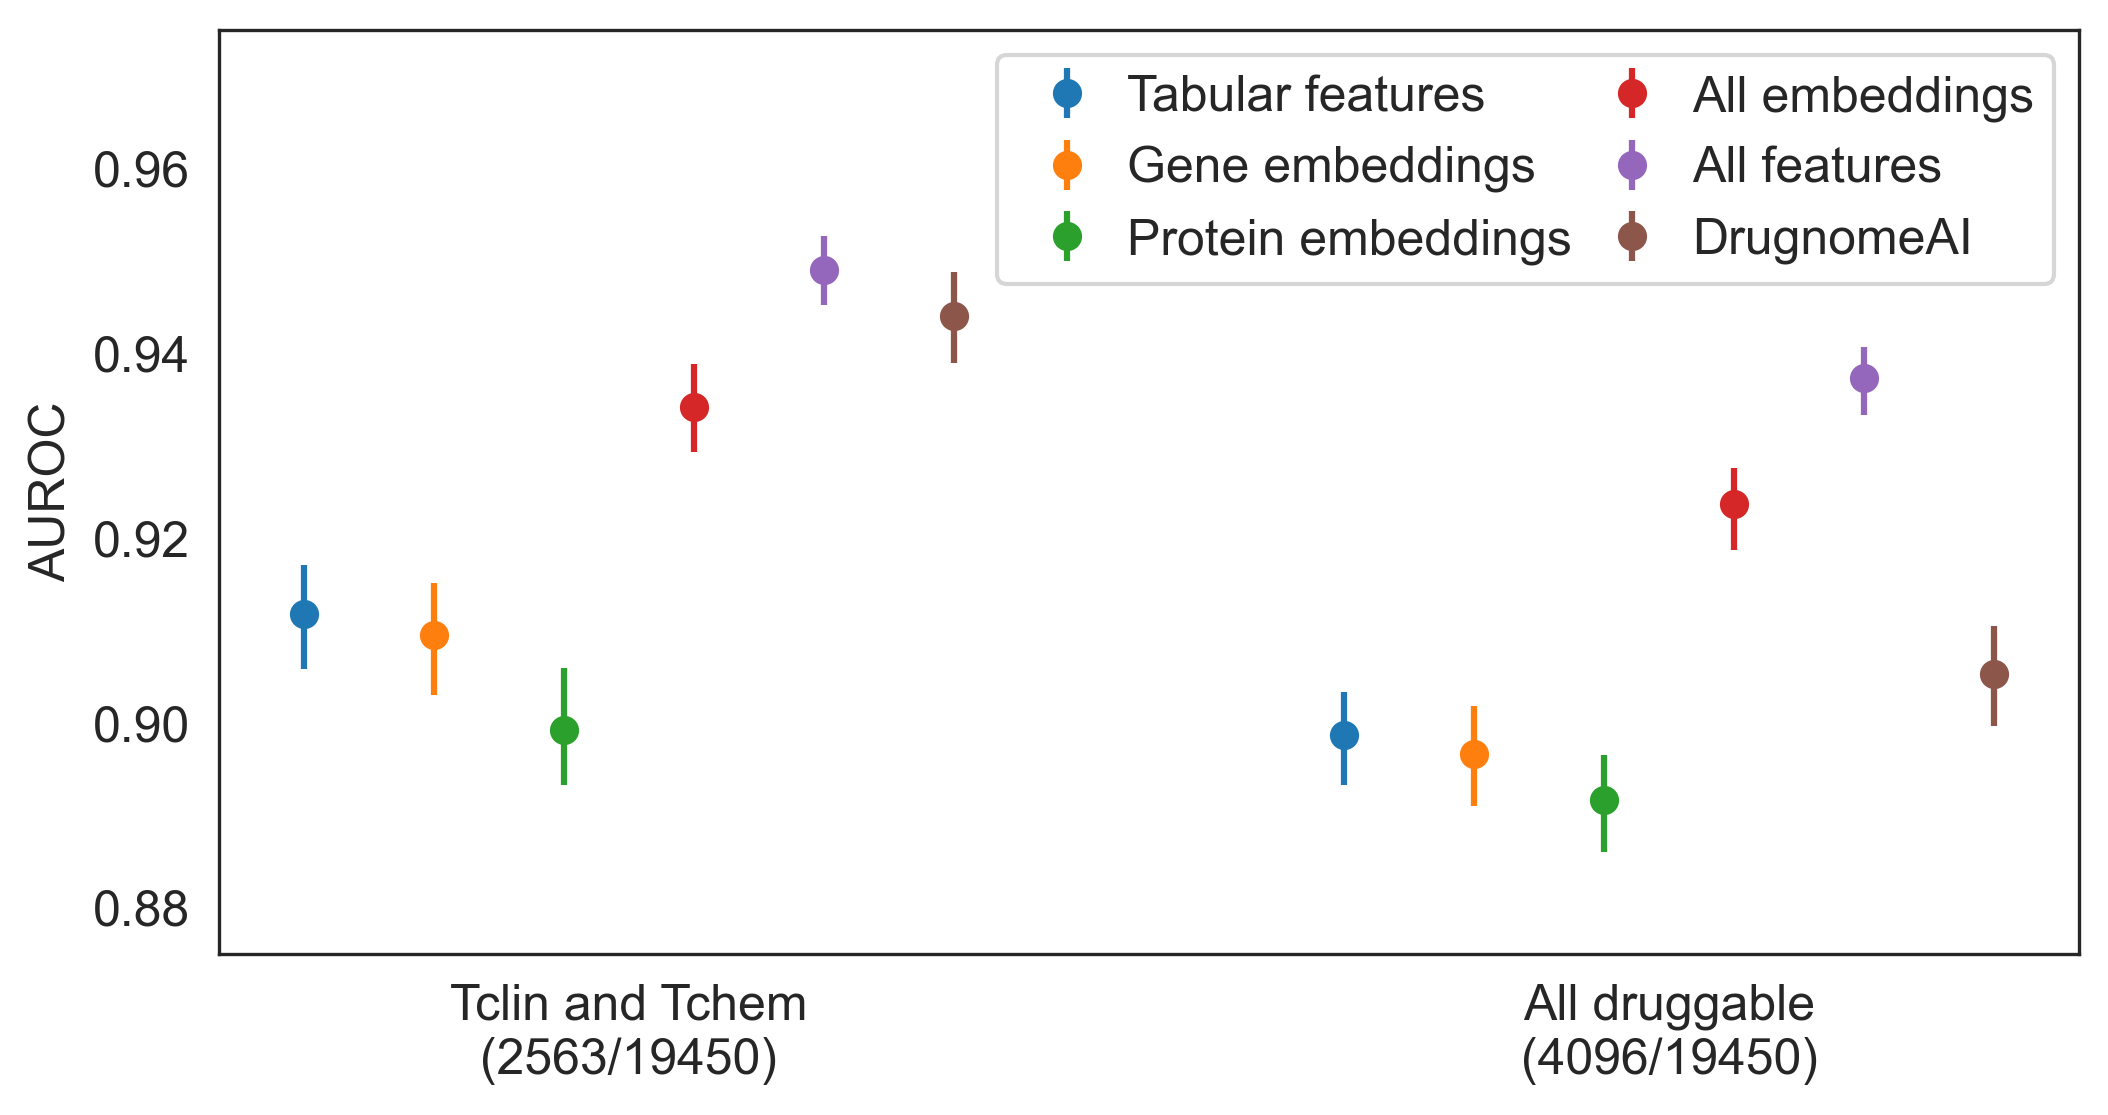

In [159]:
res = metrics.copy()
res = res.loc[~res['metric'].str.contains('micro|macro')]
res = res.loc[res['metric'].str.contains('auroc')]
res['metric'] = res['metric'].map({'auroc_druggable':f'All druggable\n({n_druggable}/{n_ids})',
                                   'auroc_tclin_tchem':f'Tclin and Tchem\n({n_tclintchem}/{n_ids})'})
res['metric'] = pd.Categorical(res['metric'], [f'Tclin and Tchem\n({n_tclintchem}/{n_ids})',f'All druggable\n({n_druggable}/{n_ids})'])
res = res.sort_values(['model','metric'])

sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['model'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['metric'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['model'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['metric'].unique())))
ax.set_xticklabels(res['metric'].unique())
ax.legend(title='', ncols=2, loc='upper right', columnspacing=0.2, handletextpad=0.2)

#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
plt.ylim([0.875,0.975])
plt.xlabel('')
plt.ylabel('AUROC')


Text(0, 0.5, 'AUPRC')

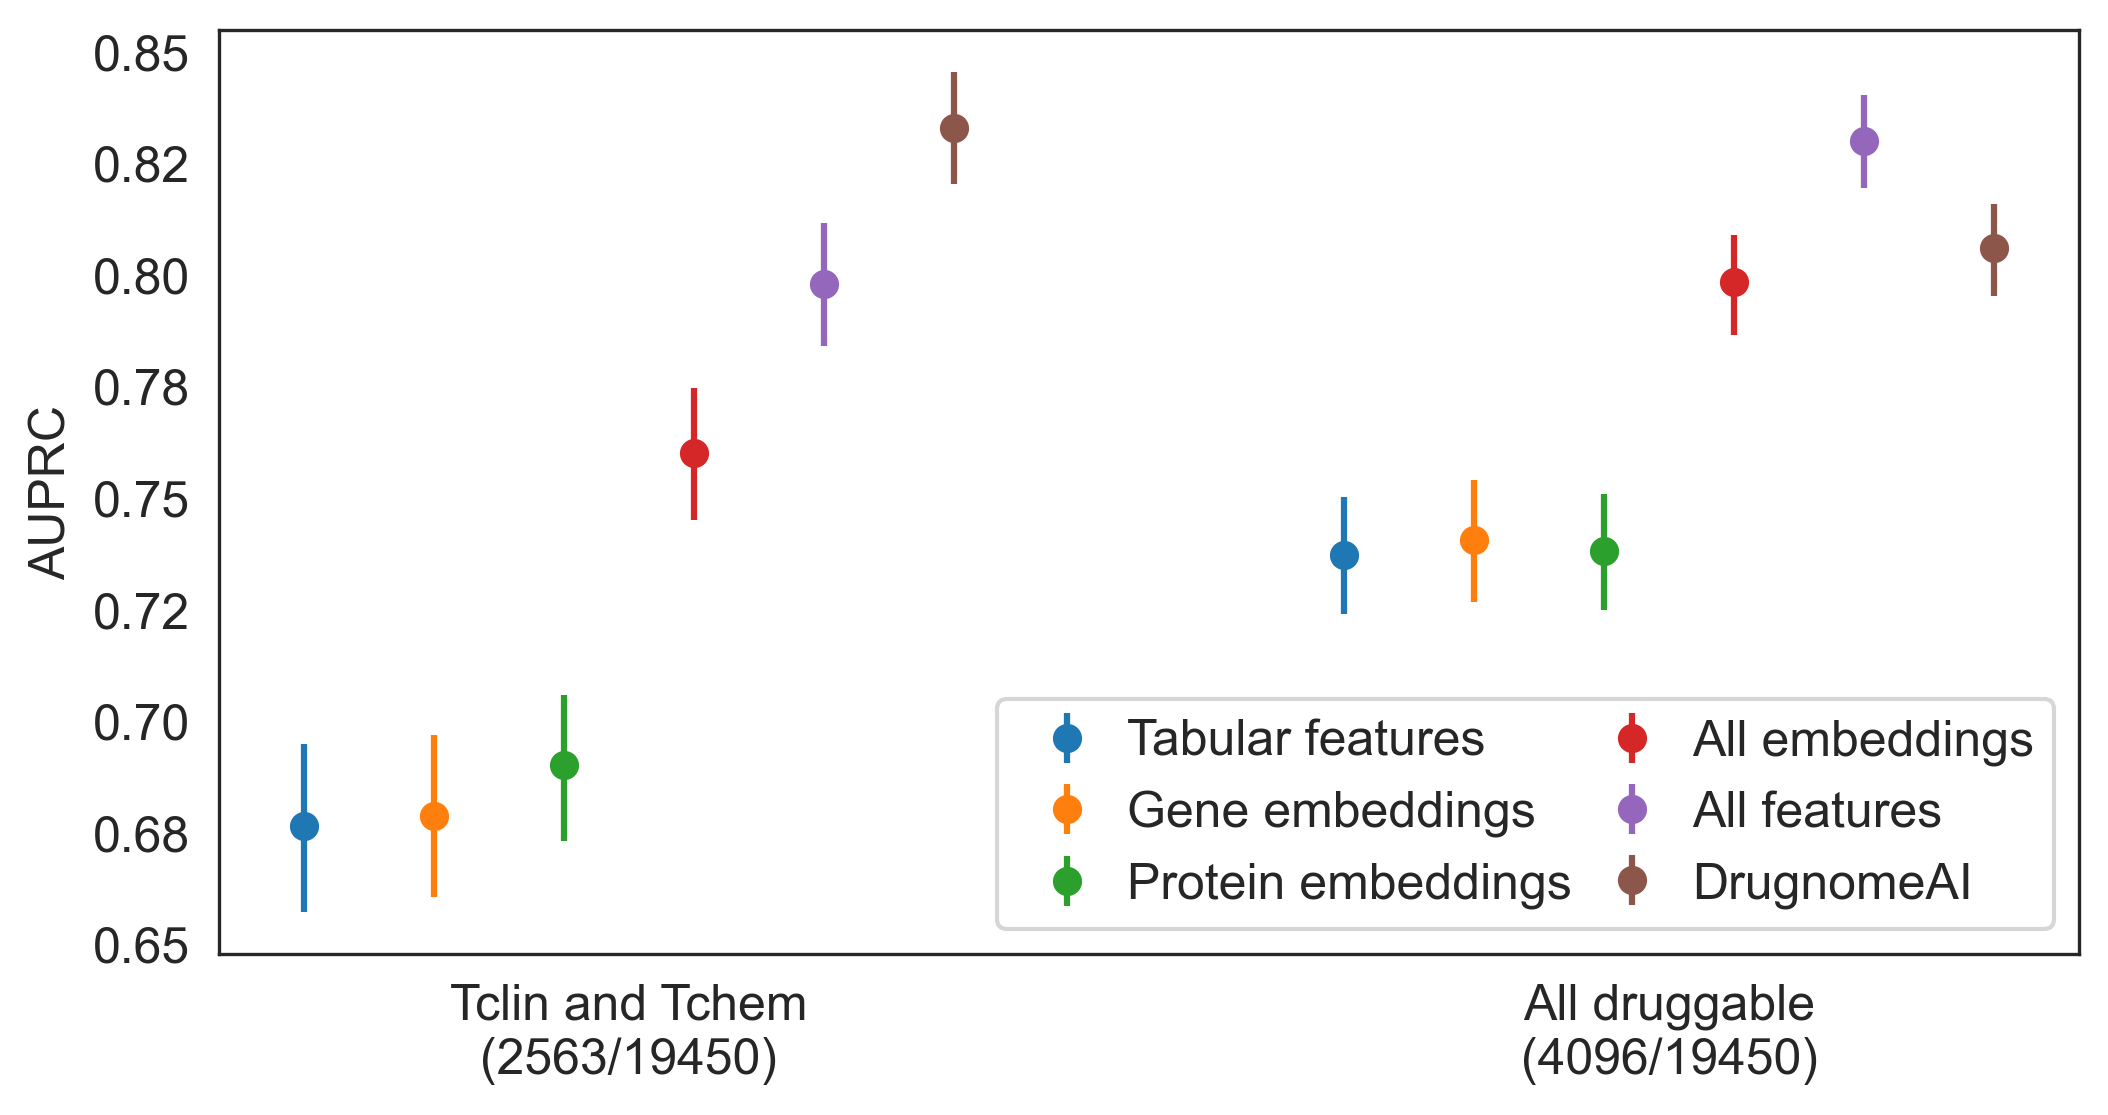

In [3]:
res = metrics.copy()
res = res.loc[~res['metric'].str.contains('micro|macro')]
res = res.loc[res['metric'].str.contains('auprc')]
res['metric'] = res['metric'].map({'auprc_druggable':f'All druggable\n({n_druggable}/{n_ids})',
                                   'auprc_tclin_tchem':f'Tclin and Tchem\n({n_tclintchem}/{n_ids})'})
res['metric'] = pd.Categorical(res['metric'], [f'Tclin and Tchem\n({n_tclintchem}/{n_ids})',f'All druggable\n({n_druggable}/{n_ids})'])
res = res.sort_values(['model','metric'])

sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['model'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['metric'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['model'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['metric'].unique())))
ax.set_xticklabels(res['metric'].unique())
ax.legend(title='', ncols=2, loc='lower right', columnspacing=0.2, handletextpad=0.2)
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.xlabel('')
plt.ylabel('AUPRC')


Text(0, 0.5, 'True proportion')

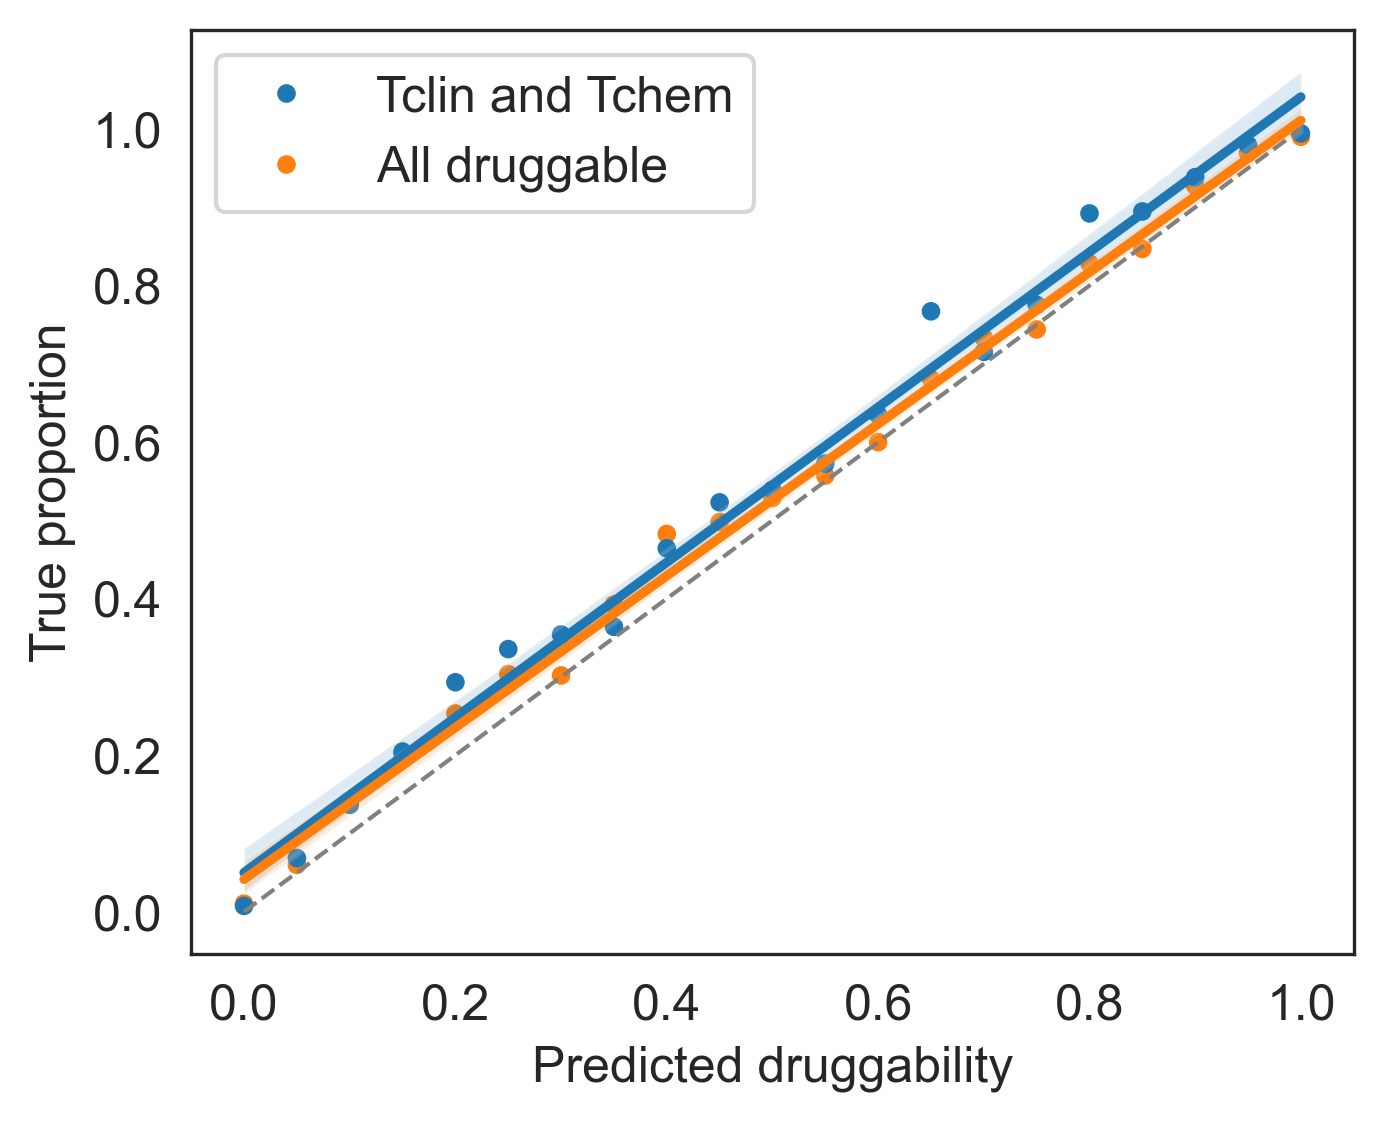

In [3]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','tclin_tchem','druggable']]
data=pd.read_csv(f'./Training/Predictions/druggability_all_holdout_predictions.csv').merge(data)

melt_data = pd.DataFrame({
    "pred": data["pred_tc"].apply(round_to_005).tolist() + 
            data["pred_druggable"].apply(round_to_005).tolist(),
    "true": data["tclin_tchem"].tolist() + 
            data["druggable"].tolist(),
    "hue": ["tclin_tchem"] * len(data) + ["druggable"] * len(data)
})

calibration_data = melt_data.groupby(["pred", "hue"]).agg(
    proportion_true=("true", "mean"),
    count=("true", "size")).reset_index()
calibration_data = calibration_data[calibration_data["count"] >= 10]
calibration_data['hue'] = calibration_data['hue'].map({'tclin_tchem':'Tclin and Tchem','druggable':'All druggable'})
calibration_data['hue'] = pd.Categorical(calibration_data['hue'], ['Tclin and Tchem','All druggable'])

sns.set_style('white')
plt.figure(figsize=(5,4), dpi=300)

sns.scatterplot(data=calibration_data,x='pred',y='proportion_true',hue='hue',edgecolor='none',s=20)
for h,c in zip(['Tclin and Tchem','All druggable'],sns.color_palette()[:2]):
    subset=calibration_data[calibration_data['hue']==h]
    sns.regplot(data=subset,x='pred',y='proportion_true',scatter=False,color=c,label=None)
plt.plot([0,1],[0,1],'--',c='gray',lw=1)
plt.legend(title='')
plt.xlabel('Predicted druggability')
plt.ylabel('True proportion')


In [2]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','tclin_tchem','druggable']]
subsets = pd.read_pickle('./OT/Final/subsets.pkl')

model_names = ['all','drugnomeai']
metrics = pd.DataFrame()

def bootstrap_all_metrics(y_true,y_score,n_boot):
    np.random.seed(42)
    out={f'auroc_{c}':[] for c in ['tclin_tchem','druggable']}
    out.update({f'auprc_{c}':[] for c in ['tclin_tchem','druggable']})
    out.update({f'brier_{c}':[] for c in ['tclin_tchem','druggable']})
    for x in ['auroc_micro','auroc_macro','auprc_micro','auprc_macro','hamming','brier_micro','brier_macro']:
        out[x]=[]
    for _ in range(n_boot):
        idx=np.random.randint(0,len(y_true),len(y_true))
        yt,ys=y_true[idx],y_score[idx]
        for i,c in enumerate(['tclin_tchem','druggable']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:,i],ys[:,i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:,i],ys[:,i]))
            out[f'brier_{c}'].append(np.mean((ys[:,i] - yt[:,i])**2))
        out['auroc_micro'].append(roc_auc_score(yt,ys,average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt,ys,average='macro'))
        out['auprc_micro'].append(average_precision_score(yt,ys,average='micro'))
        out['auprc_macro'].append(average_precision_score(yt,ys,average='macro'))
        out['hamming'].append(hamming_loss(yt,(ys>=0.5).astype(int)))
        out['brier_micro'].append(np.mean((ys - yt)**2))
        out['brier_macro'].append(np.mean([(ys[:,i] - yt[:,i])**2 for i in range(yt.shape[1])]))

    return {k:(np.mean(v),np.percentile(v,2.5),np.percentile(v,97.5)) for k,v in out.items()}

for subset in ['all','class_enzyme','class_transporter','class_tf','class_gpcr','class_vgic','constrained','not_constrained','novel']:
    if subset == 'all':
        inc_genes = data['ID'].unique()
    else:
        inc_genes = subsets.loc[subsets[subset] == 1]['gene'].to_list()
    for i in model_names:
        try:
            if i == 'drugnomeai':
                res=pd.read_csv('./Other/drugnomeai.csv').rename({'Gene Name':'ID'},axis=1).merge(data)
                res['pred_tc']=res['Tclin & Tchem'].copy()
                res['pred_druggable']=res['Tclin & Tchem'].copy()
            else:
                res=pd.read_csv(f'./Training/Predictions/druggability_{i}_holdout_predictions.csv').merge(data)
            res = res.loc[res['ID'].isin(inc_genes)]
            y_true=res[['tclin_tchem','druggable']].values
            y_score=res[['pred_tc','pred_druggable']].values
            boot=bootstrap_all_metrics(y_true,y_score,500)
            new_records=[]
            for k,(m,l,h) in boot.items():
                new_records.append({'subset':subset,'model':i,'metric':k,'mean':m,'ci_low':l,'ci_high':h})
            metrics=pd.concat([metrics,pd.DataFrame(new_records)],ignore_index=True)
        except:
            continue

metrics.to_pickle('./Training/Metrics/druggability_subset.pkl')

In [3]:
metrics = pd.read_pickle('./Training/Metrics/druggability_subset.pkl')
metrics['model'] = metrics['model'].map({'all':'All features',
                                         'drugnomeai':'DrugnomeAI'})
metrics['model'] = pd.Categorical(metrics['model'], ['All features','DrugnomeAI'])
metrics['subset'] = metrics['subset'].map({'all':'All',
                                           'class_enzyme':'Enzyme','class_transporter':'Transporter',
                                           'class_tf':'TF','class_gpcr':'GPCR',
                                           'class_vgic':'VGIC','constrained':'LOEUF < 0.6',
                                           'not_constrained':'LOEUF ≥ 0.6',
                                           'novel':'Novel'})
metrics['subset'] = pd.Categorical(metrics['subset'], ['All','Enzyme','GPCR','TF','Transporter','VGIC','LOEUF < 0.6','LOEUF ≥ 0.6','Novel'])

data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)
n_ids = data['ID'].nunique()
n_tclintchem = data['tclin_tchem'].sum()
n_druggable = data['druggable'].sum()


Text(0, 0.5, 'AUROC')

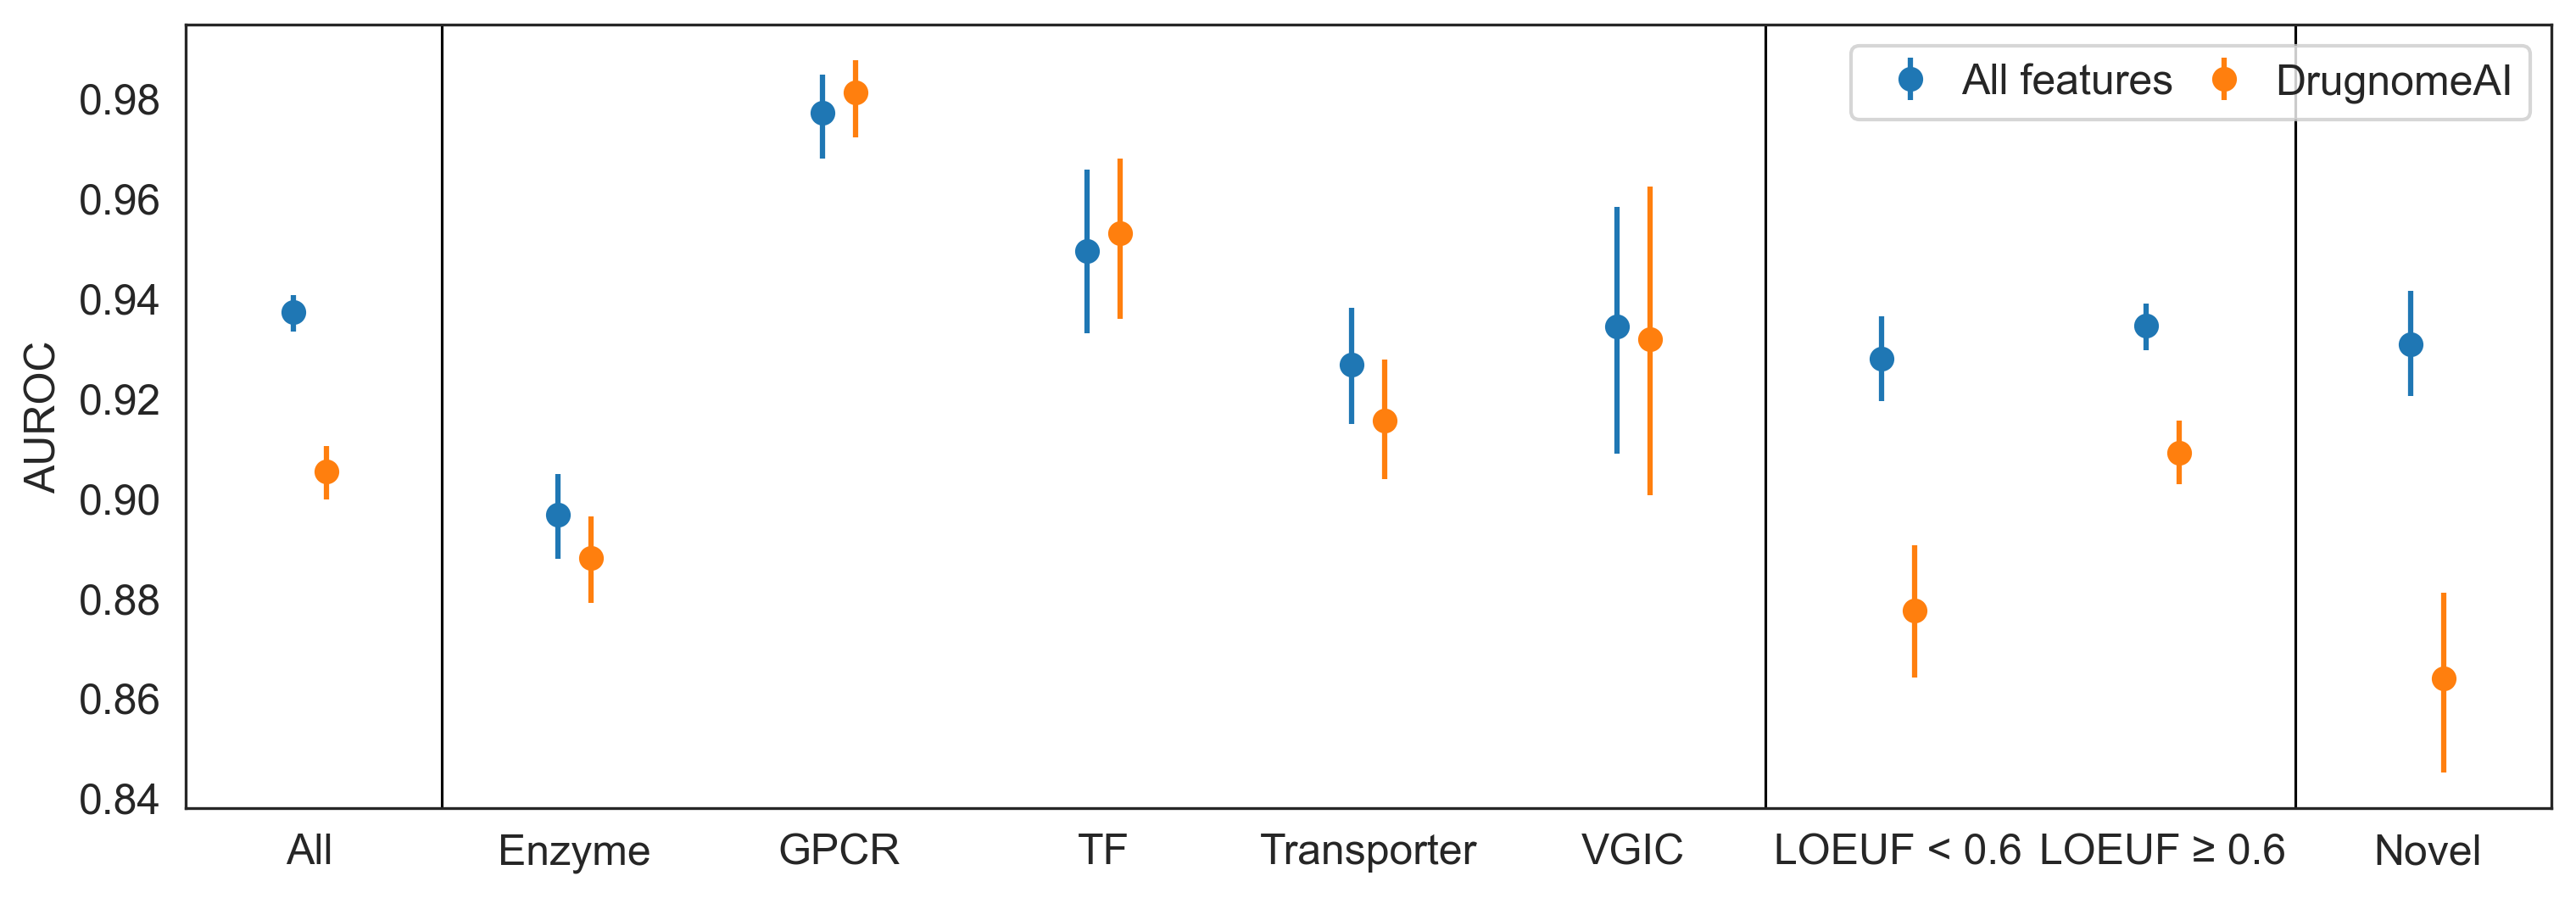

In [5]:
res = metrics.copy()
#res = res.loc[res['model'] == 'All features']
res = res.loc[~res['metric'].str.contains('micro|macro')]
res = res.loc[res['metric'].str.contains('auroc')]
res = res.loc[res['metric'] == 'auroc_druggable']
res['metric'] = res['metric'].map({'auroc_druggable':f'All druggable\n({n_druggable}/{n_ids})',
                                   'auroc_tclin_tchem':f'Tclin and Tchem\n({n_tclintchem}/{n_ids})'})
#res['metric'] = pd.Categorical(res['metric'], [f'Tclin and Tchem\n({n_tclintchem}/{n_ids})',f'All druggable\n({n_druggable}/{n_ids})'])
res = res.sort_values(['model','subset','metric'])

sns.set_style('white')

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
mechanisms = res['model'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['subset'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['model'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['subset'].unique())))
ax.set_xticklabels(res['subset'].unique())
ax.legend(title='', ncols=2, loc='upper right', columnspacing=0.2, handletextpad=0.2)

#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=0.5, color='black', linewidth=0.75)
plt.axvline(x=5.5, color='black', linewidth=0.75)
plt.axvline(x=7.5, color='black', linewidth=0.75)

#plt.ylim([0.875,0.975])
plt.xlabel('')
plt.ylabel('AUROC')


### Architecture

In [ ]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename(columns={'gene': 'ID'})[['ID','neg','other','pos']]
model_names = ['gb', 'cnn', 'lr']
metrics = []

def bootstrap_metrics(y_true, y_score, n_boot=500):
    np.random.seed(42)
    results = {'auroc': [], 'auprc': [], 'brier': []}
    
    for _ in range(n_boot):
        idx = np.random.randint(0, len(y_true), len(y_true))
        yt, ys = y_true[idx], y_score[idx]
        results['auroc'].append(roc_auc_score(yt, ys))
        results['auprc'].append(average_precision_score(yt, ys))
        results['brier'].append(np.mean((ys - yt) ** 2))
    
    return {k: (np.mean(v), np.percentile(v, 2.5), np.percentile(v, 97.5)) for k, v in results.items()}

for model in model_names:
    file_path = f'./Training/Predictions/{model}_druggability_all_holdout_predictions.csv' if model != 'gb' else './Training/Predictions/druggability_all_holdout_predictions.csv'
    res = pd.read_csv(file_path).merge(data)
    
    y_true, y_score = res[['druggable']].values.ravel(), res[['pred_druggable']].values.ravel()
    boot_metrics = bootstrap_metrics(y_true, y_score)
    
    metrics.extend([{'model': model, 'metric': k, 'mean': m, 'ci_low': l, 'ci_high': h} for k, (m, l, h) in boot_metrics.items()])

pd.DataFrame(metrics).to_pickle('./Training/Metrics/druggability_architecture.pkl')


In [39]:
metrics = pd.read_pickle('./Training/Metrics/druggability_architecture.pkl')
metrics['model'] = metrics['model'].map({'gb':'XGBoost','cnn':'CNN','lr':'Logistic regression'})

table = metrics.copy()
table.loc[table['metric'].str.contains('auroc'), 'metric'] = 'AUROC'
table.loc[table['metric'].str.contains('auprc'), 'metric'] = 'AUPRC'
table.loc[table['metric'].str.contains('brier'), 'metric'] = 'Brier score'
table = table.dropna()
table['value'] = table['mean'].round(3).astype(str) + ' (' + table['ci_low'].round(3).astype(str) + '-' + table['ci_high'].round(3).astype(str) + ')'
table = pd.pivot_table(table, index=['model'], columns='metric', values='value', aggfunc='first').reset_index()
table = table[['model','AUROC','AUPRC','Brier score']]
table


metric                model                AUROC                AUPRC  \
0                       CNN  0.924 (0.919-0.928)  0.803 (0.792-0.814)   
1       Logistic regression  0.919 (0.914-0.923)    0.788 (0.775-0.8)   
2                   XGBoost  0.937 (0.933-0.941)     0.83 (0.82-0.84)   

metric          Brier score  
0        0.083 (0.08-0.085)  
1       0.086 (0.083-0.089)  
2       0.077 (0.074-0.079)

### Mantis-ML and OT correlations

In [31]:
mantis = pd.read_pickle('./Other/mantis_max.pkl')
da = pd.read_pickle('./OT/Final/max_da.pkl')

drugnome = pd.read_csv('./Other/drugnomeai.csv')[['Gene Name','Tclin & Tchem']].set_axis(['gene','drugnome'],axis=1)
dd = pd.read_csv('./Training/Predictions/druggability_all_holdout_predictions.csv').rename({'ID':'gene'},axis=1)
dd = dd.merge(mantis, how='left').merge(da, how='left').merge(drugnome, how='left')
dd['max_ot'] = dd['max_ot'].fillna(0)


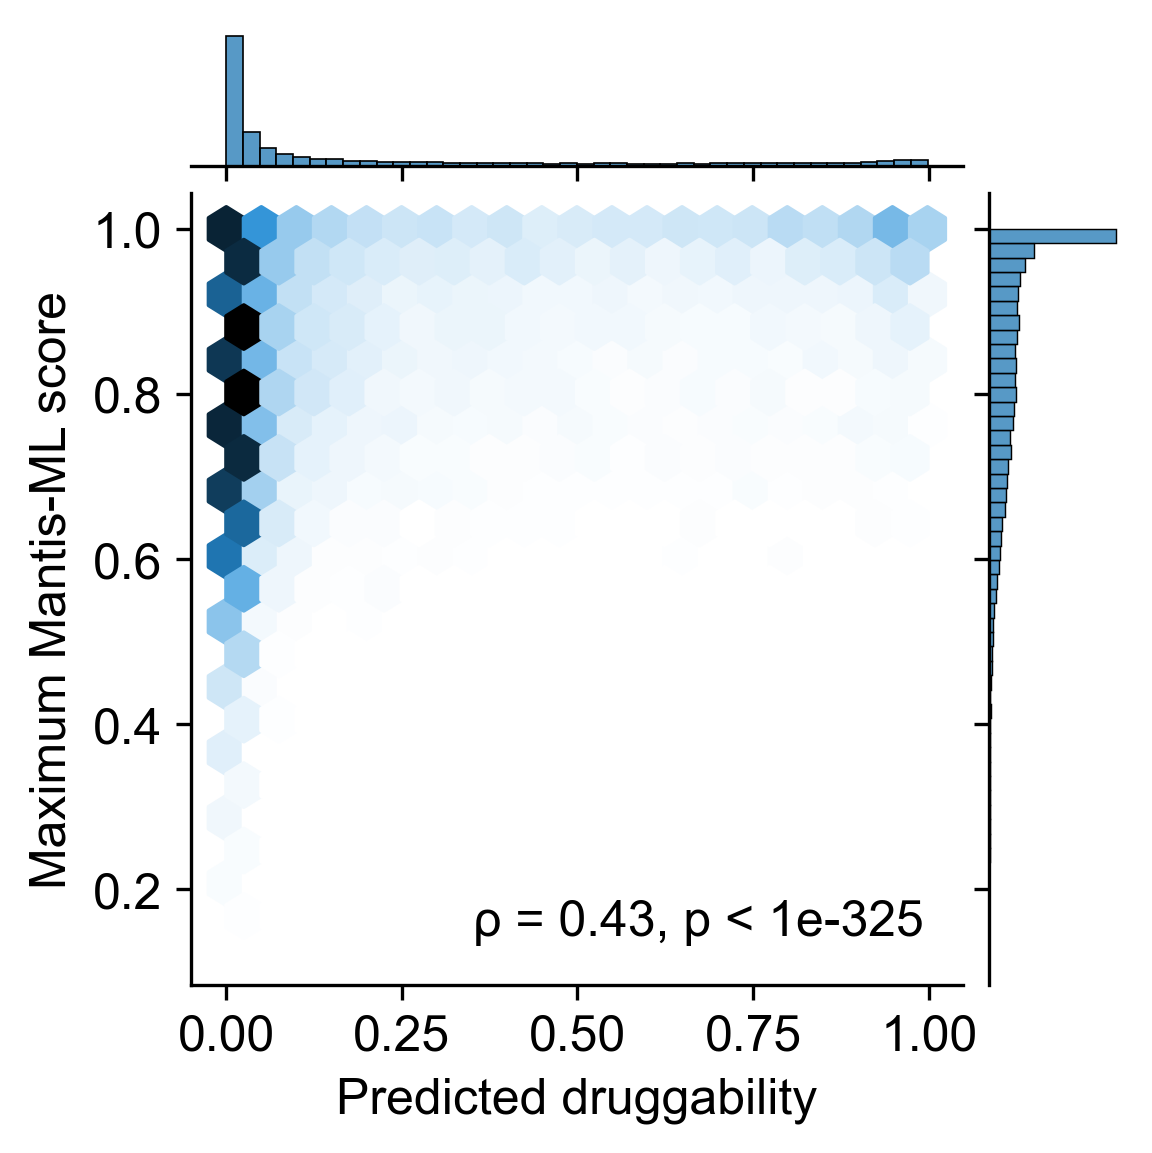

In [32]:
x = 'pred_druggable'
y = 'max_mantis'
temp = dd.dropna(subset=[x,y])

g = sns.jointplot(data=temp, x=x, y=y, kind="hex", joint_kws={'gridsize': 20}, height=4)
g.fig.set_dpi(300)

rho, p_value = spearmanr(temp[x], temp[y])
annotation = f'ρ = {rho:.2f}, p < 1e-325'
g.ax_joint.text(0.95, 0.05, annotation, transform=g.ax_joint.transAxes,
                ha='right', va='bottom', fontsize=12)

plt.xlabel('Predicted druggability')
plt.ylabel('Maximum Mantis-ML score')
plt.show()


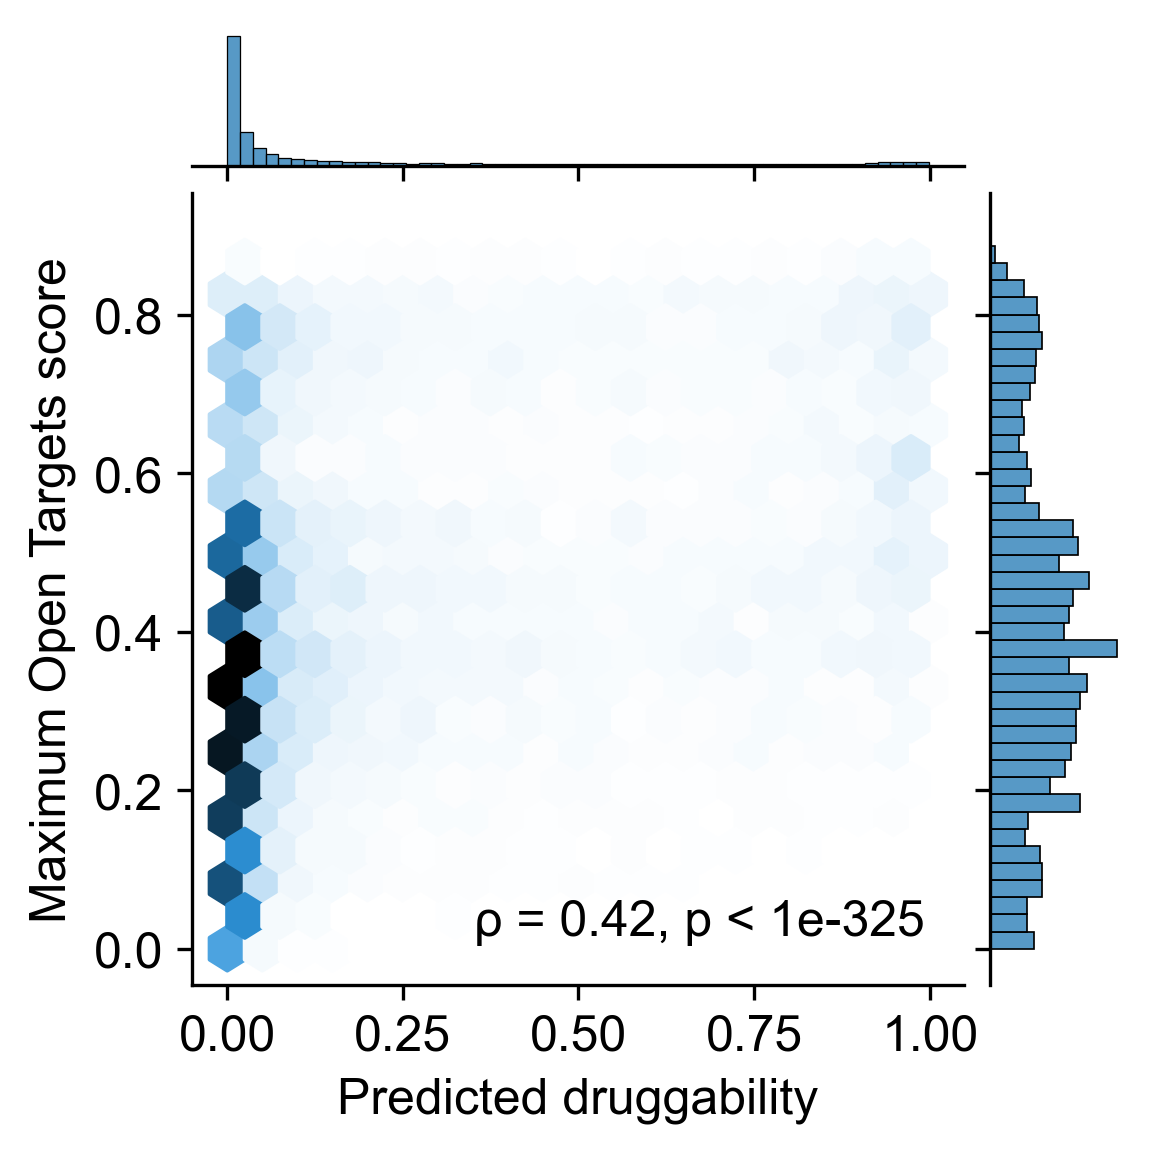

In [33]:
x = 'pred_druggable'
y = 'max_ot'
temp = dd.dropna(subset=[x,y])

g = sns.jointplot(data=temp, x=x, y=y, kind="hex", joint_kws={'gridsize': 20}, height=4)
g.fig.set_dpi(300)

rho, p_value = spearmanr(temp[x], temp[y])
annotation = f'ρ = {rho:.2f}, p < 1e-325'
g.ax_joint.text(0.95, 0.05, annotation, transform=g.ax_joint.transAxes,
                ha='right', va='bottom', fontsize=12)

plt.xlabel('Predicted druggability')
plt.ylabel('Maximum Open Targets score')
plt.show()


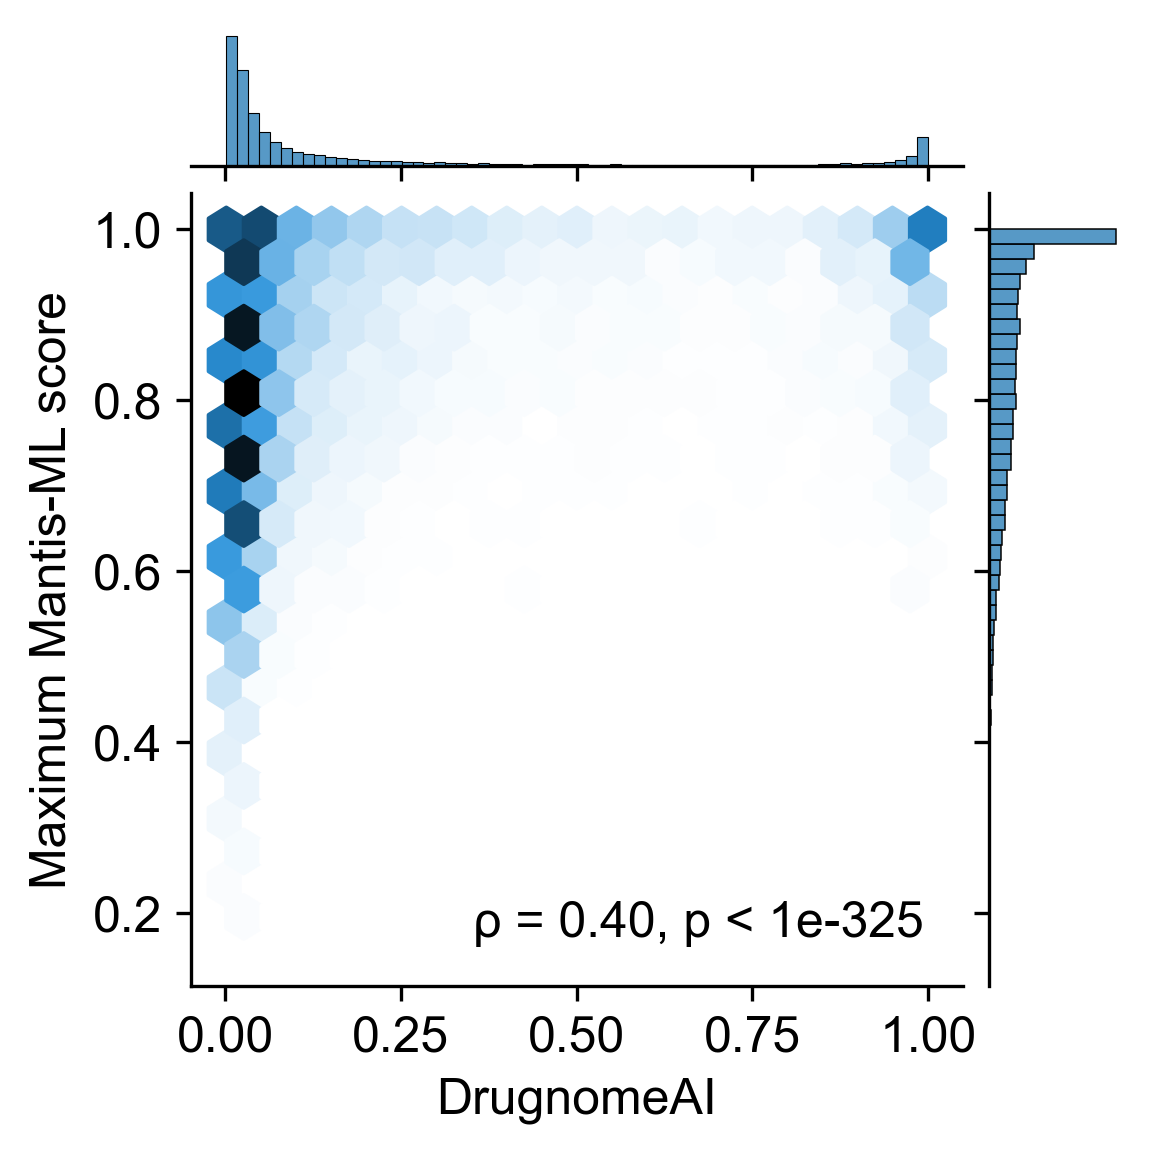

In [35]:
x = 'drugnome'
y = 'max_mantis'
temp = dd.dropna(subset=[x,y])

g = sns.jointplot(data=temp, x=x, y=y, kind="hex", joint_kws={'gridsize': 20}, height=4)
g.fig.set_dpi(300)

rho, p_value = spearmanr(temp[x], temp[y])
annotation = f'ρ = {rho:.2f}, p < 1e-325'
g.ax_joint.text(0.95, 0.05, annotation, transform=g.ax_joint.transAxes,
                ha='right', va='bottom', fontsize=12)

plt.xlabel('DrugnomeAI')
plt.ylabel('Maximum Mantis-ML score')
plt.show()


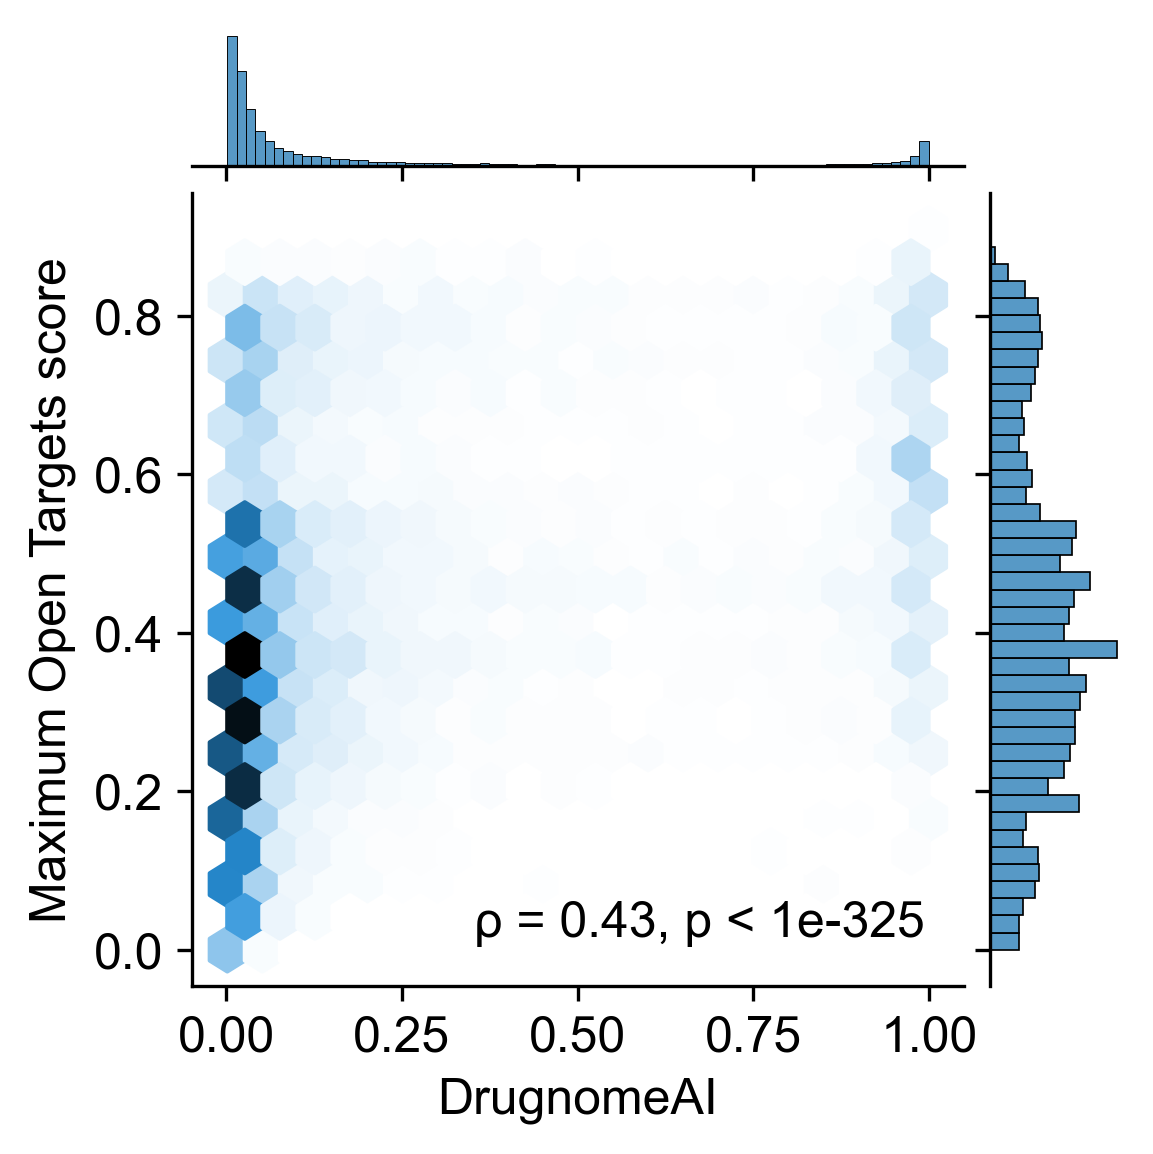

In [36]:
x = 'drugnome'
y = 'max_ot'
temp = dd.dropna(subset=[x,y])

g = sns.jointplot(data=temp, x=x, y=y, kind="hex", joint_kws={'gridsize': 20}, height=4)
g.fig.set_dpi(300)

rho, p_value = spearmanr(temp[x], temp[y])
annotation = f'ρ = {rho:.2f}, p < 1e-325'
g.ax_joint.text(0.95, 0.05, annotation, transform=g.ax_joint.transAxes,
                ha='right', va='bottom', fontsize=12)

plt.xlabel('DrugnomeAI')
plt.ylabel('Maximum Open Targets score')
plt.show()


## Druggability and DOE

In [38]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)
gene_embed = pd.read_pickle('./GenePT/genept_em3l.pkl').rename({'gene':'ID'},axis=1).round(5).iloc[:, :257]
prot_embed = pd.read_pickle('./UniProt/pca_embeddings_128.pkl').rename({'gene':'ID'},axis=1)
data = data.drop(['source','tdl'],axis=1).merge(gene_embed, how='left').merge(prot_embed, how='left')
data.columns = data.columns.astype(str)

genetics = ['mab_count', 'tissueSpecificity', 'tissueDistribution', 
           'hasPocket', 'mouseKOScore', 'paralogMaxIdentityPercentage',
           'oncokb_oncogene', 'oncokb_suppressor', 'oncokb_sources',
           'loc_intracellular', 'loc_membrane', 'loc_secreted', 'loc_plasma',
           'class_enzyme', 'class_transporter', 'class_tf', 'class_gpcr',
           'class_vgic', 'lof.oe', 'lof.pLI', 'lof.pRec', 'lof.pNull',
           'lof.oe_ci.upper', 'mis.oe', 'mis_pphen.oe', 'syn.oe', 
           'gofcards', 'omim_ad', 'omim_ar', 'depmap_ss','clingen_hi', 
           'depmap_ce', 'badonyi_pgof', 'badonyi_pdn', 'badonyi_plof',
           'collins_phaplo', 'collins_ptriplo', 
           'protein_length', 'gtex_tau', 'af_pockets_0', 'af_pockets_0.1']
gene_embed = list(gene_embed.drop('ID',axis=1).columns.astype(str))
prot_embed = list(prot_embed.drop('ID',axis=1).columns.astype(str))


In [ ]:
num_folds_outer = 8
num_folds_inner = 8
shap_enabled = True

if True:
    model_names = ['all','gene_embed','prot_embed','all_embed','genetics']
    feature_names = [genetics+gene_embed+prot_embed,gene_embed,prot_embed,gene_embed+prot_embed,genetics]

for i,j in zip(model_names, feature_names):
    print(i)    
    
    X = data[j]
    y = data[["neg","other","pos"]].values    
    y_binary = (y > 0).astype(int)
    
    ids = data["ID"].values
    
    outer_kf = KFold(n_splits=num_folds_outer, shuffle=True, random_state=42)
    fold_counter_outer = 0
    
    all_preds = []
    all_ids = []

    shap_neg = pd.DataFrame()
    shap_oth = pd.DataFrame()
    shap_pos = pd.DataFrame()
    
    for outer_train_idx, holdout_idx in outer_kf.split(X):
        fold_counter_outer += 1
        print(fold_counter_outer)
        X_outer_train, X_holdout = X.iloc[outer_train_idx], X.iloc[holdout_idx]
        y_outer_train, y_holdout = y[outer_train_idx], y[holdout_idx]
        y_holdout_binary = y_binary[holdout_idx]
        ids_holdout = ids[holdout_idx]
    
        inner_kf = KFold(n_splits=num_folds_inner, shuffle=True, random_state=42)
        fold_counter_inner = 0
        print(fold_counter_inner)
        holdout_preds_all = []
        for inner_train_idx, val_idx in inner_kf.split(X_outer_train):
            fold_counter_inner += 1
            X_inner_train, X_val = X_outer_train.iloc[inner_train_idx], X_outer_train.iloc[val_idx]
            y_inner_train, y_val = y_outer_train[inner_train_idx], y_outer_train[val_idx]
    
            dtrain = xgb.DMatrix(X_inner_train, label=y_inner_train, enable_categorical=True)
            dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
            dholdout = xgb.DMatrix(X_holdout, enable_categorical=True)
    
            params = {
                "objective":"reg:logistic",
                "max_depth":7,
                "alpha":5,
                "lambda":1,
                "eta":0.1,
                "min_child_weight":10,
                "nthread":12,
            }
    
            model = xgb.train(
                params, dtrain, num_boost_round=2000,
                early_stopping_rounds=15,
                evals=[(dval,"eval")],
                verbose_eval=False
            )
    
            # Save model
            # model.save_model(f"./Training/Models/druggability_doe_{i}_outer{fold_counter_outer}_inner{fold_counter_inner}.json")

            if (i in ['all']) & (shap_enabled == True):
                if fold_counter_inner == 1:
                    explainer = shap.TreeExplainer(model)
                    explanation = explainer(dholdout)
                    ex_neg = pd.DataFrame(explanation[:,:,0].values, columns=X.columns)
                    ex_neg['ID'] = ids_holdout
                    shap_neg = pd.concat([shap_neg,ex_neg])
                    ex_oth = pd.DataFrame(explanation[:,:,1].values, columns=X.columns)
                    ex_oth['ID'] = ids_holdout
                    shap_oth = pd.concat([shap_oth,ex_oth])
                    ex_pos = pd.DataFrame(explanation[:,:,2].values, columns=X.columns)
                    ex_pos['ID'] = ids_holdout
                    shap_pos = pd.concat([shap_pos,ex_pos])
                    
            preds_holdout = model.predict(dholdout)
            preds_holdout = preds_holdout.reshape(len(X_holdout), -1)
            holdout_preds_all.append(preds_holdout)
    
        holdout_preds_all = np.mean(np.stack(holdout_preds_all, axis=0), axis=0)
        
        binary_preds = (holdout_preds_all > 0.5).astype(int)
        for c in range(y_holdout_binary.shape[1]):
            auroc = roc_auc_score(y_holdout_binary[:,c], holdout_preds_all[:,c])
            auprc = average_precision_score(y_holdout_binary[:,c], holdout_preds_all[:,c])
            prop_positives = y_holdout_binary[:,c].mean()
            print(f"Outer Fold {fold_counter_outer}, Class {c}: AUROC={auroc}, AUPRC={auprc}, Proportion positives={prop_positives}")
        hl = hamming_loss(y_holdout_binary, binary_preds)
        print(f"Outer Fold {fold_counter_outer}: Hamming Loss={hl}")
    
        # Store holdout predictions
        fold_df = pd.DataFrame({
            "ID": ids_holdout,
            "pred_neg": holdout_preds_all[:,0],
            "pred_other": holdout_preds_all[:,1],
            "pred_pos": holdout_preds_all[:,2]
        })
        all_preds.append(fold_df)
        all_ids.extend(ids_holdout)
    
    # Concatenate all holdout predictions
    final_preds = pd.concat(all_preds, axis=0)
    final_preds = final_preds.groupby("ID").mean().reset_index()
    final_preds.to_csv(f"./Training/Predictions/druggability_doe_{i}_holdout_predictions.csv", index=False)

    if (i in ['all']) & (shap_enabled == True):
        shap_neg = shap_neg.groupby('ID').mean().reset_index()
        shap_neg.to_pickle(f'./Training/SHAP/druggability_doe_{i}_shap_neg.pkl')
        shap_oth = shap_oth.groupby('ID').mean().reset_index()
        shap_oth.to_pickle(f'./Training/SHAP/druggability_doe_{i}_shap_oth.pkl')
        shap_pos = shap_pos.groupby('ID').mean().reset_index()
        shap_pos.to_pickle(f'./Training/SHAP/druggability_doe_{i}_shap_pos.pkl')
        

### SHAP

In [49]:
i = 'all'
shap_neg = pd.read_pickle(f'./Training/SHAP/druggability_doe_{i}_shap_neg.pkl')
shap_pos = pd.read_pickle(f'./Training/SHAP/druggability_doe_{i}_shap_pos.pkl')
shap_oth = pd.read_pickle(f'./Training/SHAP/druggability_doe_{i}_shap_oth.pkl')

fv = data[shap_neg.columns]
fv = shap_neg[['ID']].merge(fv)
for col in ['loc_intracellular','loc_membrane','loc_secreted','loc_plasma','class_enzyme',
            'class_transporter','class_tf','class_gpcr','class_vgic','oncokb_oncogene',
            'oncokb_suppressor','oncokb_sources','omim_ad','omim_ar','gofcards','clingen_hi']:
    fv[col] = fv[col].fillna(0)
    
shap_neg = shap_neg.drop('ID', axis=1)
shap_pos = shap_pos.drop('ID', axis=1)
shap_oth = shap_oth.drop('ID', axis=1)
fv = fv.drop('ID', axis=1)

# Function to compute Spearman correlations
def compute_correlations(shap_data, fv_data):
    correlations = {}
    for col in shap_data.columns:
        if pd.api.types.is_numeric_dtype(fv_data[col]):
            mask = ~(shap_data[col].isna() | fv_data[col].isna())
            if mask.any():
                correlations[col] = spearmanr(fv_data.loc[mask, col], shap_data.loc[mask, col])[0]
    return correlations

# Function to compute SHAP absolute mean for all values and only for nonzero/non-NaN values in fv
def compute_shap_stats(shap_data, fv_data, label):
    correlations = compute_correlations(shap_data, fv_data)
    shap_values = []
    
    for col in shap_data.columns:
        all_mean = shap_data[col].abs().mean()  # Mean over all values
        
        mask = ~(fv_data[col].isna() | (fv_data[col] == 0))  # Ignore NaN and zero values in fv
        filtered_mean = shap_data.loc[mask, col].abs().mean() if mask.any() else None  # Mean over filtered values

        shap_values.append((col, all_mean, filtered_mean))

    shap_stats = pd.DataFrame(shap_values, columns=['feature', label, f'{label}_nonzero_nonNaN'])
    shap_corr = pd.DataFrame(list(correlations.items()), columns=['feature', f'{label}_corr'])
    
    return shap_stats.merge(shap_corr, how='left')

# Compute SHAP statistics for neg, pos, and other
sn = compute_shap_stats(shap_neg, fv, 'neg')
sp = compute_shap_stats(shap_pos, fv, 'pos')
so = compute_shap_stats(shap_oth, fv, 'other')

# Merge results
sa = sn.merge(sp, on='feature').merge(so, on='feature')
sa['average'] = sa[['neg', 'other', 'pos']].mean(axis=1)
sa['average_nonzero_nonNaN'] = sa[['neg_nonzero_nonNaN', 'other_nonzero_nonNaN', 'pos_nonzero_nonNaN']].mean(axis=1)

# Assign categories
sa.loc[sa['feature'].isin(genetics), 'category'] = 'Tabular features'
sa.loc[sa['feature'].isin(gene_embed), 'category'] = 'Gene embeddings'
sa.loc[sa['feature'].isin(prot_embed), 'category'] = 'Protein embeddings'

print(len(sa.loc[sa['neg_corr']/sa['pos_corr'] < 0]))
sa = sa.sort_values('average',ascending=False)
sa = sa.merge(pd.read_excel('./Supplemental tables/druggability_fi.xlsx').drop(['category'],axis=1))

sa.to_excel('./Supplemental tables/druggability_doe_fi.xlsx', index=False)


146


In [48]:
print(spearmanr(sa['neg'],sa['druggable']))
print(spearmanr(sa['pos'],sa['druggable']))
print(spearmanr(sa['other'],sa['druggable']))
print(spearmanr(sa['average'],sa['druggable']))


SignificanceResult(statistic=0.4753930981980863, pvalue=2.381813259705833e-25)
SignificanceResult(statistic=0.2747297844159475, pvalue=8.502242736689456e-09)
SignificanceResult(statistic=0.3789722834945635, pvalue=5.794031361816356e-16)
SignificanceResult(statistic=0.512905164563051, pvalue=6.856386471127508e-30)


### Distributions

In [51]:
pred = pd.read_csv(f'./Training/Predictions/druggability_doe_{i}_holdout_predictions.csv')
drug = pd.read_csv(f'./Training/Predictions/druggability_{i}_holdout_predictions.csv')
drug = drug.merge(pred).drop('pred_tc',axis=1)
print(drug['pred_neg'].median(), drug['pred_pos'].median())


0.0061115262 0.0014928574500000001


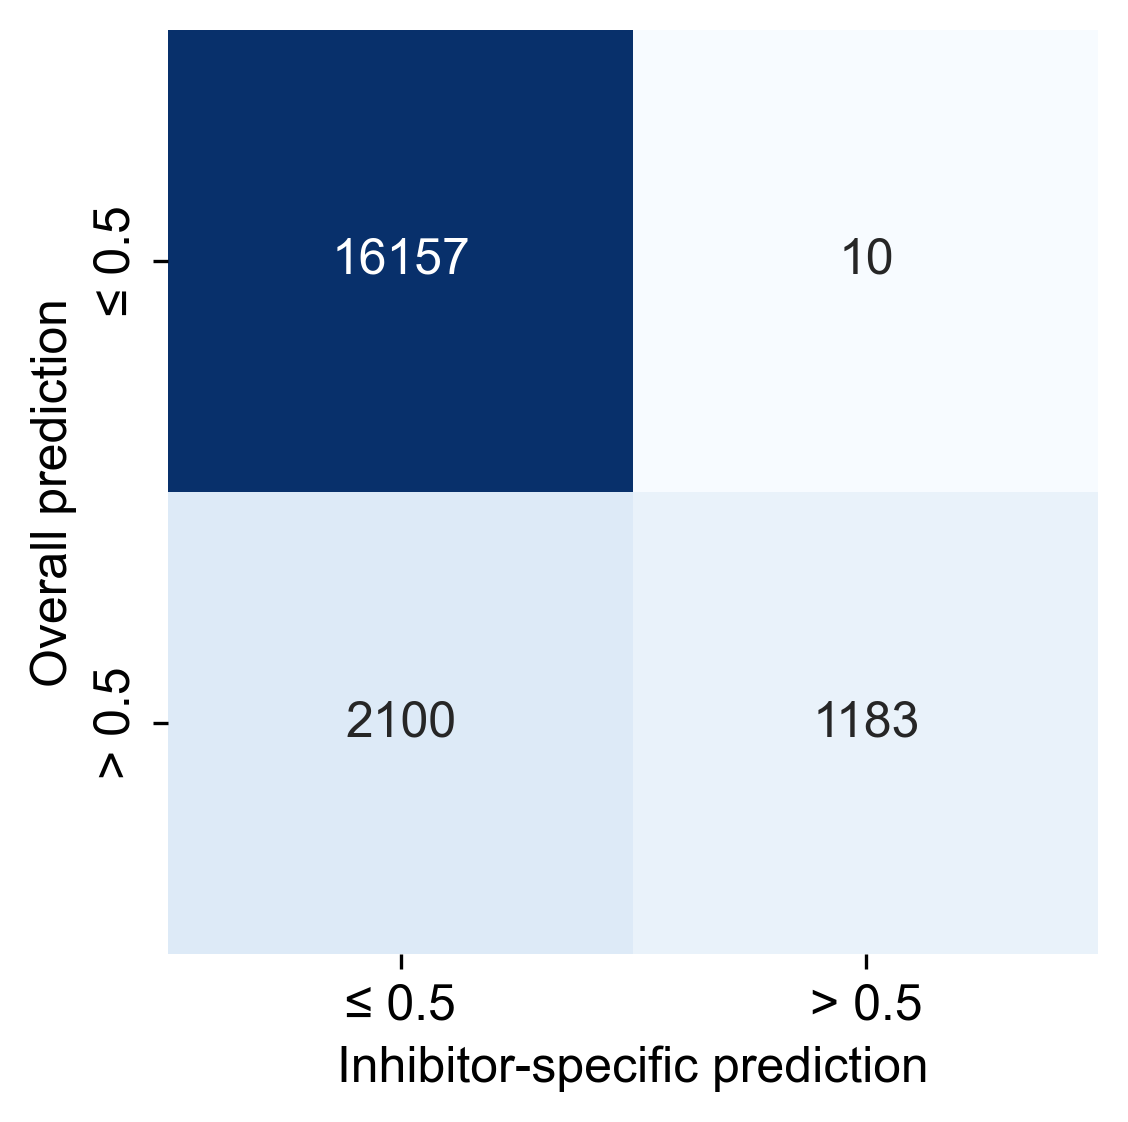

In [ ]:
# Creating labels for the bins
drug['pred_druggable_bin'] = drug['pred_druggable'].apply(lambda x: "> 0.5" if x > 0.5 else "≤ 0.5")
drug['pred_neg_bin'] = drug['pred_neg'].apply(lambda x: "> 0.5" if x > 0.5 else "≤ 0.5")

# Creating the contingency table with correct ordering
heatmap_data = drug.groupby(['pred_druggable_bin', 'pred_neg_bin']).size().unstack()
heatmap_data = heatmap_data.loc[["≤ 0.5", "> 0.5"], ["≤ 0.5", "> 0.5"]]  # Ensuring correct order

# Plotting the heatmap
plt.figure(figsize=(4,4), dpi=300)
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Inhibitor-specific prediction")
plt.ylabel("Overall prediction")
plt.show()


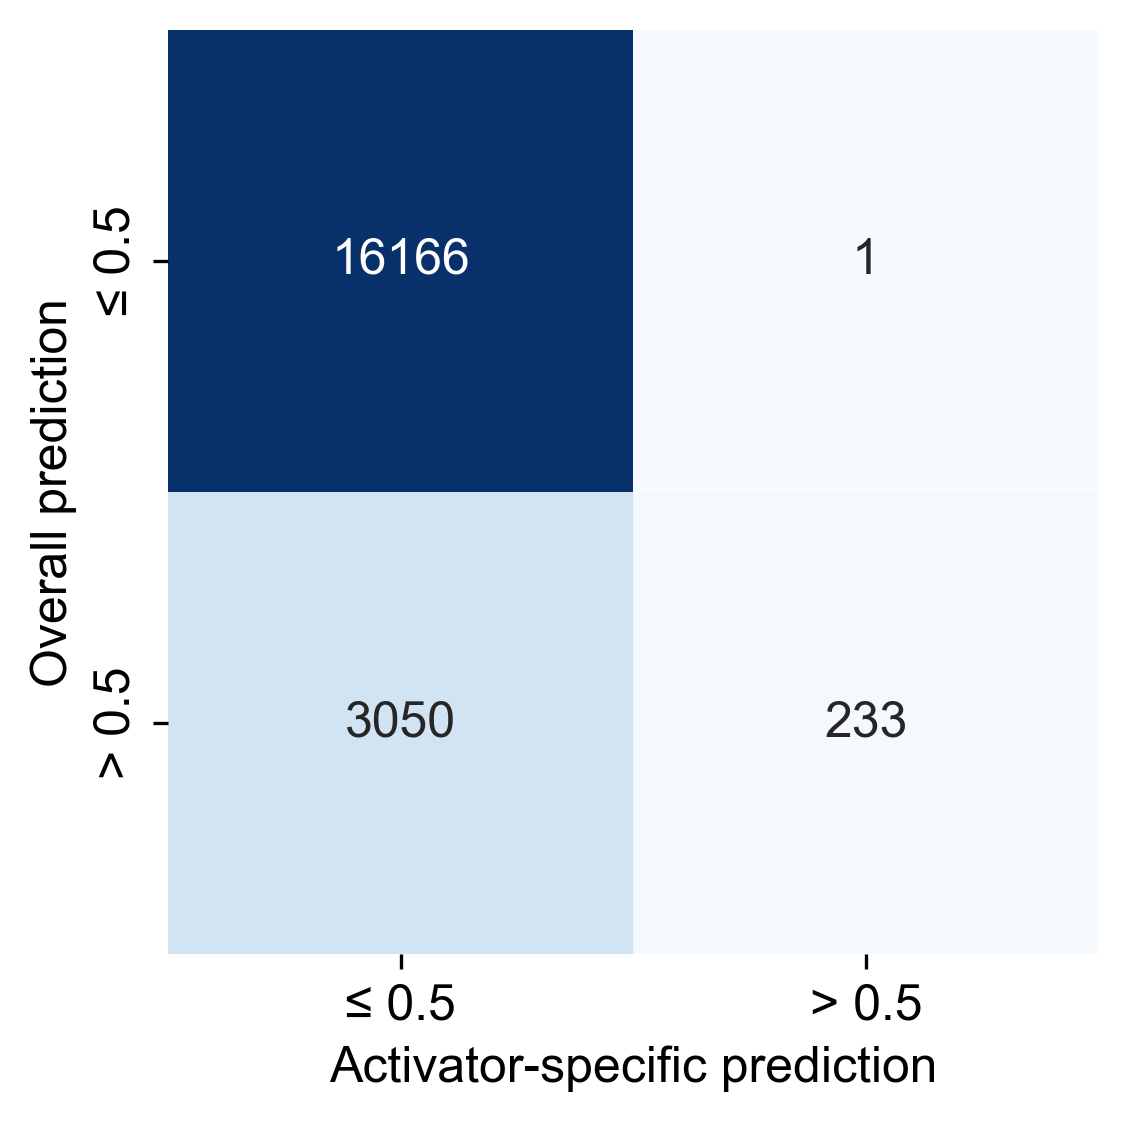

In [65]:
# Creating labels for the bins
drug['pred_druggable_bin'] = drug['pred_druggable'].apply(lambda x: "> 0.5" if x > 0.5 else "≤ 0.5")
drug['pred_neg_bin'] = drug['pred_pos'].apply(lambda x: "> 0.5" if x > 0.5 else "≤ 0.5")

# Creating the contingency table with correct ordering
heatmap_data = drug.groupby(['pred_druggable_bin', 'pred_neg_bin']).size().unstack()
heatmap_data = heatmap_data.loc[["≤ 0.5", "> 0.5"], ["≤ 0.5", "> 0.5"]]  # Ensuring correct order

# Plotting the heatmap
plt.figure(figsize=(4,4), dpi=300)
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Activator-specific prediction")
plt.ylabel("Overall prediction")
plt.show()


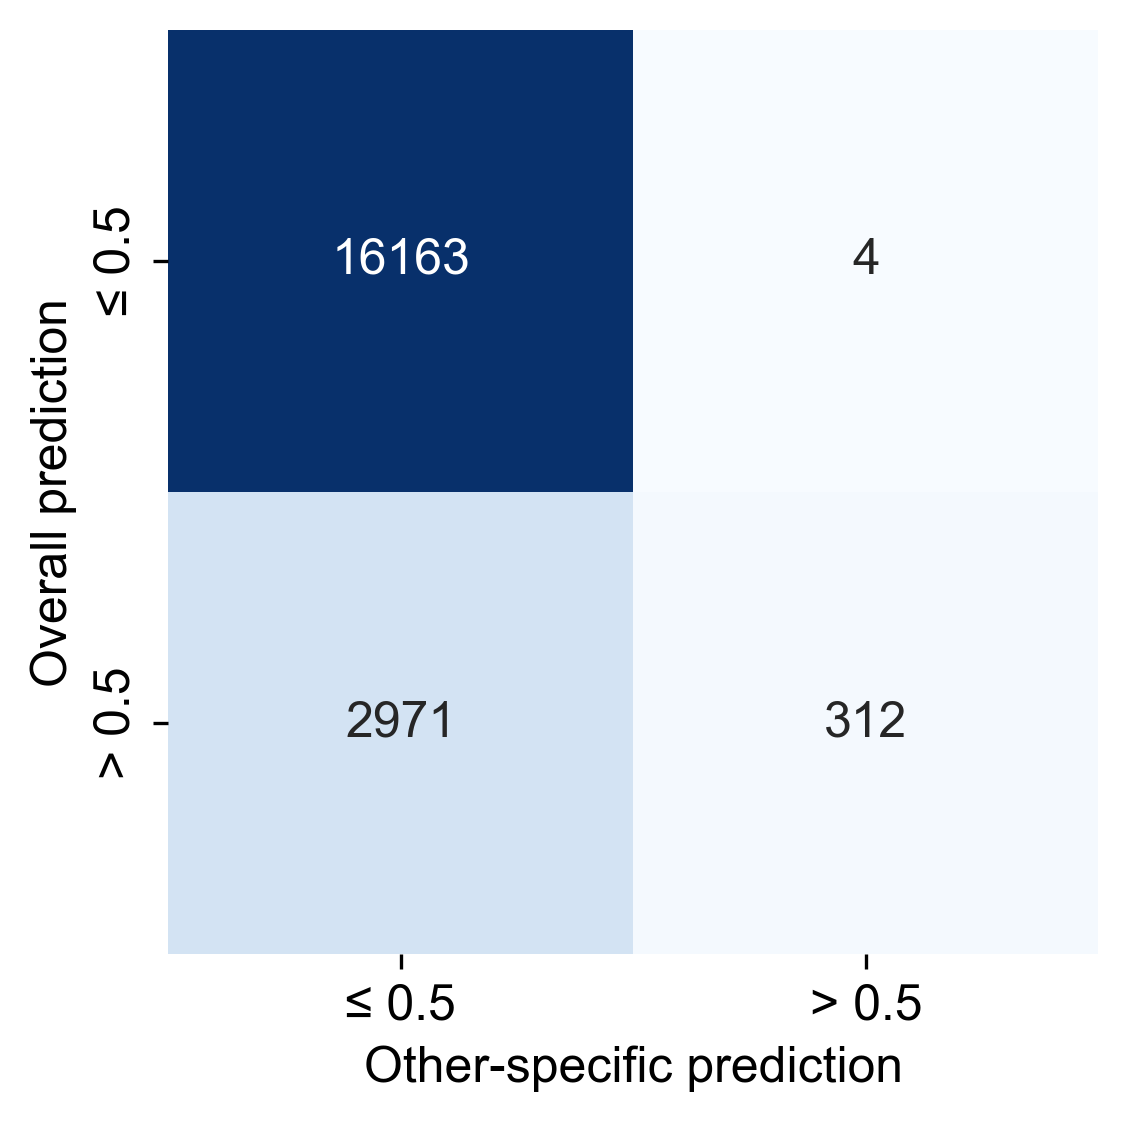

In [66]:
# Creating labels for the bins
drug['pred_druggable_bin'] = drug['pred_druggable'].apply(lambda x: "> 0.5" if x > 0.5 else "≤ 0.5")
drug['pred_neg_bin'] = drug['pred_other'].apply(lambda x: "> 0.5" if x > 0.5 else "≤ 0.5")

# Creating the contingency table with correct ordering
heatmap_data = drug.groupby(['pred_druggable_bin', 'pred_neg_bin']).size().unstack()
heatmap_data = heatmap_data.loc[["≤ 0.5", "> 0.5"], ["≤ 0.5", "> 0.5"]]  # Ensuring correct order

# Plotting the heatmap
plt.figure(figsize=(4,4), dpi=300)
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Other-specific prediction")
plt.ylabel("Overall prediction")
plt.show()


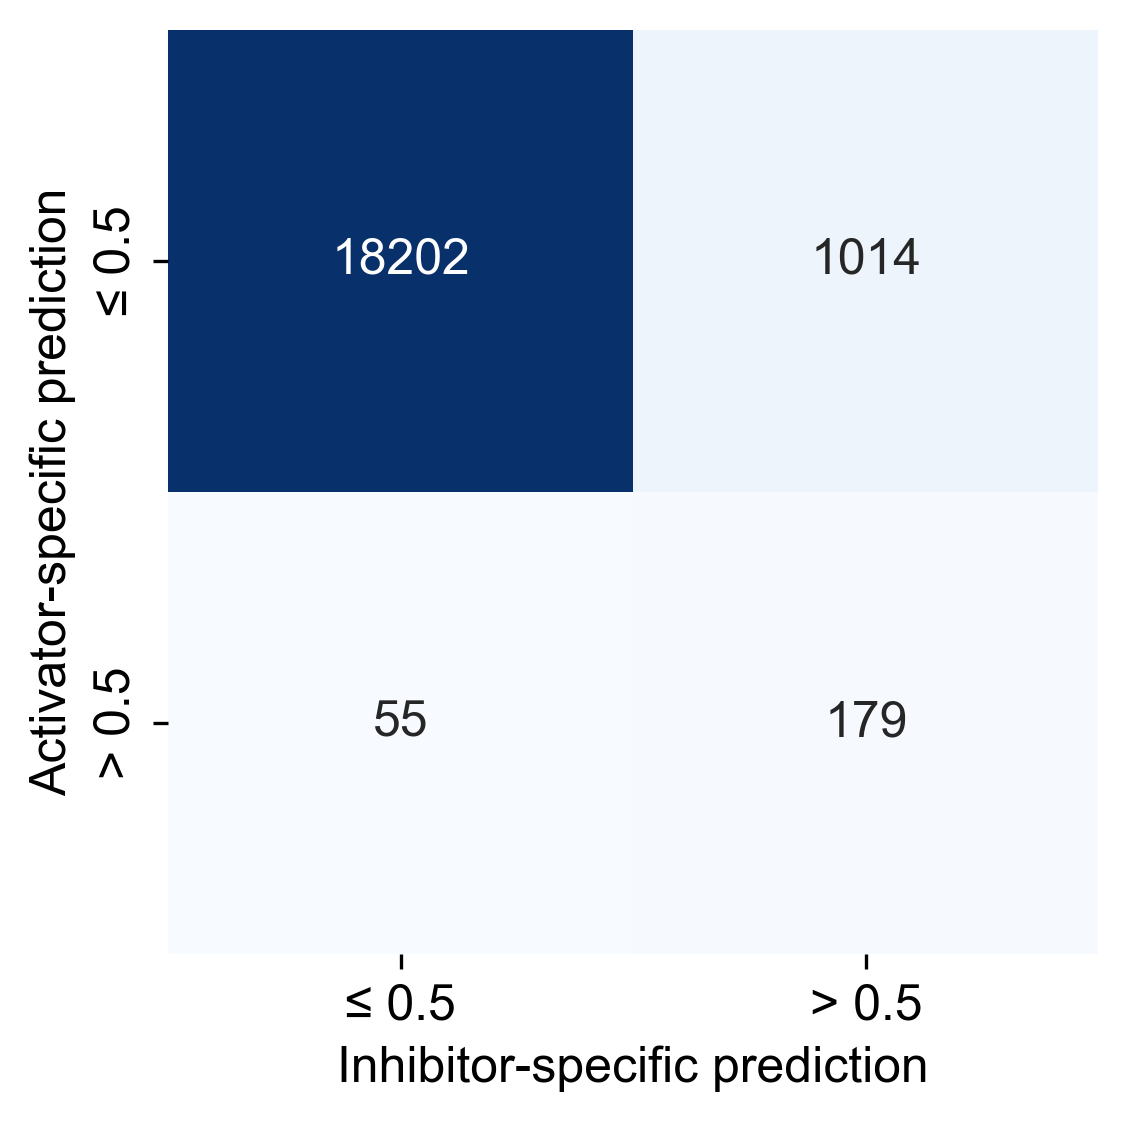

In [68]:
# Creating labels for the bins
drug['pred_druggable_bin'] = drug['pred_pos'].apply(lambda x: "> 0.5" if x > 0.5 else "≤ 0.5")
drug['pred_neg_bin'] = drug['pred_neg'].apply(lambda x: "> 0.5" if x > 0.5 else "≤ 0.5")

# Creating the contingency table with correct ordering
heatmap_data = drug.groupby(['pred_druggable_bin', 'pred_neg_bin']).size().unstack()
heatmap_data = heatmap_data.loc[["≤ 0.5", "> 0.5"], ["≤ 0.5", "> 0.5"]]  # Ensuring correct order

# Plotting the heatmap
plt.figure(figsize=(4,4), dpi=300)
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Inhibitor-specific prediction")
plt.ylabel("Activator-specific prediction")
plt.show()


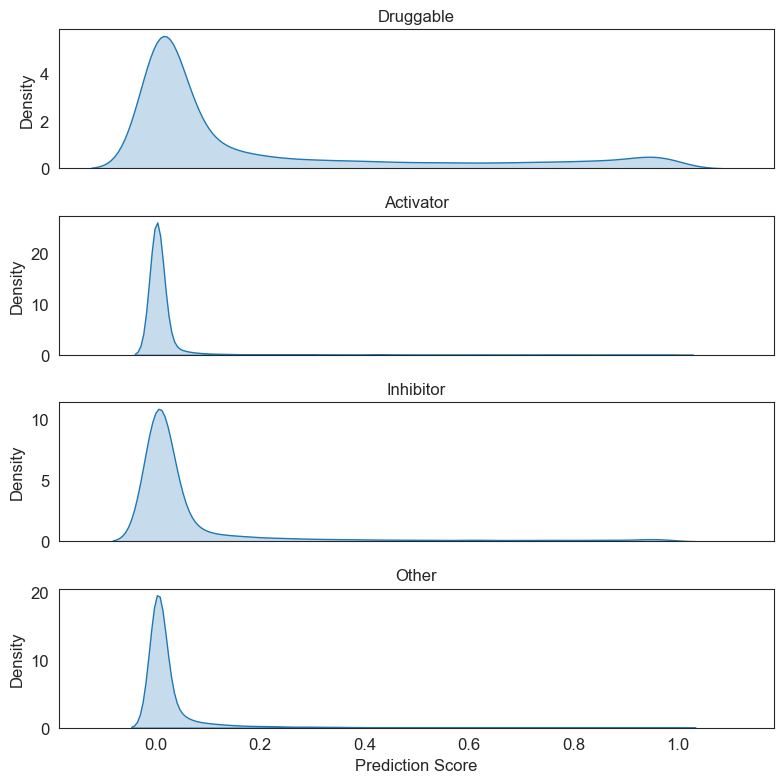

In [108]:
fig, axes = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

columns = ["pred_druggable", "pred_pos", "pred_neg", "pred_other"]
titles = ["Druggable", "Activator", "Inhibitor", "Other"]

for ax, col, title in zip(axes, columns, titles):
    sns.kdeplot(drug[col], ax=ax, fill=True)
    ax.set_title(title)

plt.xlabel("Prediction Score")
plt.tight_layout()
plt.show()


### Precision recall plots

In [ ]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos']]
pred = pd.read_csv(f'./Training/Predictions/druggability_doe_all_holdout_predictions.csv').merge(data)

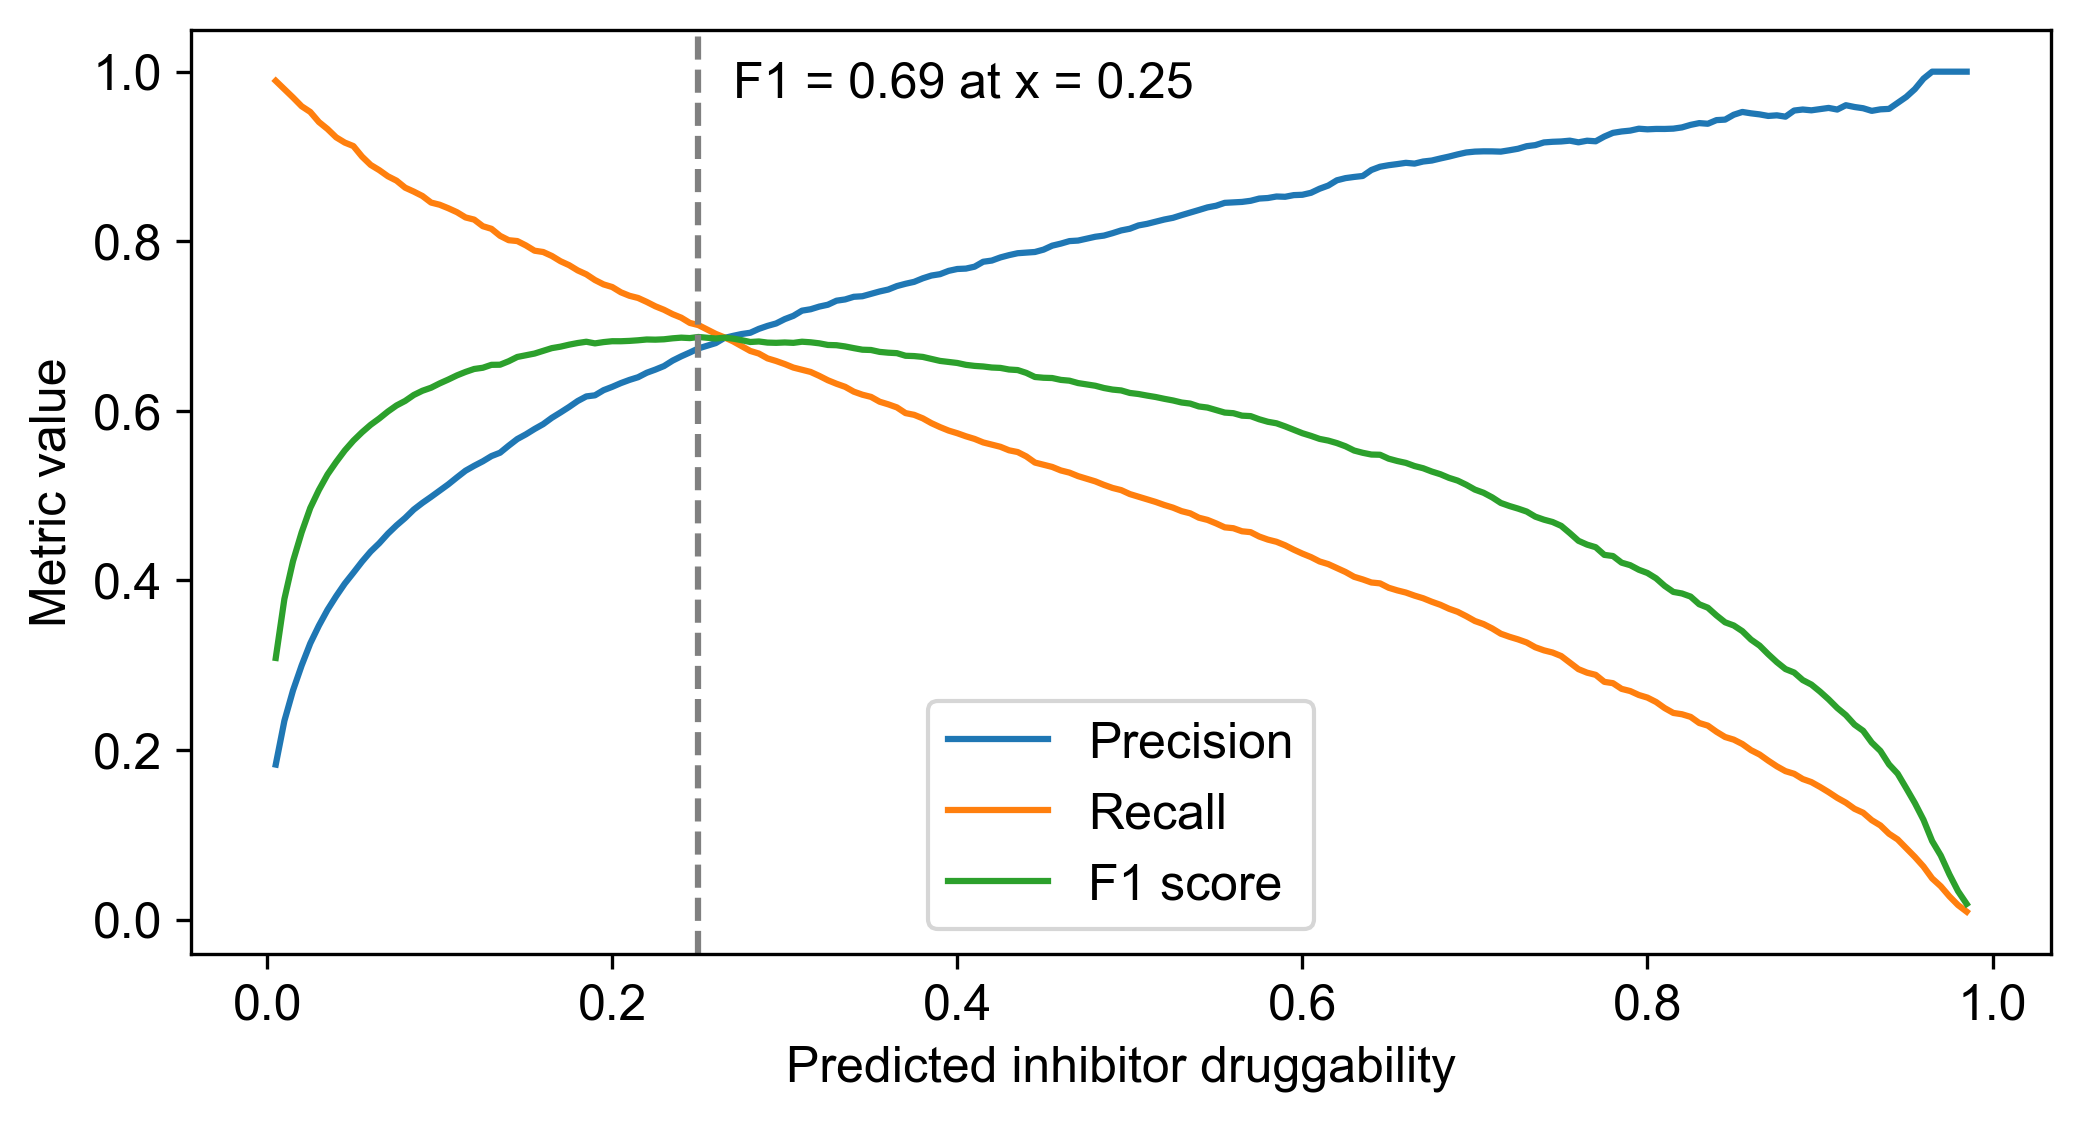

In [5]:
plt.figure(figsize=(8,4), dpi=300)
thresholds=np.arange(0,1.0001,0.005)
rows=[]
for t in thresholds:
    b=(pred['pred_neg']>=t).astype(int)
    if b.sum()>=5 and (len(b)-b.sum())>=5:
        p=precision_score(pred['neg'],b,zero_division=0)
        r=recall_score(pred['neg'],b,zero_division=0)
        f=f1_score(pred['neg'],b,zero_division=0)
        rows.extend([[t,'Precision',p],[t,'Recall',r],[t,'F1 score',f]])
df=pd.DataFrame(rows,columns=['threshold','metric','value'])
best_f1=df[df['metric']=='F1 score']
bt=best_f1.loc[best_f1['value'].idxmax(),'threshold'] if not best_f1.empty else None
sns.lineplot(x='threshold',y='value',hue='metric',data=df)
if bt is not None:
    plt.axvline(x=bt,linestyle='--',color='gray')
    max_f1=best_f1['value'].max()
    plt.annotate(f'F1 = {max_f1:.2f} at x = {bt:.2f}',xy=(bt+0.02,0.97))
plt.legend(title='')
plt.xlabel('Predicted inhibitor druggability')
plt.ylabel('Metric value')
plt.show()


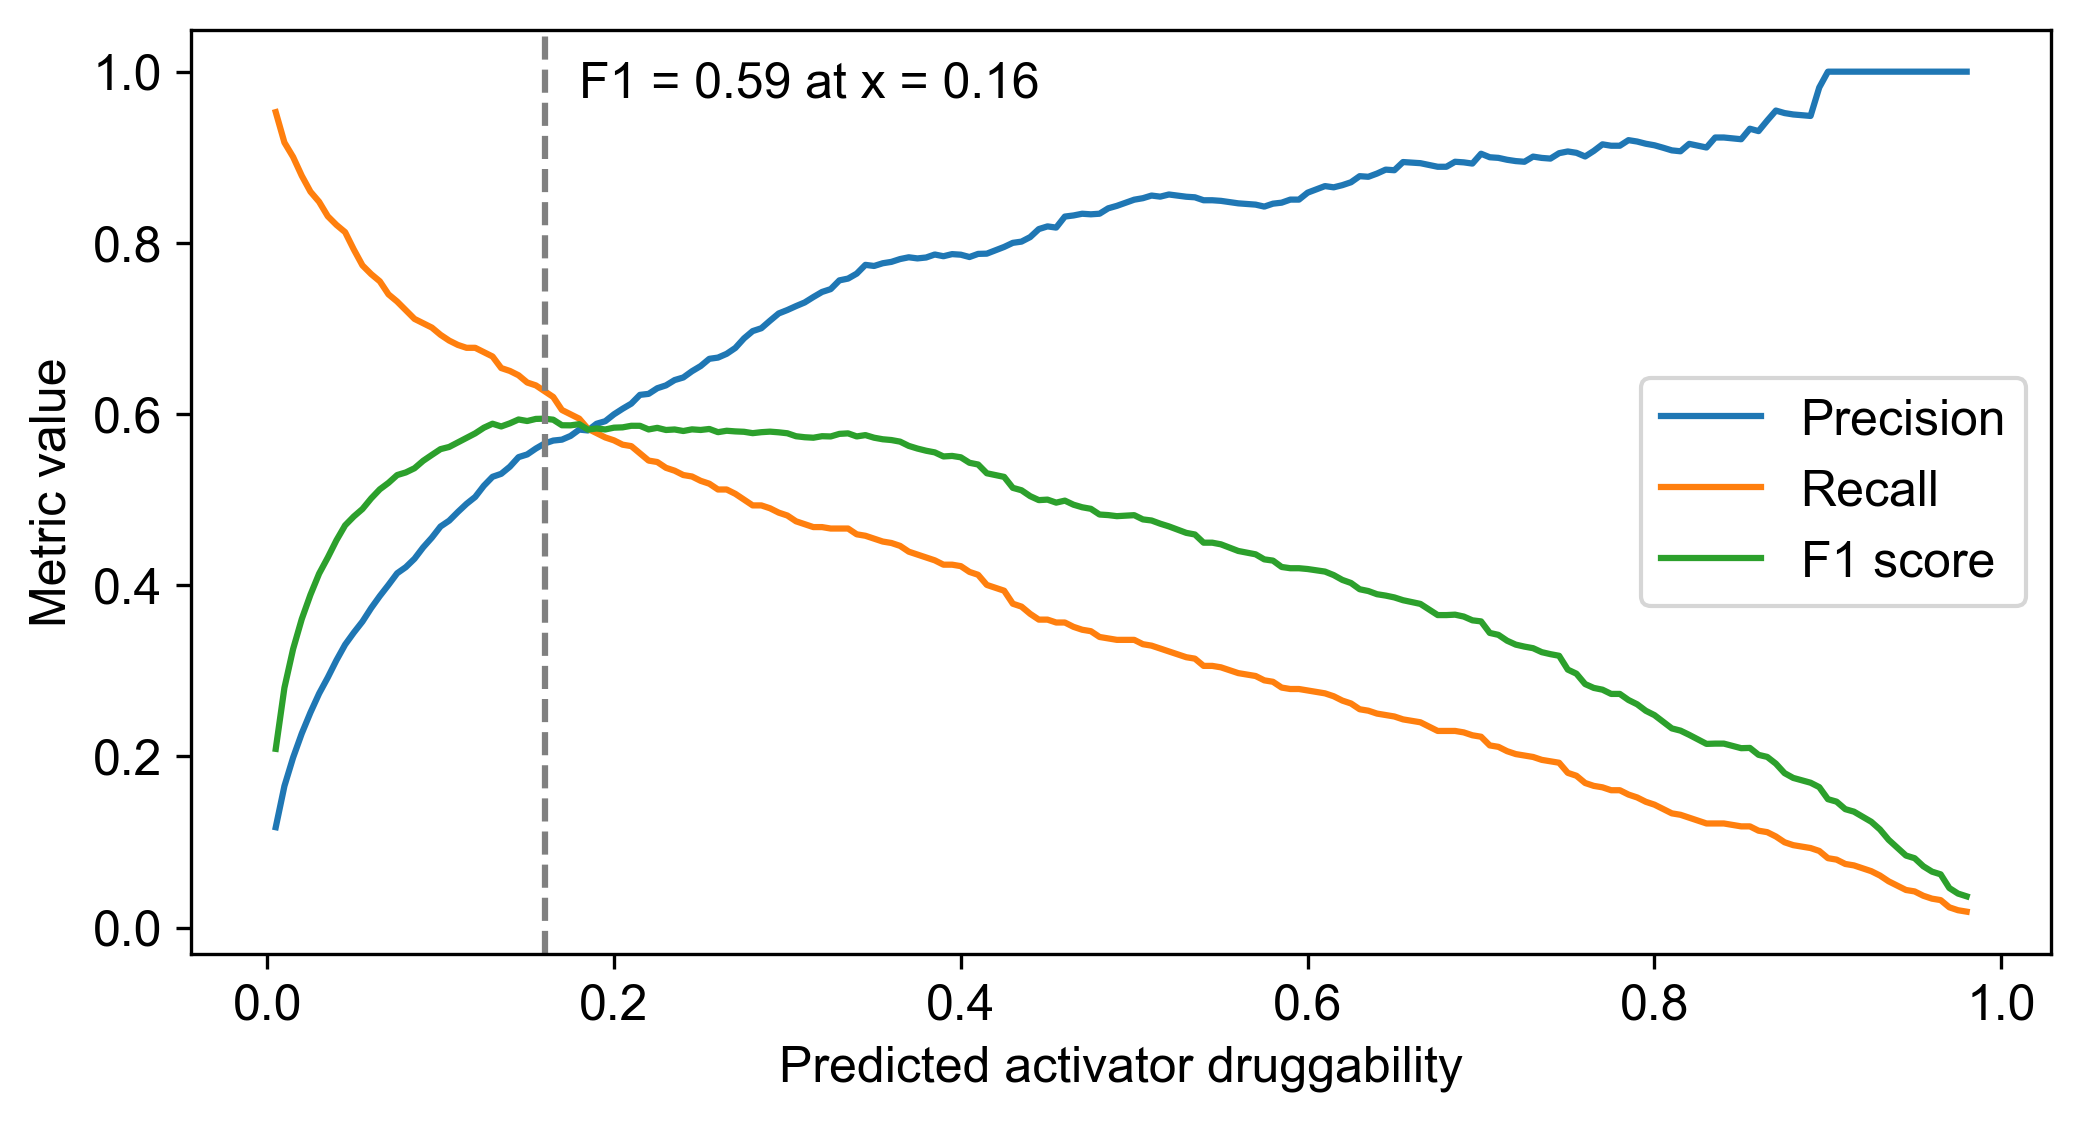

In [6]:
plt.figure(figsize=(8,4), dpi=300)
thresholds=np.arange(0,1.0001,0.005)
rows=[]
for t in thresholds:
    b=(pred['pred_pos']>=t).astype(int)
    if b.sum()>=5 and (len(b)-b.sum())>=5:
        p=precision_score(pred['pos'],b,zero_division=0)
        r=recall_score(pred['pos'],b,zero_division=0)
        f=f1_score(pred['pos'],b,zero_division=0)
        rows.extend([[t,'Precision',p],[t,'Recall',r],[t,'F1 score',f]])
df=pd.DataFrame(rows,columns=['threshold','metric','value'])
best_f1=df[df['metric']=='F1 score']
bt=best_f1.loc[best_f1['value'].idxmax(),'threshold'] if not best_f1.empty else None
sns.lineplot(x='threshold',y='value',hue='metric',data=df)
if bt is not None:
    plt.axvline(x=bt,linestyle='--',color='gray')
    max_f1=best_f1['value'].max()
    plt.annotate(f'F1 = {max_f1:.2f} at x = {bt:.2f}',xy=(bt+0.02,0.97))
plt.legend(title='')
plt.xlabel('Predicted activator druggability')
plt.ylabel('Metric value')
plt.show()


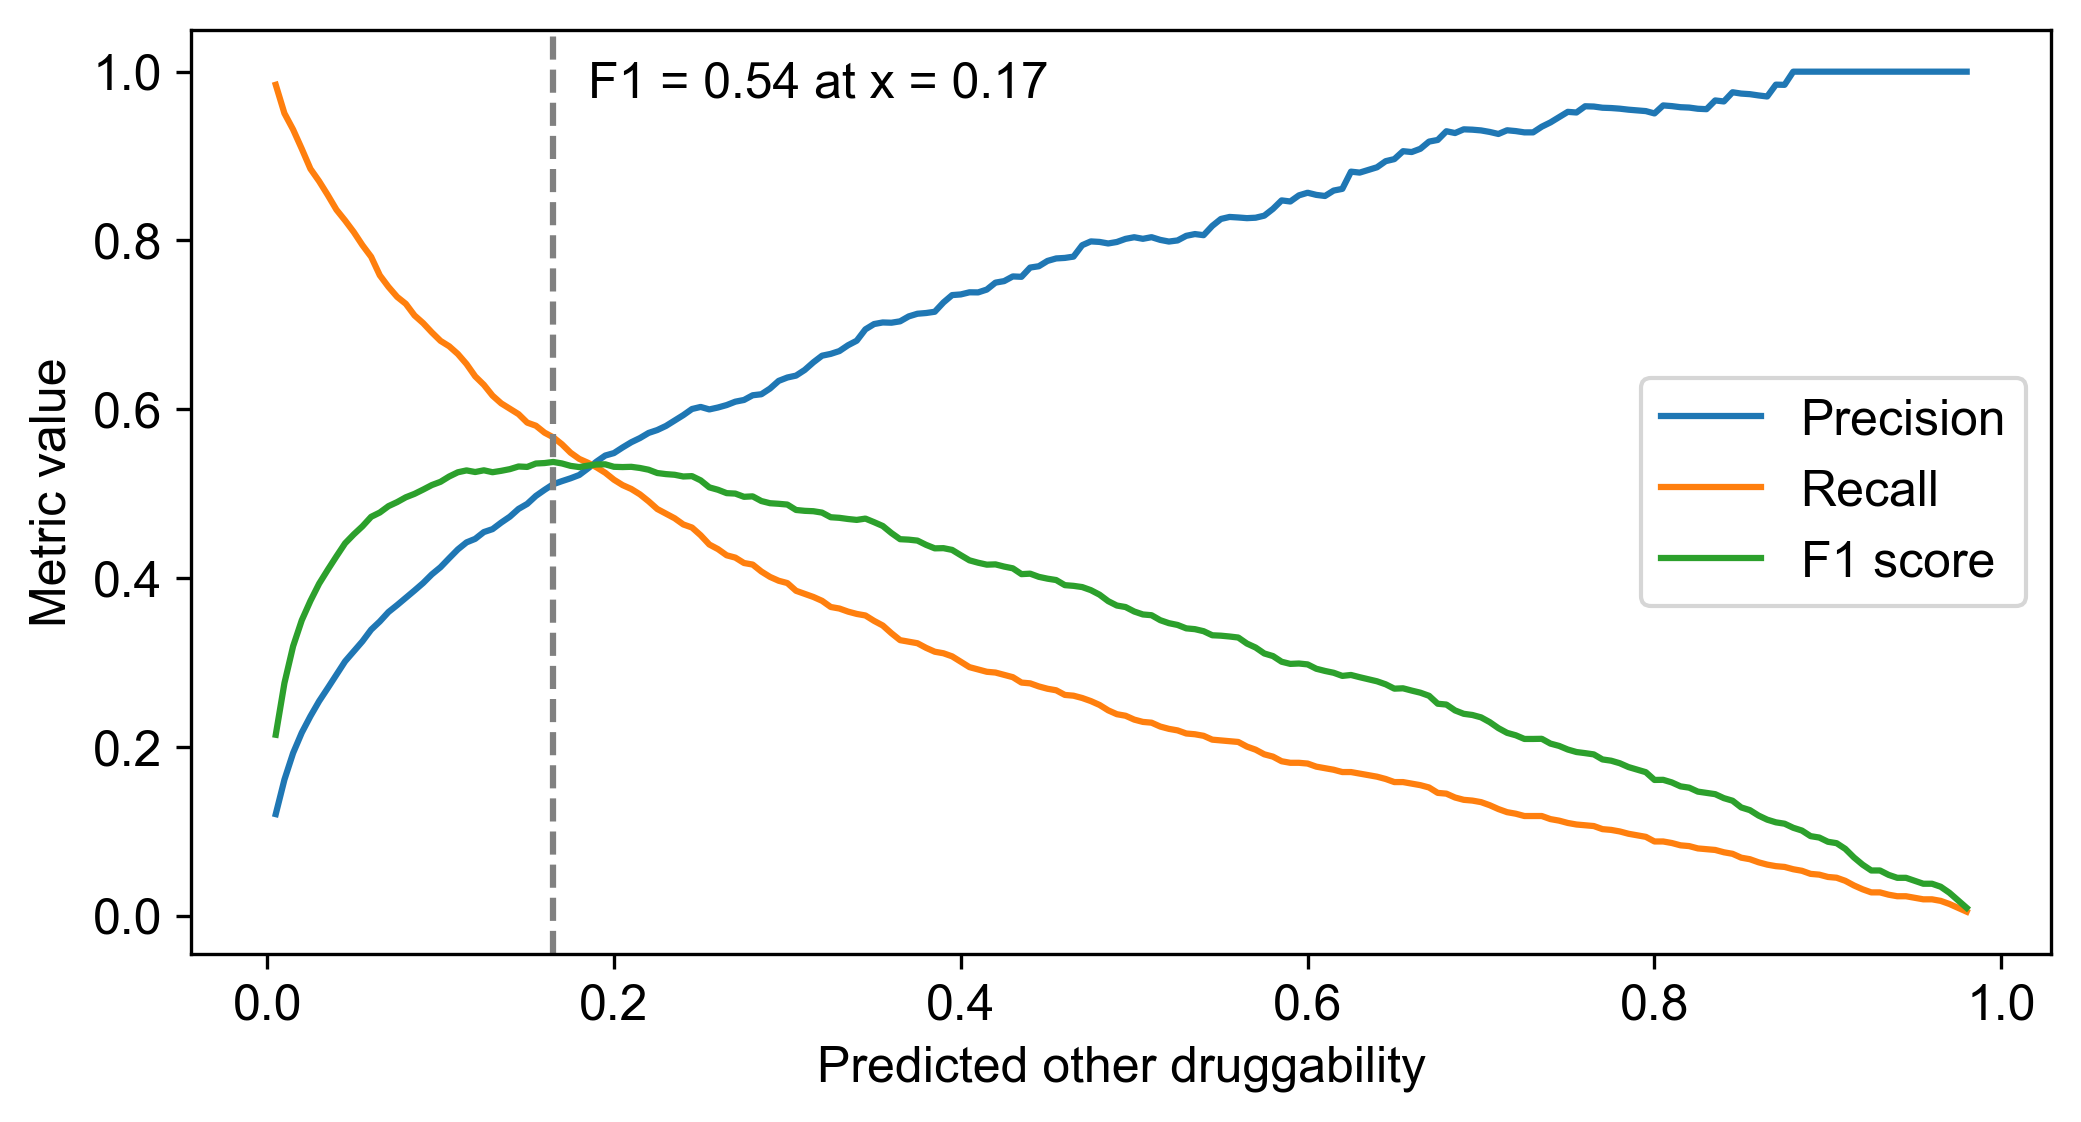

In [7]:
plt.figure(figsize=(8,4), dpi=300)
thresholds=np.arange(0,1.0001,0.005)
rows=[]
for t in thresholds:
    b=(pred['pred_other']>=t).astype(int)
    if b.sum()>=5 and (len(b)-b.sum())>=5:
        p=precision_score(pred['other'],b,zero_division=0)
        r=recall_score(pred['other'],b,zero_division=0)
        f=f1_score(pred['other'],b,zero_division=0)
        rows.extend([[t,'Precision',p],[t,'Recall',r],[t,'F1 score',f]])
df=pd.DataFrame(rows,columns=['threshold','metric','value'])
best_f1=df[df['metric']=='F1 score']
bt=best_f1.loc[best_f1['value'].idxmax(),'threshold'] if not best_f1.empty else None
sns.lineplot(x='threshold',y='value',hue='metric',data=df)
if bt is not None:
    plt.axvline(x=bt,linestyle='--',color='gray')
    max_f1=best_f1['value'].max()
    plt.annotate(f'F1 = {max_f1:.2f} at x = {bt:.2f}',xy=(bt+0.02,0.97))
plt.legend(title='')
plt.xlabel('Predicted other druggability')
plt.ylabel('Metric value')
plt.show()


### Calculating metrics

In [31]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos']]

model_names = ['all','gene_embed','prot_embed','all_embed','genetics','drugnomeai']
metrics = pd.DataFrame()

def bootstrap_all_metrics(y_true,y_score,n_boot):
    np.random.seed(42)
    out={f'auroc_{c}':[] for c in ['neg','other','pos']}
    out.update({f'auprc_{c}':[] for c in ['neg','other','pos']})
    out.update({f'brier_{c}':[] for c in ['neg','other','pos']})
    for x in ['auroc_micro','auroc_macro','auprc_micro','auprc_macro','hamming','brier_micro','brier_macro']:
        out[x]=[]
    for _ in range(n_boot):
        idx=np.random.randint(0,len(y_true),len(y_true))
        yt,ys=y_true[idx],y_score[idx]
        for i,c in enumerate(['neg','other','pos']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:,i],ys[:,i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:,i],ys[:,i]))
            out[f'brier_{c}'].append(np.mean((ys[:,i] - yt[:,i])**2))
        out['auroc_micro'].append(roc_auc_score(yt,ys,average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt,ys,average='macro'))
        out['auprc_micro'].append(average_precision_score(yt,ys,average='micro'))
        out['auprc_macro'].append(average_precision_score(yt,ys,average='macro'))
        out['hamming'].append(hamming_loss(yt,(ys>=0.5).astype(int)))
        out['brier_micro'].append(np.mean((ys - yt)**2))
        out['brier_macro'].append(np.mean([(ys[:,i] - yt[:,i])**2 for i in range(yt.shape[1])]))

    return {k:(np.mean(v),np.percentile(v,2.5),np.percentile(v,97.5)) for k,v in out.items()}

for i in model_names:
    if i == 'drugnomeai':
        res=pd.read_csv('./Other/drugnomeai.csv').rename({'Gene Name':'ID'},axis=1).merge(data)
        res['pred_neg']=res['Tclin & Tchem'].copy()
        res['pred_other']=res['Tclin & Tchem'].copy()
        res['pred_pos']=res['Tclin & Tchem'].copy()
    else:
        res=pd.read_csv(f'./Training/Predictions/druggability_doe_{i}_holdout_predictions.csv').merge(data)
    y_true=res[['neg','other','pos']].values
    y_score=res[['pred_neg','pred_other','pred_pos']].values
    boot=bootstrap_all_metrics(y_true,y_score,500)
    new_records=[]
    for k,(m,l,h) in boot.items():
        new_records.append({'model':i,'metric':k,'mean':m,'ci_low':l,'ci_high':h})
    metrics=pd.concat([metrics,pd.DataFrame(new_records)],ignore_index=True)

metrics.to_pickle('./Training/Metrics/druggability_doe.pkl')


In [7]:
metrics = pd.read_pickle('./Training/Metrics/druggability_doe.pkl')
metrics['model'] = metrics['model'].map({'all':'All features',
                                         'gene_embed':'Gene embeddings',
                                         'prot_embed':'Protein embeddings',
                                         'all_embed':'All embeddings',
                                         'genetics':'Tabular features',
                                         'drugnomeai':'DrugnomeAI'})
metrics['model'] = pd.Categorical(metrics['model'], ['Tabular features','Gene embeddings','Protein embeddings',
                                                     'All embeddings','All features','DrugnomeAI'])

data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)
n_ids = data['ID'].nunique()
n_neg = int(data['neg'].sum())
n_other = int(data['other'].sum())
n_pos = int(data['pos'].sum())


In [10]:
table = metrics.copy()
table.loc[table['metric'].str.contains('neg'), 'outcome'] = 'Inhibitor'
table.loc[table['metric'].str.contains('other'), 'outcome'] = 'Other'
table.loc[table['metric'].str.contains('pos'), 'outcome'] = 'Activator'
table.loc[table['metric'].str.contains('macro'), 'outcome'] = 'Macro-average'
table.loc[table['metric'].str.contains('micro'), 'outcome'] = 'Micro-average'
table.loc[table['metric'].str.contains('auroc'), 'metric'] = 'AUROC'
table.loc[table['metric'].str.contains('auprc'), 'metric'] = 'AUPRC'
table.loc[table['metric'].str.contains('brier'), 'metric'] = 'Brier score'
table = table.dropna()
table['outcome'] = pd.Categorical(table['outcome'], ['Activator','Inhibitor','Other','Macro-average','Micro-average'])

table['value'] = table['mean'].round(3).astype(str) + ' (' + table['ci_low'].round(3).astype(str) + '-' + table['ci_high'].round(3).astype(str) + ')'
table = pd.pivot_table(table, index=['outcome','model'], columns='metric', values='value', aggfunc='first').reset_index()
table = table[['outcome','model','AUROC','AUPRC','Brier score']]
table


metric        outcome               model                AUROC  \
0           Activator    Tabular features  0.922 (0.912-0.933)   
1           Activator     Gene embeddings  0.929 (0.917-0.941)   
2           Activator  Protein embeddings  0.902 (0.887-0.916)   
3           Activator      All embeddings  0.942 (0.933-0.953)   
4           Activator        All features  0.957 (0.949-0.965)   
5           Activator          DrugnomeAI  0.933 (0.925-0.941)   
6           Inhibitor    Tabular features  0.913 (0.906-0.919)   
7           Inhibitor     Gene embeddings  0.918 (0.911-0.924)   
8           Inhibitor  Protein embeddings  0.899 (0.891-0.906)   
9           Inhibitor      All embeddings  0.938 (0.932-0.943)   
10          Inhibitor        All features  0.952 (0.947-0.956)   
11          Inhibitor          DrugnomeAI  0.929 (0.922-0.936)   
12              Other    Tabular features  0.884 (0.875-0.894)   
13              Other     Gene embeddings  0.884 (0.874-0.895)   
14              Other  Protein embeddings  0.886 (0.875-0.896)   
15              Other      All embeddings  0.913 (0.905-0.921)   
16              Other        All features   0.934 (0.927-0.94)   
17              Other          DrugnomeAI  0.824 (0.812-0.837)   
18      Macro-average    Tabular features    0.906 (0.9-0.912)   
19      Macro-average     Gene embeddings   0.91 (0.904-0.917)   
20      Macro-average  Protein embeddings  0.895 (0.888-0.902)   
21      Macro-average      All embeddings  0.931 (0.926-0.936)   
22      Macro-average        All features  0.948 (0.944-0.951)   
23      Macro-average          DrugnomeAI  0.895 (0.889-0.902)   
24      Micro-average    Tabular features  0.914 (0.909-0.919)   
25      Micro-average     Gene embeddings  0.918 (0.913-0.924)   
26      Micro-average  Protein embeddings    0.906 (0.9-0.911)   
27      Micro-average      All embeddings  0.937 (0.933-0.941)   
28      Micro-average        All features  0.952 (0.948-0.955)   
29      Micro-average          DrugnomeAI  0.891 (0.885-0.899)   

metric                AUPRC          Brier score  
0       0.389 (0.348-0.435)  0.023 (0.021-0.024)  
1        0.56 (0.517-0.598)  0.019 (0.018-0.021)  
2       0.519 (0.478-0.558)   0.02 (0.019-0.022)  
3       0.609 (0.569-0.648)   0.018 (0.017-0.02)  
4        0.63 (0.589-0.668)  0.018 (0.016-0.019)  
5       0.315 (0.283-0.347)  0.107 (0.104-0.111)  
6        0.604 (0.58-0.626)   0.058 (0.056-0.06)  
7       0.655 (0.632-0.676)  0.055 (0.052-0.057)  
8       0.632 (0.609-0.653)   0.057 (0.055-0.06)  
9       0.725 (0.704-0.744)  0.049 (0.047-0.052)  
10      0.755 (0.735-0.772)  0.045 (0.043-0.047)  
11      0.687 (0.664-0.711)  0.072 (0.069-0.075)  
12      0.399 (0.368-0.429)   0.042 (0.04-0.044)  
13      0.449 (0.418-0.477)  0.041 (0.038-0.043)  
14      0.477 (0.445-0.513)  0.039 (0.037-0.042)  
15      0.541 (0.509-0.572)   0.038 (0.035-0.04)  
16          0.57 (0.54-0.6)  0.036 (0.034-0.038)  
17      0.237 (0.216-0.258)  0.118 (0.114-0.123)  
18      0.464 (0.441-0.486)  0.041 (0.039-0.042)  
19      0.554 (0.532-0.576)   0.038 (0.037-0.04)  
20       0.543 (0.52-0.566)   0.039 (0.037-0.04)  
21      0.625 (0.603-0.645)  0.035 (0.034-0.037)  
22      0.652 (0.631-0.671)  0.033 (0.032-0.034)  
23      0.413 (0.396-0.432)  0.099 (0.097-0.103)  
24      0.513 (0.493-0.531)  0.041 (0.039-0.042)  
25      0.582 (0.562-0.602)   0.038 (0.037-0.04)  
26        0.57 (0.548-0.59)   0.039 (0.037-0.04)  
27      0.654 (0.636-0.672)  0.035 (0.034-0.037)  
28      0.683 (0.665-0.699)  0.033 (0.032-0.034)  
29      0.399 (0.382-0.418)  0.099 (0.097-0.103)

Text(0, 0.5, 'AUROC')

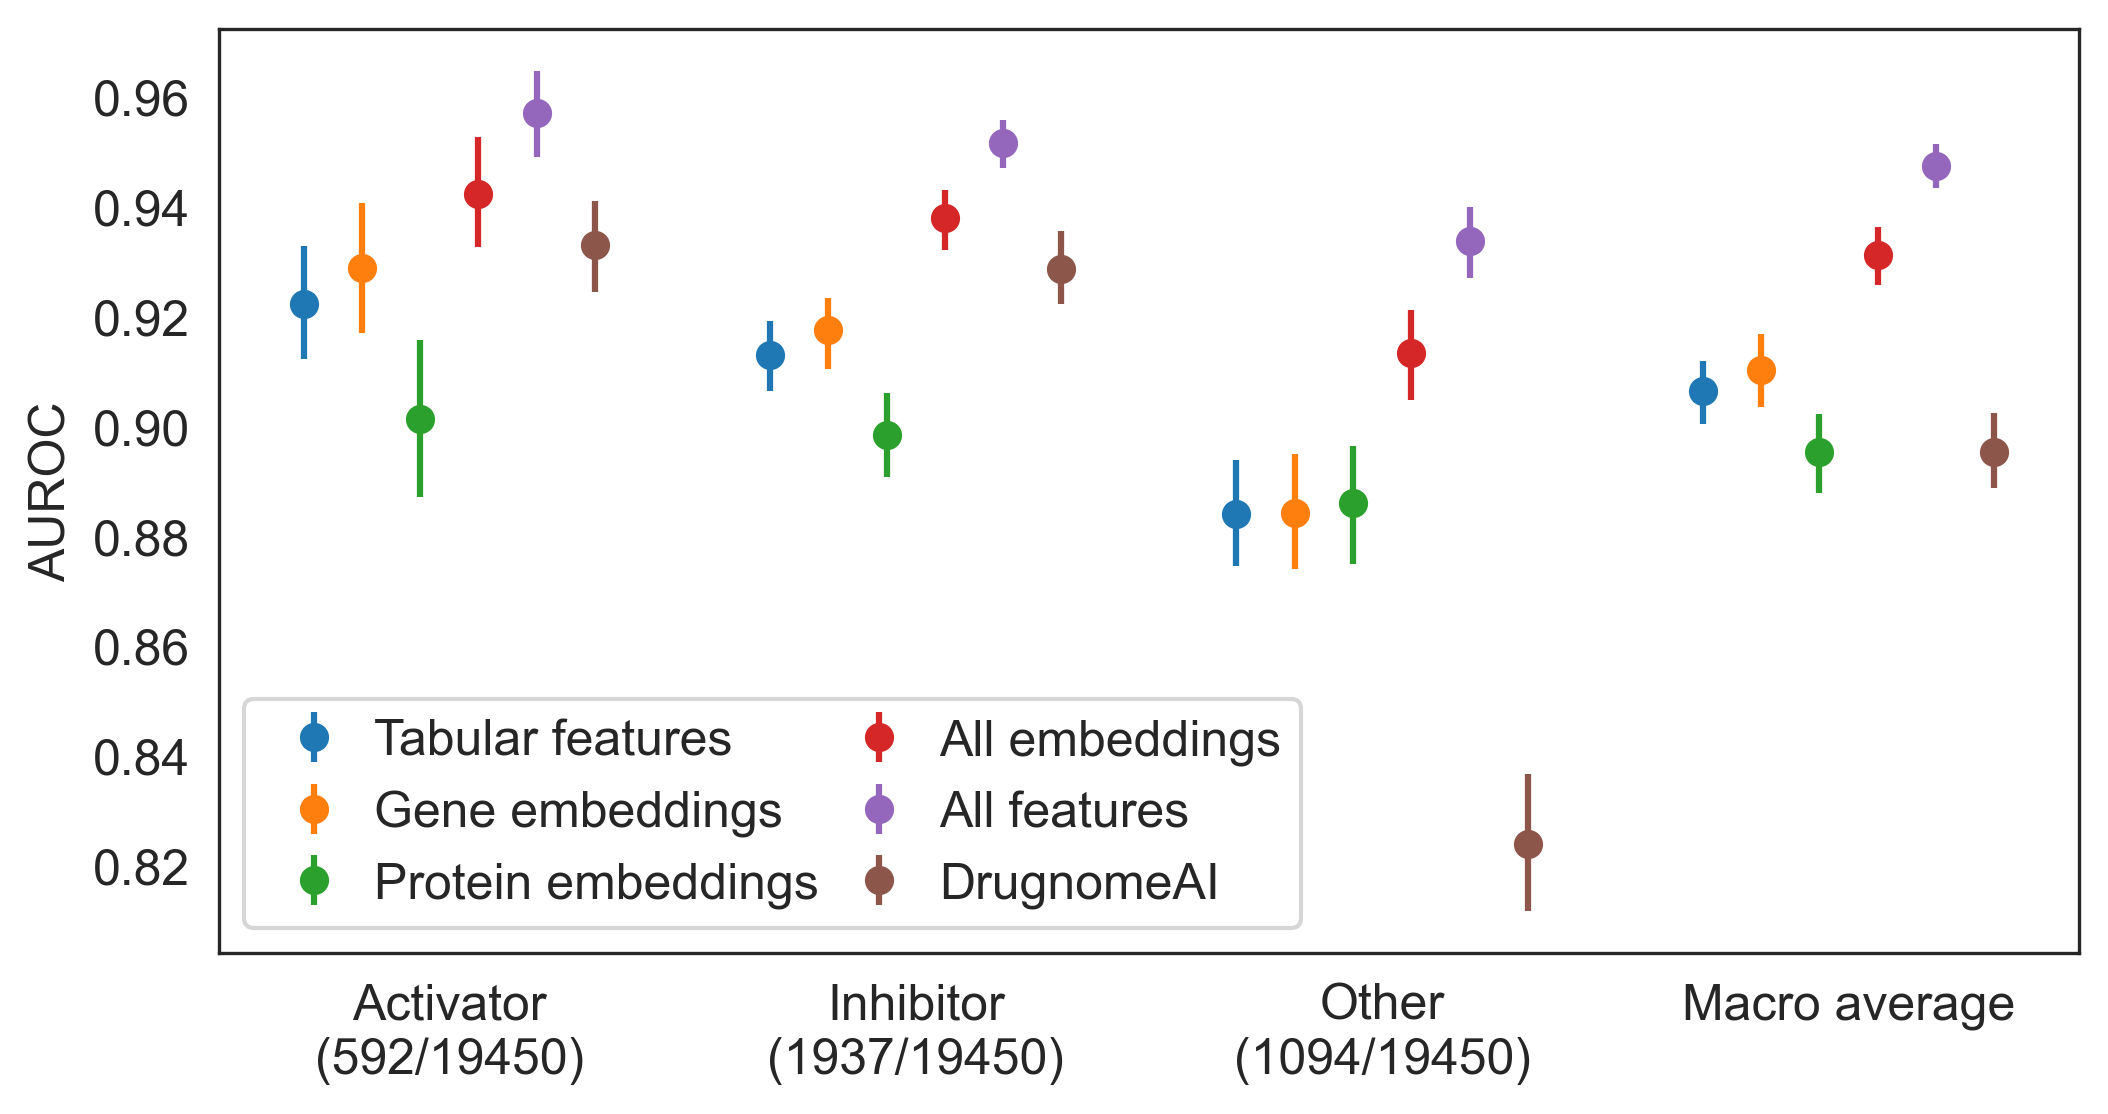

In [163]:
res = metrics.copy()
res = res.loc[~res['metric'].str.contains('micro')]
res = res.loc[res['metric'].str.contains('auroc')]
res['metric'] = res['metric'].map({'auroc_neg':f'Inhibitor\n({n_neg}/{n_ids})',
                                   'auroc_other':f'Other\n({n_other}/{n_ids})',
                                   'auroc_pos':f'Activator\n({n_pos}/{n_ids})',
                                   'auroc_macro':'Macro average'})
res['metric'] = pd.Categorical(res['metric'], [f'Activator\n({n_pos}/{n_ids})',
                                               f'Inhibitor\n({n_neg}/{n_ids})',
                                               f'Other\n({n_other}/{n_ids})',
                                               'Macro average'])
res = res.sort_values(['model','metric'])

sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['model'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['metric'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['model'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['metric'].unique())))
ax.set_xticklabels(res['metric'].unique())
ax.legend(title='', ncols=2, loc='lower left', columnspacing=0.2, handletextpad=0.2)

#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
#plt.ylim([0.875,0.975])
plt.xlabel('')
plt.ylabel('AUROC')


Text(0, 0.5, 'AUPRC')

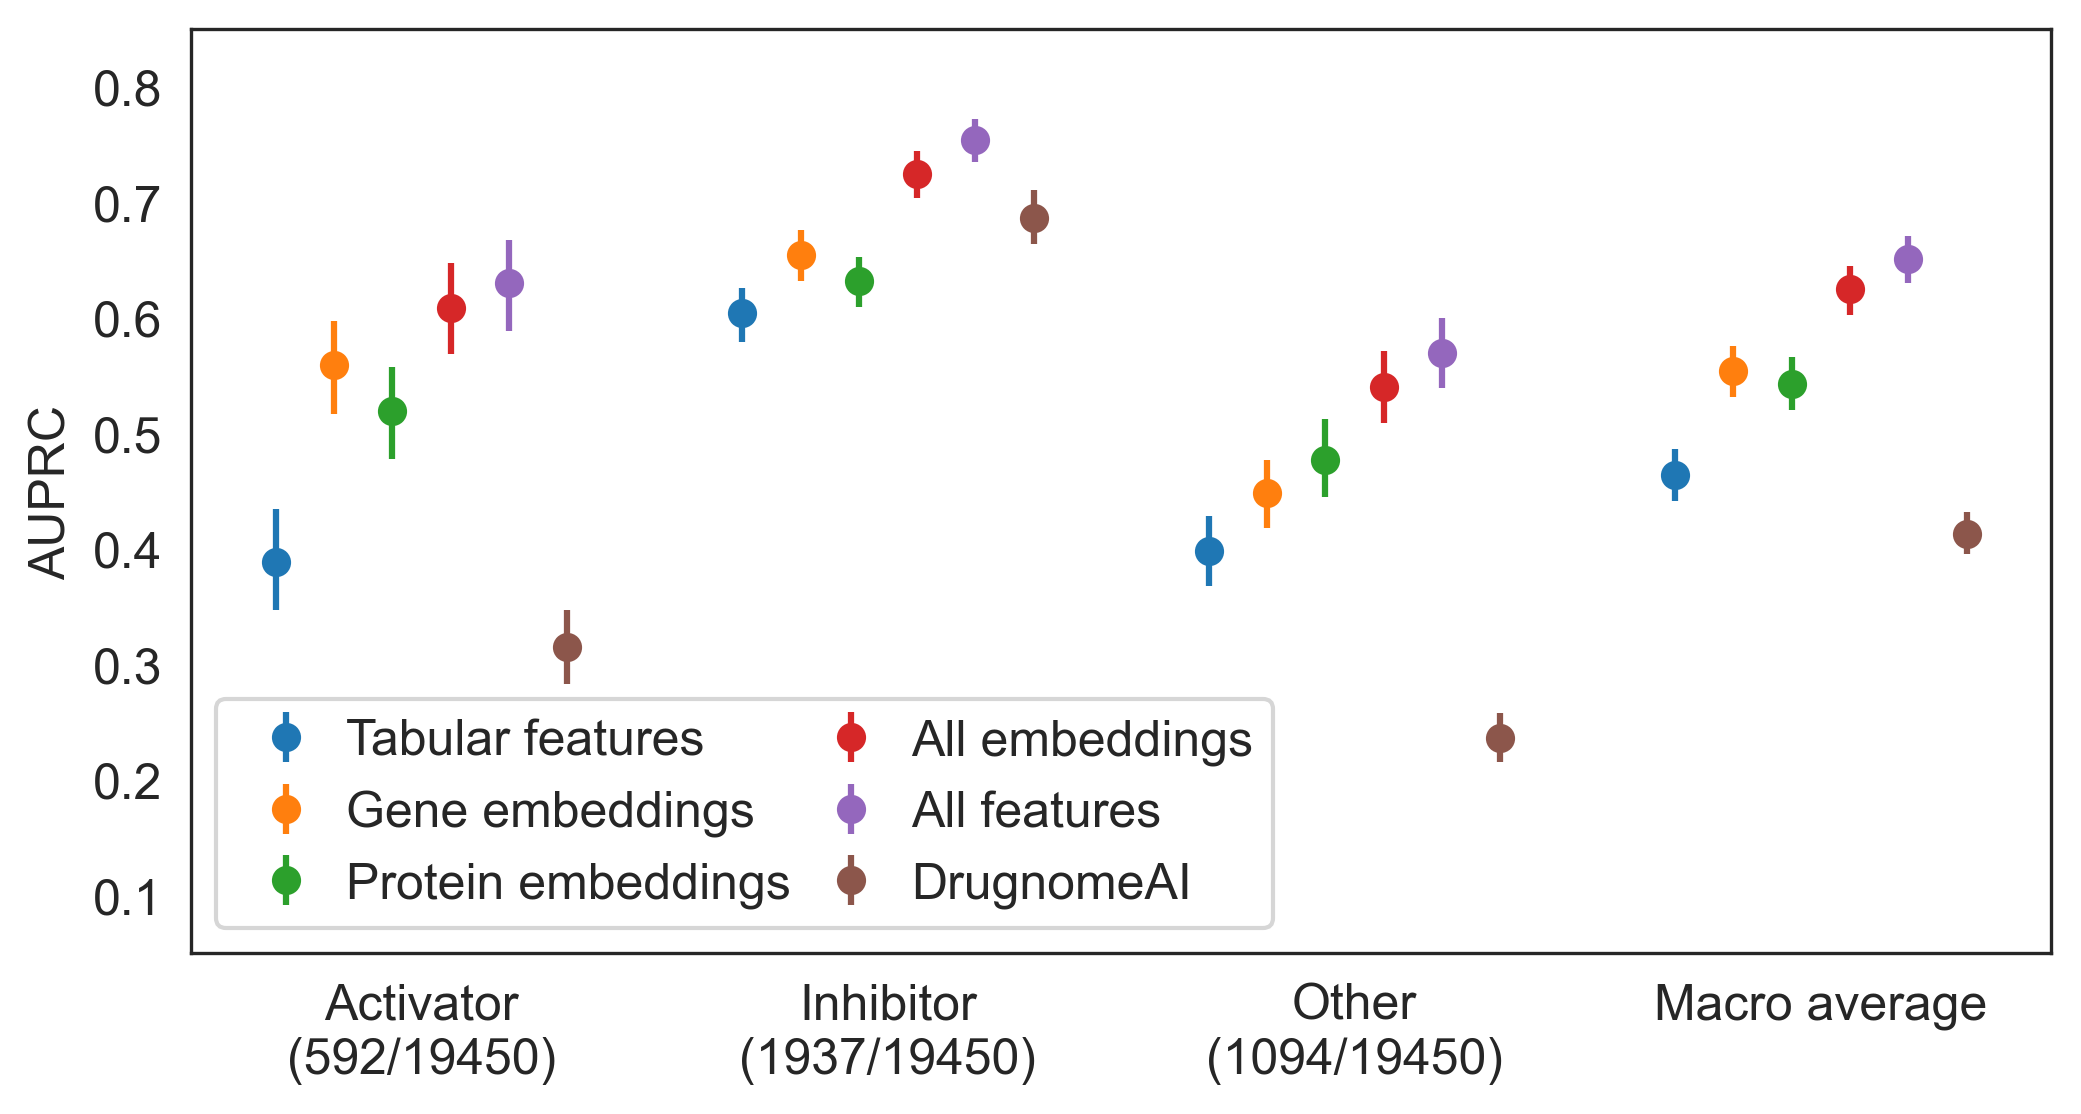

In [164]:
res = metrics.copy()
res = res.loc[~res['metric'].str.contains('micro')]
res = res.loc[res['metric'].str.contains('auprc')]
res['metric'] = res['metric'].map({'auprc_neg':f'Inhibitor\n({n_neg}/{n_ids})',
                                   'auprc_other':f'Other\n({n_other}/{n_ids})',
                                   'auprc_pos':f'Activator\n({n_pos}/{n_ids})',
                                   'auprc_macro':'Macro average'})
res['metric'] = pd.Categorical(res['metric'], [f'Activator\n({n_pos}/{n_ids})',
                                               f'Inhibitor\n({n_neg}/{n_ids})',
                                               f'Other\n({n_other}/{n_ids})',
                                               'Macro average'])
res = res.sort_values(['model','metric'])

sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['model'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['metric'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['model'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['metric'].unique())))
ax.set_xticklabels(res['metric'].unique())
ax.legend(title='', ncols=2, loc='lower left', columnspacing=0.2, handletextpad=0.2)

#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
plt.ylim([0.05,0.85])
plt.xlabel('')
plt.ylabel('AUPRC')


Text(0, 0.5, 'True proportion')

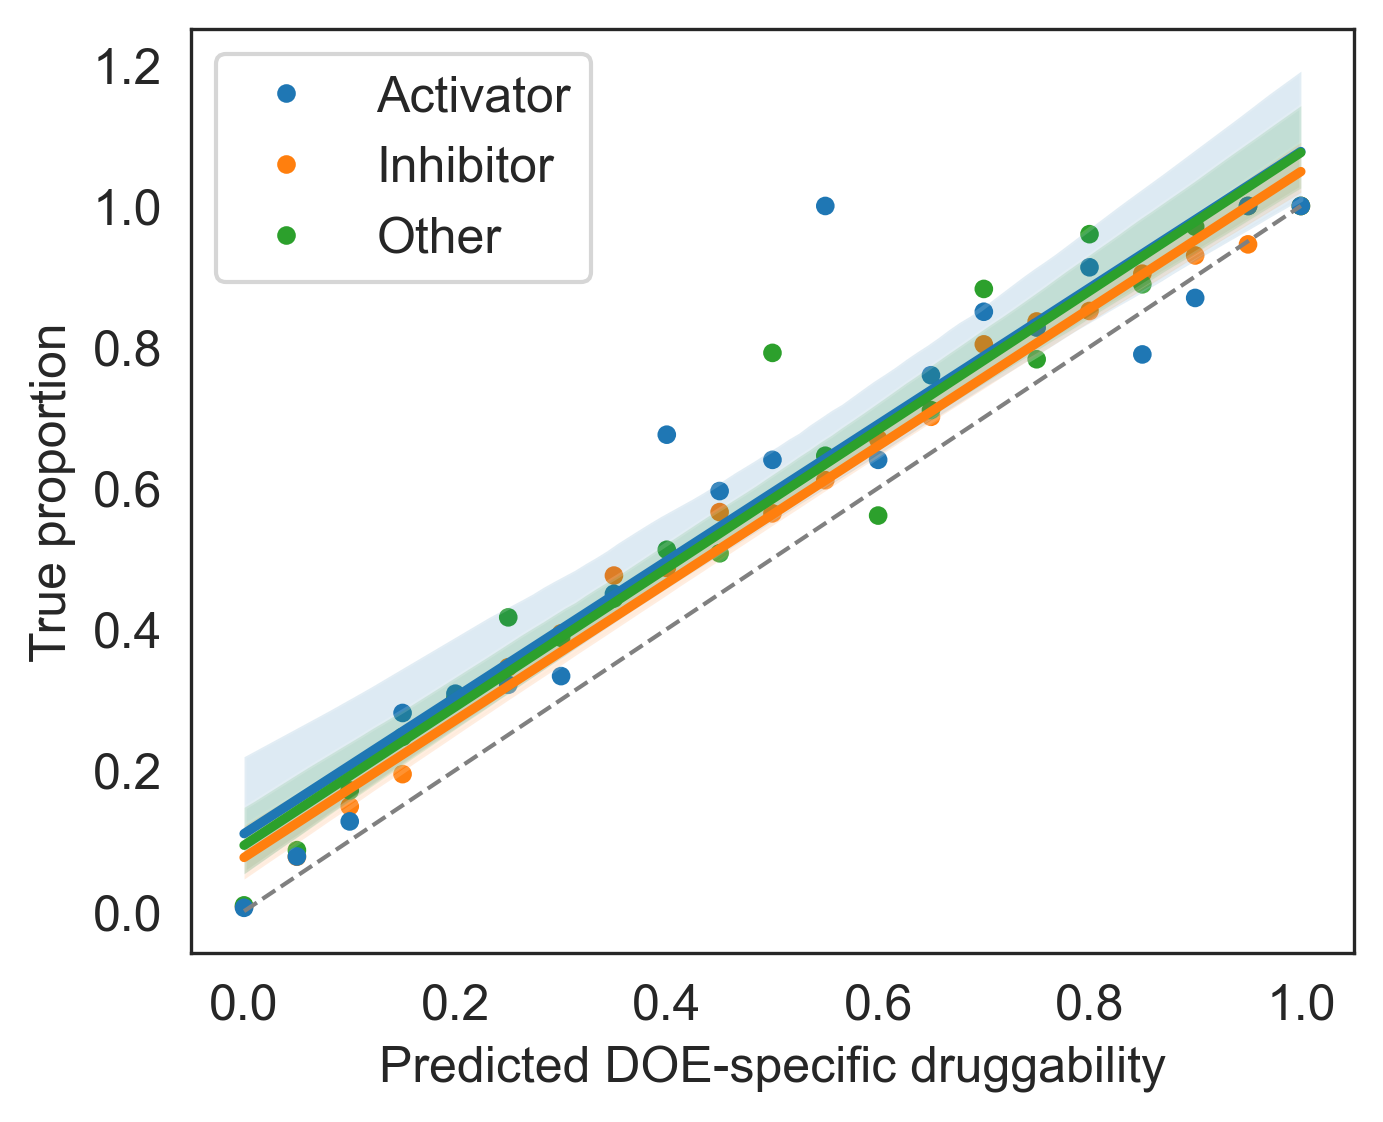

In [4]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos']]
data=pd.read_csv(f'./Training/Predictions/druggability_doe_all_holdout_predictions.csv').merge(data)

melt_data = pd.DataFrame({
    "pred": data["pred_neg"].apply(round_to_005).tolist() + 
            data["pred_pos"].apply(round_to_005).tolist() + 
            data["pred_other"].apply(round_to_005).tolist(),
    "true": data["neg"].tolist() + 
            data["pos"].tolist() + 
            data["other"].tolist(),
    "hue": ["neg"] * len(data) + ["pos"] * len(data) + ["other"] * len(data)
})

calibration_data = melt_data.groupby(["pred", "hue"]).agg(
    proportion_true=("true", "mean"),
    count=("true", "size")).reset_index()
calibration_data = calibration_data[calibration_data["count"] >= 10]
calibration_data['hue'] = calibration_data['hue'].map({'other':'Other','pos':'Activator','neg':'Inhibitor'})
calibration_data['hue'] = pd.Categorical(calibration_data['hue'], ['Activator','Inhibitor','Other'])

sns.set_style('white')
plt.figure(figsize=(5,4), dpi=300)

sns.scatterplot(data=calibration_data,x='pred',y='proportion_true',hue='hue',edgecolor='none',s=20)
for h,c in zip(['Activator','Inhibitor','Other'],sns.color_palette()[:3]):
    subset=calibration_data[calibration_data['hue']==h]
    sns.regplot(data=subset,x='pred',y='proportion_true',scatter=False,color=c,label=None)
plt.plot([0,1],[0,1],'--',c='gray',lw=1)
plt.legend(title='')
plt.xlabel('Predicted DOE-specific druggability')
plt.ylabel('True proportion')


### Subset performance

In [7]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos']]
subsets = pd.read_pickle('./OT/Final/subsets.pkl')

model_names = ['all','drugnomeai']
metrics = pd.DataFrame()

def bootstrap_all_metrics(y_true,y_score,n_boot):
    np.random.seed(42)
    out={f'auroc_{c}':[] for c in ['neg','other','pos']}
    out.update({f'auprc_{c}':[] for c in ['neg','other','pos']})
    out.update({f'brier_{c}':[] for c in ['neg','other','pos']})
    for x in ['auroc_micro','auroc_macro','auprc_micro','auprc_macro','hamming','brier_micro','brier_macro']:
        out[x]=[]
    for _ in range(n_boot):
        idx=np.random.randint(0,len(y_true),len(y_true))
        yt,ys=y_true[idx],y_score[idx]
        for i,c in enumerate(['neg','other','pos']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:,i],ys[:,i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:,i],ys[:,i]))
            out[f'brier_{c}'].append(np.mean((ys[:,i] - yt[:,i])**2))
        out['auroc_micro'].append(roc_auc_score(yt,ys,average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt,ys,average='macro'))
        out['auprc_micro'].append(average_precision_score(yt,ys,average='micro'))
        out['auprc_macro'].append(average_precision_score(yt,ys,average='macro'))
        out['hamming'].append(hamming_loss(yt,(ys>=0.5).astype(int)))
        out['brier_micro'].append(np.mean((ys - yt)**2))
        out['brier_macro'].append(np.mean([(ys[:,i] - yt[:,i])**2 for i in range(yt.shape[1])]))

    return {k:(np.mean(v),np.percentile(v,2.5),np.percentile(v,97.5)) for k,v in out.items()}


for subset in ['all','class_enzyme','class_transporter','class_tf','class_gpcr','class_vgic','constrained','not_constrained','novel']:
    if subset == 'all':
        inc_genes = data['ID'].unique()
    else:
        inc_genes = subsets.loc[subsets[subset] == 1]['gene'].to_list()
    for i in model_names:
        try:
            if i == 'drugnomeai':
                res=pd.read_csv('./Other/drugnomeai.csv').rename({'Gene Name':'ID'},axis=1).merge(data)
                res['pred_neg']=res['Tclin & Tchem'].copy()
                res['pred_other']=res['Tclin & Tchem'].copy()
                res['pred_pos']=res['Tclin & Tchem'].copy()
            else:
                res=pd.read_csv(f'./Training/Predictions/druggability_doe_{i}_holdout_predictions.csv').merge(data)
            res = res.loc[res['ID'].isin(inc_genes)]
            y_true=res[['neg','other','pos']].values
            y_score=res[['pred_neg','pred_other','pred_pos']].values
            boot=bootstrap_all_metrics(y_true,y_score,500)
            new_records=[]
            for k,(m,l,h) in boot.items():
                new_records.append({'subset':subset,'model':i,'metric':k,'mean':m,'ci_low':l,'ci_high':h})
            metrics=pd.concat([metrics,pd.DataFrame(new_records)],ignore_index=True)
        except:
            continue

metrics.to_pickle('./Training/Metrics/druggability_doe_subset.pkl')


In [62]:
metrics = pd.read_pickle('./Training/Metrics/druggability_doe_subset.pkl')
metrics['model'] = metrics['model'].map({'all':'All features',
                                         'drugnomeai':'DrugnomeAI'})
metrics['model'] = pd.Categorical(metrics['model'], ['All features','DrugnomeAI'])
metrics['subset'] = metrics['subset'].map({'all':'All',
                                           'class_enzyme':'Enzyme','class_transporter':'Transporter',
                                           'class_tf':'TF','class_gpcr':'GPCR',
                                           'class_vgic':'VGIC','constrained':'LOEUF < 0.6',
                                           'not_constrained':'LOEUF ≥ 0.6',
                                           'novel':'Novel'})
metrics['subset'] = pd.Categorical(metrics['subset'], ['All','Enzyme','GPCR','TF','Transporter','VGIC','LOEUF < 0.6','LOEUF ≥ 0.6','Novel'])

data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)
n_ids = data['ID'].nunique()


Text(0, 0.5, 'AUROC')

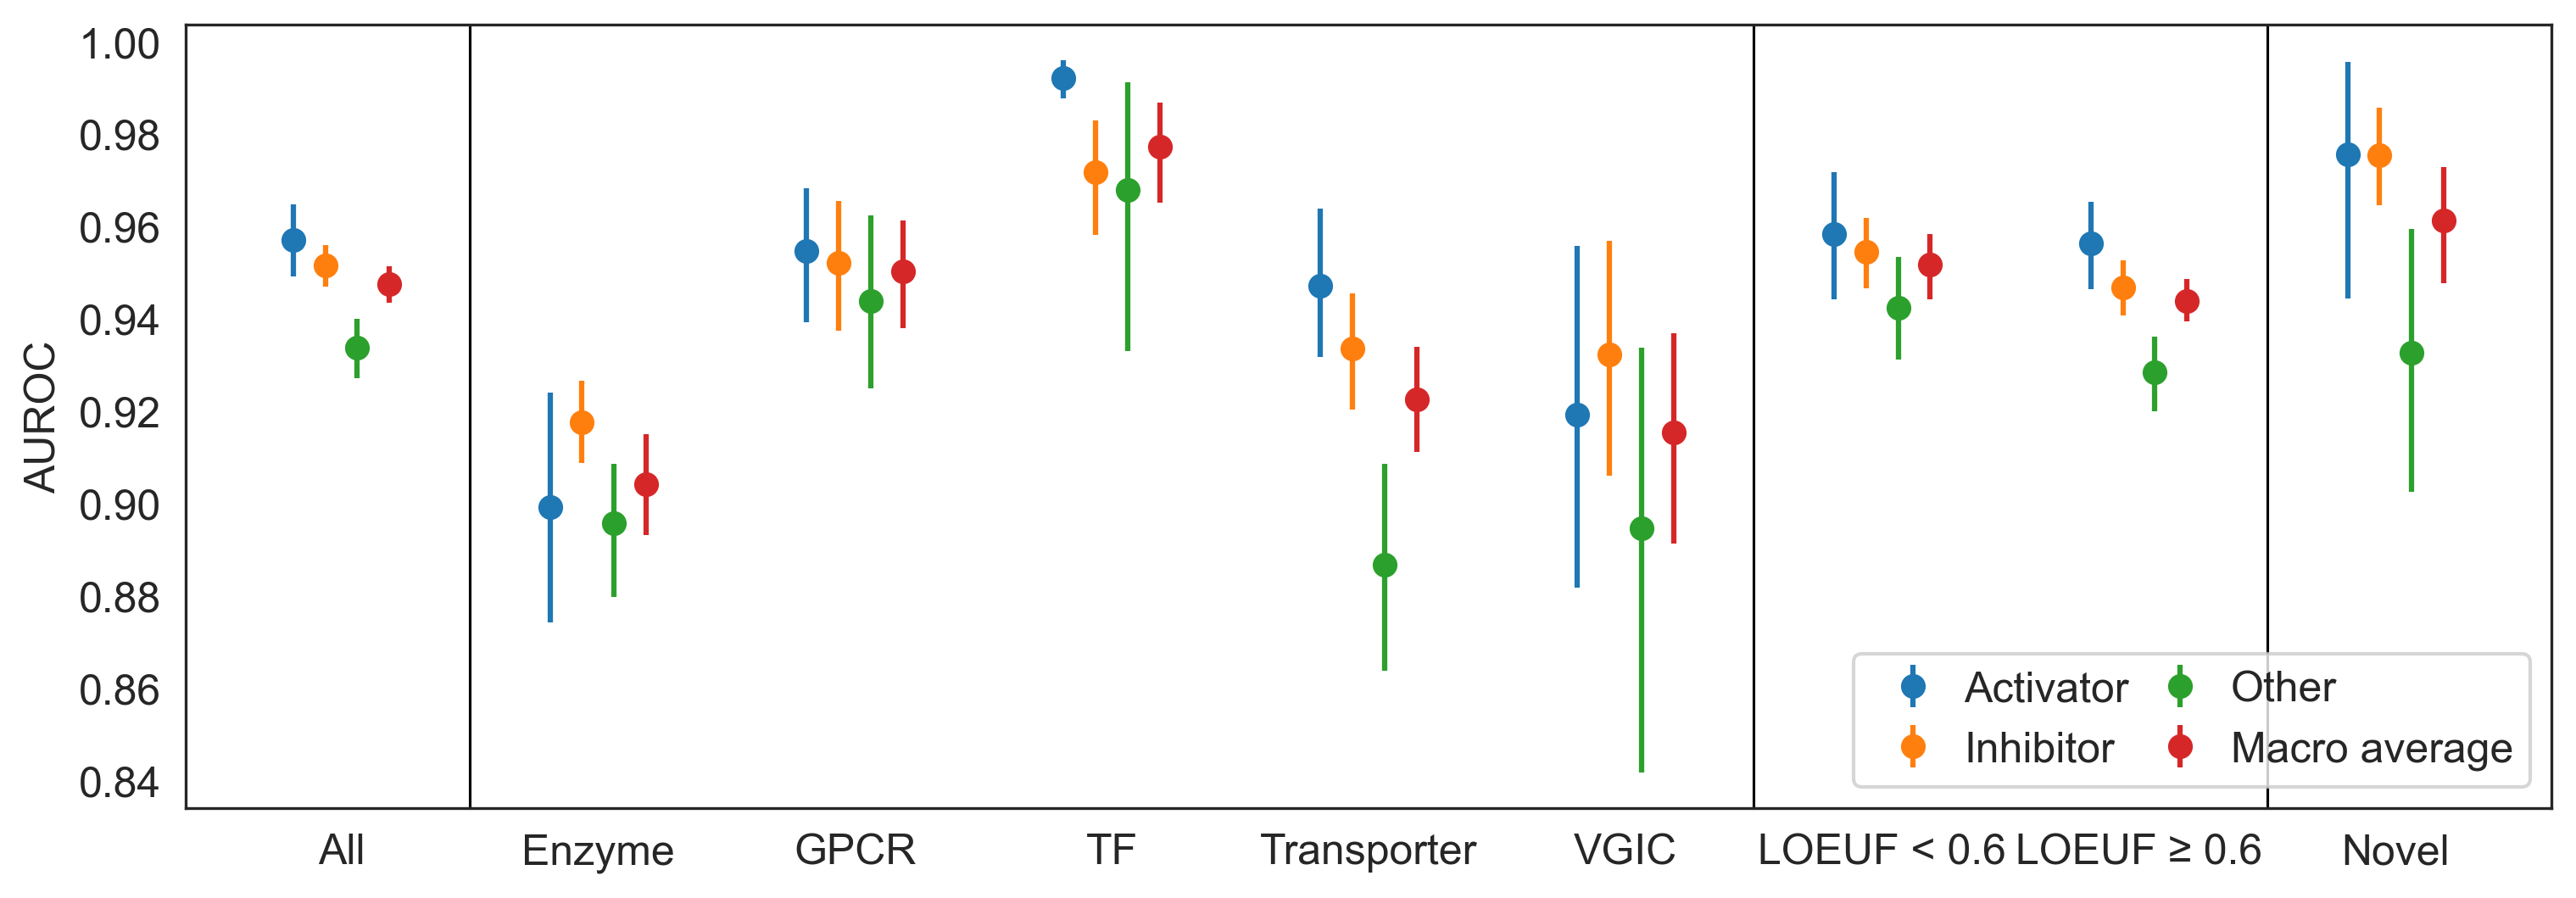

In [64]:
res = metrics.copy()
res = res.loc[res['model'] == 'All features']
res = res.loc[res['metric'].str.contains('auroc')]
res['metric'] = res['metric'].map({'auroc_neg':'Inhibitor',
                                   'auroc_other':'Other',
                                   'auroc_pos':'Activator',
                                   'auroc_macro':'Macro average'})
res['metric'] = pd.Categorical(res['metric'], ['Activator','Inhibitor','Other','Macro average'])
res = res.sort_values(['model','subset','metric']).dropna(subset='metric')

sns.set_style('white')

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
mechanisms = res['metric'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['subset'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['metric'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['subset'].unique())))
ax.set_xticklabels(res['subset'].unique())
ax.legend(title='', ncols=2, loc='lower right', columnspacing=0.2, handletextpad=0.2)

#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=0.5, color='black', linewidth=0.75)
plt.axvline(x=5.5, color='black', linewidth=0.75)
plt.axvline(x=7.5, color='black', linewidth=0.75)

#plt.ylim([0.875,0.975])
plt.xlabel('')
plt.ylabel('AUROC')


### GBM vs CNN vs LR

In [ ]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename(columns={'gene': 'ID'})[['ID', 'druggable']]
model_names = ['gb', 'cnn', 'lr']
metrics = []

def bootstrap_metrics(y_true, y_score, n_boot=500):
    np.random.seed(42)
    results = {'auroc': [], 'auprc': [], 'brier': []}
    
    for _ in range(n_boot):
        idx = np.random.randint(0, len(y_true), len(y_true))
        yt, ys = y_true[idx], y_score[idx]
        results['auroc'].append(roc_auc_score(yt, ys))
        results['auprc'].append(average_precision_score(yt, ys))
        results['brier'].append(np.mean((ys - yt) ** 2))
    
    return {k: (np.mean(v), np.percentile(v, 2.5), np.percentile(v, 97.5)) for k, v in results.items()}

for model in model_names:
    file_path = f'./Training/Predictions/{model}_druggability_all_holdout_predictions.csv' if model != 'gb' else './Training/Predictions/druggability_all_holdout_predictions.csv'
    res = pd.read_csv(file_path).merge(data)
    
    y_true, y_score = res[['druggable']].values.ravel(), res[['pred_druggable']].values.ravel()
    boot_metrics = bootstrap_metrics(y_true, y_score)
    
    metrics.extend([{'model': model, 'metric': k, 'mean': m, 'ci_low': l, 'ci_high': h} for k, (m, l, h) in boot_metrics.items()])

pd.DataFrame(metrics).to_pickle('./Training/Metrics/druggability_architecture.pkl')


In [79]:
for model in ['lr','cnn']:
    res = pd.read_csv(f'./Training/Predictions/{model}_druggability_neg_all_holdout_predictions.csv')
    res = res.merge(pd.read_csv(f'./Training/Predictions/{model}_druggability_pos_all_holdout_predictions.csv'))
    res = res.merge(pd.read_csv(f'./Training/Predictions/{model}_druggability_other_all_holdout_predictions.csv'))
    res.to_csv(f'./Training/Predictions/{model}_druggability_doe_all_holdout_predictions.csv', index=False)

In [48]:
data = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos']]
model_names = ['gb', 'cnn', 'lr']
metrics = pd.DataFrame()

def bootstrap_all_metrics(y_true,y_score,n_boot):
    np.random.seed(42)
    out={f'auroc_{c}':[] for c in ['neg','other','pos']}
    out.update({f'auprc_{c}':[] for c in ['neg','other','pos']})
    out.update({f'brier_{c}':[] for c in ['neg','other','pos']})
    for x in ['auroc_micro','auroc_macro','auprc_micro','auprc_macro','hamming','brier_micro','brier_macro']:
        out[x]=[]
    for _ in range(n_boot):
        idx=np.random.randint(0,len(y_true),len(y_true))
        yt,ys=y_true[idx],y_score[idx]
        for i,c in enumerate(['neg','other','pos']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:,i],ys[:,i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:,i],ys[:,i]))
            out[f'brier_{c}'].append(np.mean((ys[:,i] - yt[:,i])**2))
        out['auroc_micro'].append(roc_auc_score(yt,ys,average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt,ys,average='macro'))
        out['auprc_micro'].append(average_precision_score(yt,ys,average='micro'))
        out['auprc_macro'].append(average_precision_score(yt,ys,average='macro'))
        out['hamming'].append(hamming_loss(yt,(ys>=0.5).astype(int)))
        out['brier_micro'].append(np.mean((ys - yt)**2))
        out['brier_macro'].append(np.mean([(ys[:,i] - yt[:,i])**2 for i in range(yt.shape[1])]))

    return {k:(np.mean(v),np.percentile(v,2.5),np.percentile(v,97.5)) for k,v in out.items()}

for model in model_names:
    file_path = f'./Training/Predictions/{model}_druggability_doe_all_holdout_predictions.csv' if model != 'gb' else './Training/Predictions/druggability_doe_all_holdout_predictions.csv'
    res = pd.read_csv(file_path).merge(data)
    
    y_true=res[['neg','other','pos']].values
    y_score=res[['pred_neg','pred_other','pred_pos']].values
    boot=bootstrap_all_metrics(y_true,y_score,500)
    new_records=[]
    for k,(m,l,h) in boot.items():
        new_records.append({'model':model,'metric':k,'mean':m,'ci_low':l,'ci_high':h})
    metrics=pd.concat([metrics,pd.DataFrame(new_records)],ignore_index=True)

metrics.to_pickle('./Training/Metrics/druggability_doe_architecture.pkl')


In [49]:
metrics = pd.read_pickle('./Training/Metrics/druggability_doe_architecture.pkl')
metrics['model'] = metrics['model'].map({'gb':'XGBoost','cnn':'CNN','lr':'Logistic regression'})

table = metrics.copy()
table.loc[table['metric'].str.contains('neg'), 'outcome'] = 'Inhibitor'
table.loc[table['metric'].str.contains('other'), 'outcome'] = 'Other'
table.loc[table['metric'].str.contains('pos'), 'outcome'] = 'Activator'
table.loc[table['metric'].str.contains('macro'), 'outcome'] = 'Macro-average'
table.loc[table['metric'].str.contains('micro'), 'outcome'] = 'Micro-average'
table.loc[table['metric'].str.contains('auroc'), 'metric'] = 'AUROC'
table.loc[table['metric'].str.contains('auprc'), 'metric'] = 'AUPRC'
table.loc[table['metric'].str.contains('brier'), 'metric'] = 'Brier score'
table = table.dropna()
table['outcome'] = pd.Categorical(table['outcome'], ['Activator','Inhibitor','Other','Macro-average','Micro-average'])
table['value'] = table['mean'].round(3).astype(str) + ' (' + table['ci_low'].round(3).astype(str) + '-' + table['ci_high'].round(3).astype(str) + ')'
table = pd.pivot_table(table, index=['outcome','model'], columns='metric', values='value', aggfunc='first').reset_index()
table = table[['outcome','model','AUROC','AUPRC','Brier score']]
table


metric        outcome                model                AUROC  \
0           Activator                  CNN   0.941 (0.93-0.951)   
1           Activator  Logistic regression  0.933 (0.923-0.943)   
2           Activator              XGBoost  0.957 (0.949-0.965)   
3           Inhibitor                  CNN  0.937 (0.931-0.943)   
4           Inhibitor  Logistic regression  0.931 (0.925-0.936)   
5           Inhibitor              XGBoost  0.952 (0.947-0.956)   
6               Other                  CNN  0.911 (0.901-0.919)   
7               Other  Logistic regression  0.899 (0.891-0.908)   
8               Other              XGBoost   0.934 (0.927-0.94)   
9       Macro-average                  CNN   0.93 (0.924-0.935)   
10      Macro-average  Logistic regression  0.921 (0.916-0.926)   
11      Macro-average              XGBoost  0.948 (0.944-0.951)   
12      Micro-average                  CNN  0.934 (0.929-0.939)   
13      Micro-average  Logistic regression  0.928 (0.923-0.933)   
14      Micro-average              XGBoost  0.952 (0.948-0.955)   

metric                AUPRC          Brier score  
0       0.621 (0.582-0.659)  0.018 (0.016-0.019)  
1        0.554 (0.51-0.598)   0.02 (0.018-0.022)  
2        0.63 (0.589-0.668)  0.018 (0.016-0.019)  
3       0.713 (0.691-0.734)   0.048 (0.046-0.05)  
4       0.681 (0.659-0.701)  0.051 (0.049-0.054)  
5       0.755 (0.735-0.772)  0.045 (0.043-0.047)  
6       0.528 (0.498-0.556)  0.037 (0.035-0.039)  
7       0.471 (0.439-0.502)   0.04 (0.037-0.042)  
8           0.57 (0.54-0.6)  0.036 (0.034-0.038)  
9         0.62 (0.599-0.64)  0.034 (0.033-0.035)  
10       0.569 (0.544-0.59)  0.037 (0.036-0.038)  
11      0.652 (0.631-0.671)  0.033 (0.032-0.034)  
12      0.645 (0.626-0.664)  0.034 (0.033-0.035)  
13      0.599 (0.577-0.616)  0.037 (0.036-0.038)  
14      0.683 (0.665-0.699)  0.033 (0.032-0.034)

### Correlations

In [3]:
import pandas as pd
from scipy.stats import spearmanr

da = pd.read_csv('./Training/Predictions/druggability_all_holdout_predictions.csv')
both = pd.read_csv('./Training/Predictions/druggability_doe_all_holdout_predictions.csv')
both = both.set_axis(['ID','dd_neg','dd_other','dd_pos'], axis=1)
doe = pd.read_csv('./Training/Predictions/doe_all_holdout_predictions.csv')
doe = doe.set_axis(['ID','Inhibitor','Other','Activator'], axis=1)[['ID','Activator','Inhibitor','Other']]
res = both.merge(doe).merge(da)

correlations = [
    ('DOE Activator', 'DOE Inhibitor', *spearmanr(doe['Activator'], doe['Inhibitor'])),
    ('DOE Activator', 'DOE Other', *spearmanr(doe['Activator'], doe['Other'])),
    ('DOE Inhibitor', 'DOE Other', *spearmanr(doe['Inhibitor'], doe['Other'])),
    ('DOE Inhibitor', 'Druggability', *spearmanr(res['Inhibitor'], res['pred_druggable'])),
    ('DOE Activator', 'Druggability', *spearmanr(res['Activator'], res['pred_druggable'])),
    ('DOE Other', 'Druggability', *spearmanr(res['Other'], res['pred_druggable'])),
    ('DOE/Druggability Inhibitor', 'Druggability', *spearmanr(res['dd_neg'], res['pred_druggable'])),
    ('DOE/Druggability Activator', 'Druggability', *spearmanr(res['dd_pos'], res['pred_druggable'])),
    ('DOE/Druggability Other', 'Druggability', *spearmanr(res['dd_other'], res['pred_druggable']))
]

df_results = pd.DataFrame(correlations, columns=['Variable 1', 'Variable 2', 'Spearman Correlation', 'P-value'])
df_results

Variable 1     Variable 2  Spearman Correlation  \
0               DOE Activator  DOE Inhibitor             -0.090798   
1               DOE Activator      DOE Other              0.092399   
2               DOE Inhibitor      DOE Other             -0.529825   
3               DOE Inhibitor   Druggability              0.446020   
4               DOE Activator   Druggability              0.198201   
5                   DOE Other   Druggability             -0.092427   
6  DOE/Druggability Inhibitor   Druggability              0.830875   
7  DOE/Druggability Activator   Druggability              0.527584   
8      DOE/Druggability Other   Druggability              0.507082   

         P-value  
0   4.327033e-06  
1   2.919503e-06  
2  8.943604e-185  
3  4.758329e-125  
4   4.982892e-24  
5   2.899652e-06  
6   0.000000e+00  
7  5.966081e-183  
8  6.932083e-167

1317
14
1014
55


{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

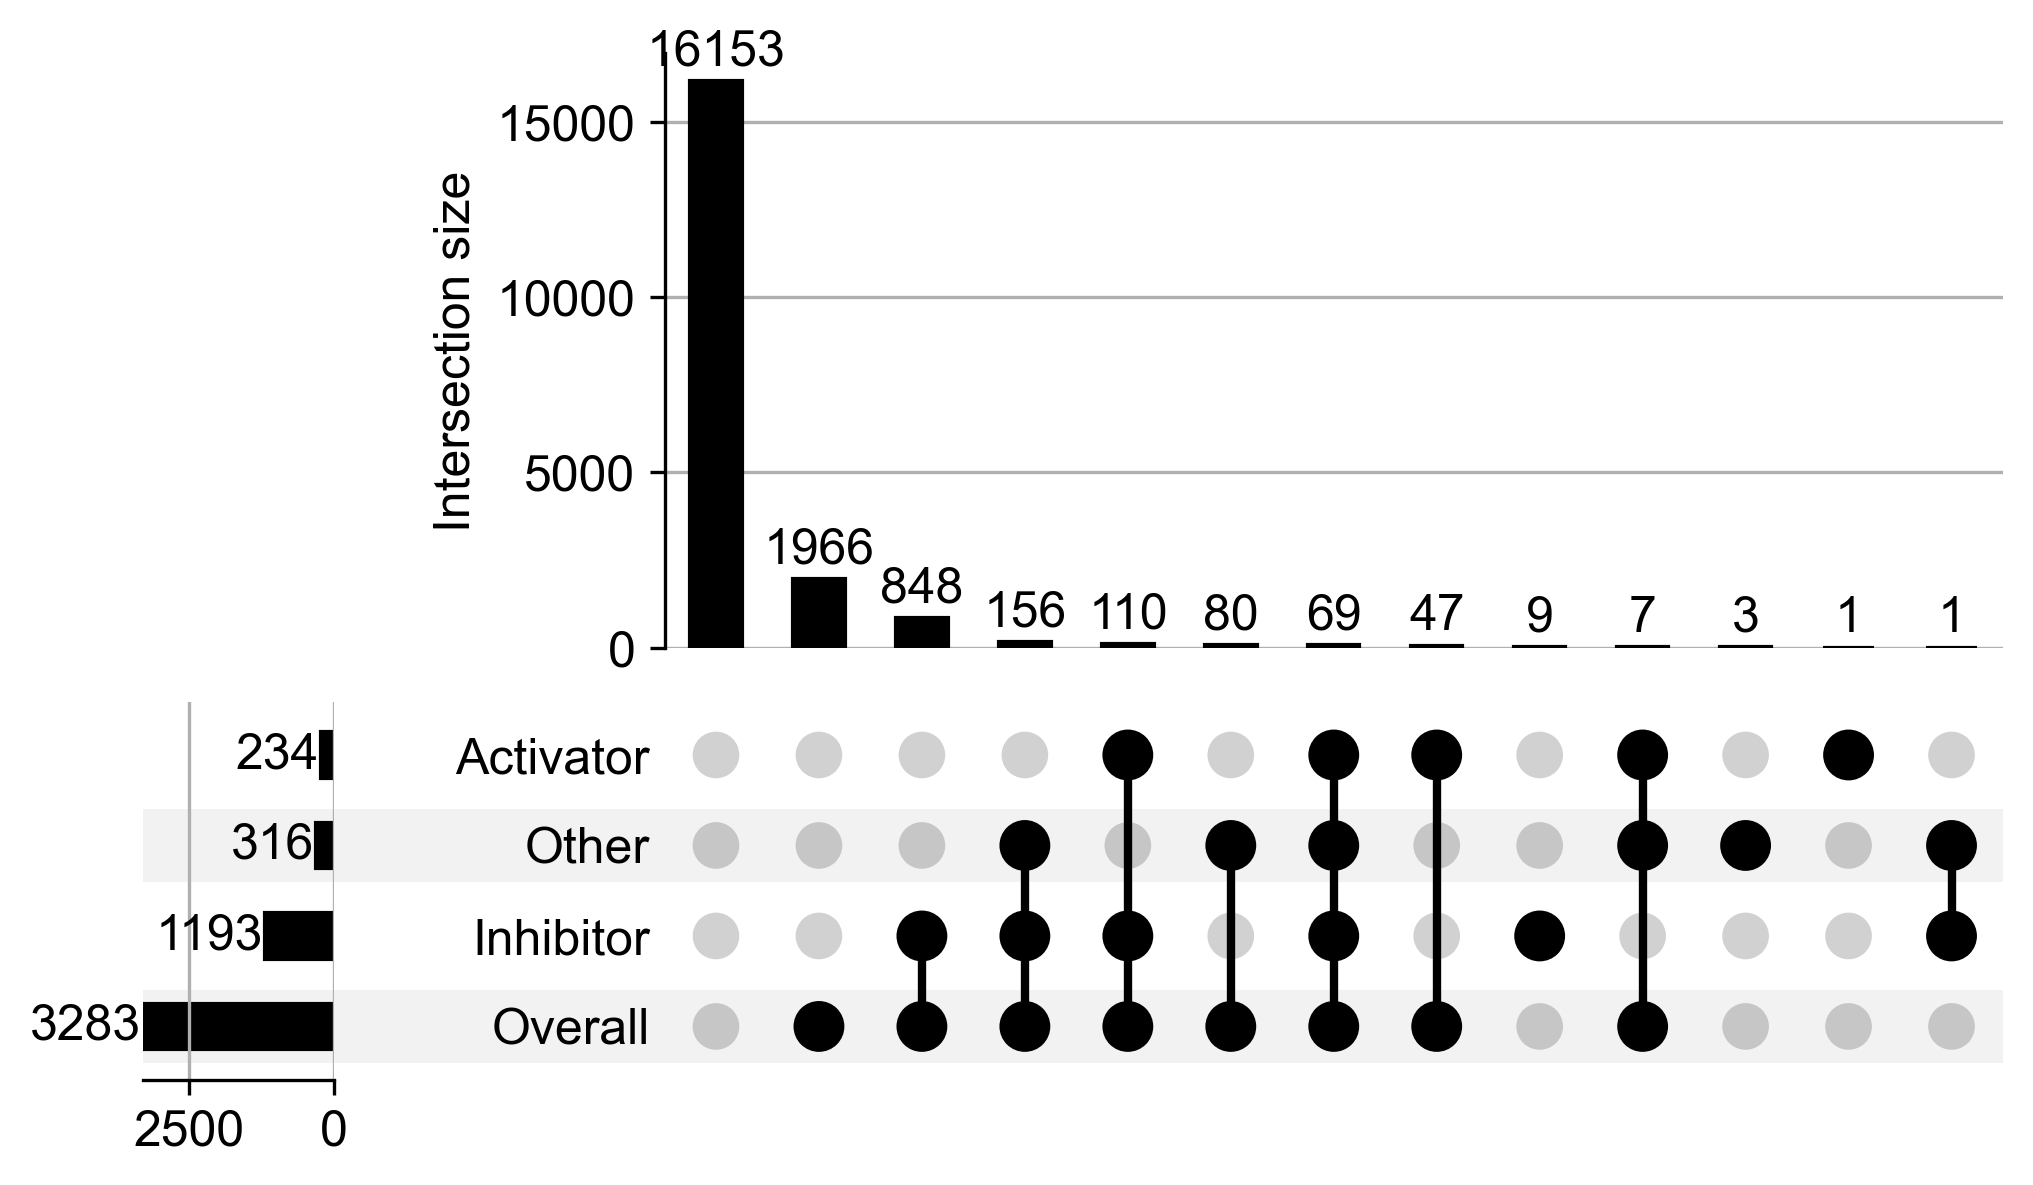

In [54]:
da = pd.read_csv('./Training/Predictions/druggability_all_holdout_predictions.csv')
both = pd.read_csv('./Training/Predictions/druggability_doe_all_holdout_predictions.csv')
both = both.set_axis(['ID','dd_neg','dd_other','dd_pos'], axis=1)
da = da.merge(both)

print(len(da.loc[(da['pred_druggable'] >= 0.5) & ((da['dd_neg'] >= 0.5) | (da['dd_pos'] >= 0.5) | (da['dd_other'] >= 0.5))]))
print(len(da.loc[(da['pred_druggable'] < 0.5) & ((da['dd_neg'] >= 0.5) | (da['dd_pos'] >= 0.5) | (da['dd_other'] >= 0.5))]))
print(len(da.loc[(da['dd_neg'] >= 0.5) & (da['dd_pos'] < 0.5)]))
print(len(da.loc[(da['dd_pos'] >= 0.5) & (da['dd_neg'] < 0.5)]))

da = da.drop(['ID','pred_tc'],axis=1).set_axis(['Overall','Inhibitor','Other','Activator'],axis=1)

columns_of_interest = ['Overall','Inhibitor','Other','Activator']
boolean_df = da[columns_of_interest] >= 0.5
upset_data = from_indicators(columns_of_interest, boolean_df)

fig = plt.figure(figsize=(8, 4), dpi=300)
upset = UpSet(
    upset_data, 
    sort_by="cardinality",  # Sort intersections from most to least frequent
    show_counts=True
)
upset.plot(fig=fig)


## DOE only

In [69]:
data = pd.read_pickle('./OT/Final/gene_direction.pkl').rename({'gene':'ID'},axis=1)
gene_embed = pd.read_pickle('./GenePT/genept_em3l.pkl').rename({'gene':'ID'},axis=1).round(5).iloc[:, :257]
prot_embed = pd.read_pickle('./UniProt/pca_embeddings_128.pkl').rename({'gene':'ID'},axis=1)
data = data.merge(gene_embed, how='left').merge(prot_embed, how='left')
data.columns = data.columns.astype(str)

# Generate predictions for genes outside training dataset
all_genes = pd.read_pickle('./OT/Final/gene_direction_all.pkl').rename({'gene':'ID'},axis=1).merge(gene_embed, how='left').merge(prot_embed, how='left')
all_genes.columns = all_genes.columns.astype(str)
all_genes = all_genes[data.columns]
all_genes = all_genes.loc[~all_genes['ID'].isin(data['ID'])]

genetics = ['mab_count', 'tissueSpecificity', 'tissueDistribution', 
           'hasPocket', 'mouseKOScore', 'paralogMaxIdentityPercentage',
           'oncokb_oncogene', 'oncokb_suppressor', 'oncokb_sources',
           'loc_intracellular', 'loc_membrane', 'loc_secreted', 'loc_plasma',
           'class_enzyme', 'class_transporter', 'class_tf', 'class_gpcr',
           'class_vgic', 'lof.oe', 'lof.pLI', 'lof.pRec', 'lof.pNull',
           'lof.oe_ci.upper', 'mis.oe', 'mis_pphen.oe', 'syn.oe', 
           'gofcards', 'omim_ad', 'omim_ar', 'depmap_ss','clingen_hi', 
           'depmap_ce', 'badonyi_pgof', 'badonyi_pdn', 'badonyi_plof',
           'collins_phaplo', 'collins_ptriplo', 
           'protein_length', 'gtex_tau', 'af_pockets_0', 'af_pockets_0.1']
gene_embed = list(gene_embed.drop('ID',axis=1).columns.astype(str))
prot_embed = list(prot_embed.drop('ID',axis=1).columns.astype(str))


In [ ]:
num_folds_outer = 8
num_folds_inner = 8
shap_enabled = False

if False:
    model_names = ['all','gene_embed','prot_embed','all_embed','genetics']
    feature_names = [genetics+gene_embed+prot_embed,gene_embed,prot_embed,gene_embed+prot_embed,genetics]

if True:
    model_names = ['all']
    feature_names = [genetics+gene_embed+prot_embed]

for i,j in zip(model_names, feature_names):
    print(i)    

    ids = data["ID"].values
    X = data[j]
    y = data[["neg","other","pos"]].values    
    y_binary = (y > 0).astype(int)

    X_ext = all_genes[j]
    dext = xgb.DMatrix(X_ext, enable_categorical=True)
    ids_ext = all_genes["ID"].values
    
    outer_kf = KFold(n_splits=num_folds_outer, shuffle=True, random_state=42)
    fold_counter_outer = 0
    
    all_preds = []
    ext_preds = []

    shap_neg = pd.DataFrame()
    shap_oth = pd.DataFrame()
    shap_pos = pd.DataFrame()
    
    for outer_train_idx, holdout_idx in outer_kf.split(X):
        fold_counter_outer += 1
        print(fold_counter_outer)
        X_outer_train, X_holdout = X.iloc[outer_train_idx], X.iloc[holdout_idx]
        y_outer_train, y_holdout = y[outer_train_idx], y[holdout_idx]
        y_holdout_binary = y_binary[holdout_idx]
        ids_holdout = ids[holdout_idx]
    
        inner_kf = KFold(n_splits=num_folds_inner, shuffle=True, random_state=42)
        fold_counter_inner = 0
        print(fold_counter_inner)
        
        holdout_preds_all = []
        ext_preds_all = []
        
        for inner_train_idx, val_idx in inner_kf.split(X_outer_train):
            fold_counter_inner += 1
            X_inner_train, X_val = X_outer_train.iloc[inner_train_idx], X_outer_train.iloc[val_idx]
            y_inner_train, y_val = y_outer_train[inner_train_idx], y_outer_train[val_idx]
    
            dtrain = xgb.DMatrix(X_inner_train, label=y_inner_train, enable_categorical=True)
            dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
            dholdout = xgb.DMatrix(X_holdout, enable_categorical=True)
    
            params = {
                "objective":"reg:logistic",
                "max_depth":7,
                "alpha":5,
                "lambda":1,
                "eta":0.1,
                "min_child_weight":10,
                "nthread":12,
            }
    
            model = xgb.train(
                params, dtrain, num_boost_round=2000,
                early_stopping_rounds=15,
                evals=[(dval,"eval")],
                verbose_eval=False
            )
    
            # Save model
            # model.save_model(f"./Training/Models/druggability_doe_{i}_outer{fold_counter_outer}_inner{fold_counter_inner}.json")

            if (i in ['all']) & (shap_enabled == True):
                if fold_counter_inner == 1:
                    explainer = shap.TreeExplainer(model)
                    explanation = explainer(dholdout)
                    ex_neg = pd.DataFrame(explanation[:,:,0].values, columns=X.columns)
                    ex_neg['ID'] = ids_holdout
                    shap_neg = pd.concat([shap_neg,ex_neg])
                    ex_oth = pd.DataFrame(explanation[:,:,1].values, columns=X.columns)
                    ex_oth['ID'] = ids_holdout
                    shap_oth = pd.concat([shap_oth,ex_oth])
                    ex_pos = pd.DataFrame(explanation[:,:,2].values, columns=X.columns)
                    ex_pos['ID'] = ids_holdout
                    shap_pos = pd.concat([shap_pos,ex_pos])
                    
            preds_holdout = model.predict(dholdout)
            preds_holdout = preds_holdout.reshape(len(X_holdout), -1)
            holdout_preds_all.append(preds_holdout)

            preds_ext = model.predict(dext)
            preds_ext = preds_ext.reshape(len(X_ext), -1)
            ext_preds_all.append(preds_ext)        
    
        holdout_preds_all = np.mean(np.stack(holdout_preds_all, axis=0), axis=0)
        ext_preds_all = np.mean(np.stack(ext_preds_all, axis=0), axis=0)
        
        binary_preds = (holdout_preds_all > 0.5).astype(int)
        for c in range(y_holdout_binary.shape[1]):
            auroc = roc_auc_score(y_holdout_binary[:,c], holdout_preds_all[:,c])
            auprc = average_precision_score(y_holdout_binary[:,c], holdout_preds_all[:,c])
            prop_positives = y_holdout_binary[:,c].mean()
            print(f"Outer Fold {fold_counter_outer}, Class {c}: AUROC={auroc}, AUPRC={auprc}, Proportion positives={prop_positives}")
        hl = hamming_loss(y_holdout_binary, binary_preds)
        print(f"Outer Fold {fold_counter_outer}: Hamming Loss={hl}")
    
        # Store holdout predictions
        fold_df = pd.DataFrame({
            "ID": ids_holdout,
            "pred_neg": holdout_preds_all[:,0],
            "pred_other": holdout_preds_all[:,1],
            "pred_pos": holdout_preds_all[:,2]
        })
        all_preds.append(fold_df)

        # Store external predictions
        fold_df = pd.DataFrame({
            "ID": ids_ext,
            "pred_neg": ext_preds_all[:,0],
            "pred_other": ext_preds_all[:,1],
            "pred_pos": ext_preds_all[:,2]
        })
        ext_preds.append(fold_df)
    
    # Concatenate all holdout predictions
    final_preds = pd.concat(all_preds, axis=0)
    final_preds = final_preds.groupby("ID").mean().reset_index()
    final_preds.to_csv(f"./Training/Predictions/doe_{i}_holdout_predictions.csv", index=False)

    final_preds = pd.concat(ext_preds, axis=0)
    final_preds = final_preds.groupby("ID").mean().reset_index()
    final_preds.to_csv(f"./Training/Predictions/doe_{i}_ext_predictions.csv", index=False)

    if (i in ['all']) & (shap_enabled == True):
        shap_neg = shap_neg.groupby('ID').mean().reset_index()
        shap_neg.to_pickle(f'./Training/SHAP/doe_{i}_shap_neg.pkl')
        shap_oth = shap_oth.groupby('ID').mean().reset_index()
        shap_oth.to_pickle(f'./Training/SHAP/doe_{i}_shap_oth.pkl')
        shap_pos = shap_pos.groupby('ID').mean().reset_index()
        shap_pos.to_pickle(f'./Training/SHAP/doe_{i}_shap_pos.pkl')
        

### SHAP

In [70]:
i = 'all'
shap_neg = pd.read_pickle(f'./Training/SHAP/doe_{i}_shap_neg.pkl')
shap_pos = pd.read_pickle(f'./Training/SHAP/doe_{i}_shap_pos.pkl')
shap_oth = pd.read_pickle(f'./Training/SHAP/doe_{i}_shap_oth.pkl')

fv = data[shap_neg.columns]
fv = shap_neg[['ID']].merge(fv)
for col in ['loc_intracellular','loc_membrane','loc_secreted','loc_plasma','class_enzyme',
            'class_transporter','class_tf','class_gpcr','class_vgic','oncokb_oncogene',
            'oncokb_suppressor','oncokb_sources','omim_ad','omim_ar','gofcards','clingen_hi']:
    fv[col] = fv[col].fillna(0)
    
shap_neg = shap_neg.drop('ID', axis=1)
shap_pos = shap_pos.drop('ID', axis=1)
shap_oth = shap_oth.drop('ID', axis=1)
fv = fv.drop('ID', axis=1)

# Function to compute Spearman correlations
def compute_correlations(shap_data, fv_data):
    correlations = {}
    for col in shap_data.columns:
        if pd.api.types.is_numeric_dtype(fv_data[col]):
            mask = ~(shap_data[col].isna() | fv_data[col].isna())
            if mask.any():
                correlations[col] = spearmanr(fv_data.loc[mask, col], shap_data.loc[mask, col])[0]
    return correlations

# Function to compute SHAP absolute mean for all values and only for nonzero/non-NaN values in fv
def compute_shap_stats(shap_data, fv_data, label):
    correlations = compute_correlations(shap_data, fv_data)
    shap_values = []
    
    for col in shap_data.columns:
        all_mean = shap_data[col].abs().mean()  # Mean over all values
        
        mask = ~(fv_data[col].isna() | (fv_data[col] == 0))  # Ignore NaN and zero values in fv
        filtered_mean = shap_data.loc[mask, col].abs().mean() if mask.any() else None  # Mean over filtered values

        shap_values.append((col, all_mean, filtered_mean))

    shap_stats = pd.DataFrame(shap_values, columns=['feature', label, f'{label}_nonzero_nonNaN'])
    shap_corr = pd.DataFrame(list(correlations.items()), columns=['feature', f'{label}_corr'])
    
    return shap_stats.merge(shap_corr, how='left')

# Compute SHAP statistics for neg, pos, and other
sn = compute_shap_stats(shap_neg, fv, 'neg')
sp = compute_shap_stats(shap_pos, fv, 'pos')
so = compute_shap_stats(shap_oth, fv, 'other')

# Merge results
sa = sn.merge(sp, on='feature').merge(so, on='feature')
sa['average'] = sa[['neg', 'other', 'pos']].mean(axis=1)
sa['average_nonzero_nonNaN'] = sa[['neg_nonzero_nonNaN', 'other_nonzero_nonNaN', 'pos_nonzero_nonNaN']].mean(axis=1)

# Assign categories
sa.loc[sa['feature'].isin(genetics), 'category'] = 'Tabular features'
sa.loc[sa['feature'].isin(gene_embed), 'category'] = 'Gene embeddings'
sa.loc[sa['feature'].isin(prot_embed), 'category'] = 'Protein embeddings'

print(len(sa.loc[sa['neg_corr']/sa['pos_corr'] < 0]))
sa = sa.merge(pd.read_excel('./Supplemental tables/druggability_fi.xlsx').drop(['category'],axis=1))

sa.sort_values('average',ascending=False).to_excel('./Supplemental tables/doe_fi.xlsx', index=False)


211


In [71]:
print(spearmanr(sa['neg'],sa['druggable']))
print(spearmanr(sa['pos'],sa['druggable']))
print(spearmanr(sa['other'],sa['druggable']))
print(spearmanr(sa['average'],sa['druggable']))


SignificanceResult(statistic=0.18437722269929355, pvalue=0.0001320189339771892)
SignificanceResult(statistic=0.14053555009298813, pvalue=0.0036948586139864143)
SignificanceResult(statistic=0.13137201530585788, pvalue=0.006686032097213987)
SignificanceResult(statistic=0.17156522938724694, pvalue=0.00038105470763744097)


### Distributions

In [81]:
doe = pd.read_csv(f'./Training/Predictions/doe_{i}_holdout_predictions.csv')
pred = pd.read_csv(f'./Training/Predictions/druggability_doe_{i}_holdout_predictions.csv').set_axis(['ID','doe_neg','doe_other','doe_pos'],axis=1)
drug = pd.read_csv(f'./Training/Predictions/druggability_{i}_holdout_predictions.csv')
drug = drug.merge(pred).drop('pred_tc',axis=1).merge(doe, how='left')
do = drug.dropna()


In [99]:
res = []
for doe in ['pos','neg','other']:
    sr = spearmanr(do['pred_druggable'], do['doe_'+doe])
    res.append({'Predictor':'DOE-specific druggability','DOE':doe,'Rho':sr[0],'p-value':sr[1]})
    sr = spearmanr(do['pred_druggable'], do['pred_'+doe])
    res.append({'Predictor':'DOE only','DOE':doe,'Rho':sr[0],'p-value':sr[1]})
pd.DataFrame(res)

Predictor    DOE       Rho        p-value
0  DOE-specific druggability    pos  0.527584  5.966081e-183
1                   DOE only    pos  0.198201   4.982892e-24
2  DOE-specific druggability    neg  0.830875   0.000000e+00
3                   DOE only    neg  0.446020  4.758329e-125
4  DOE-specific druggability  other  0.507082  6.932083e-167
5                   DOE only  other -0.092427   2.899652e-06

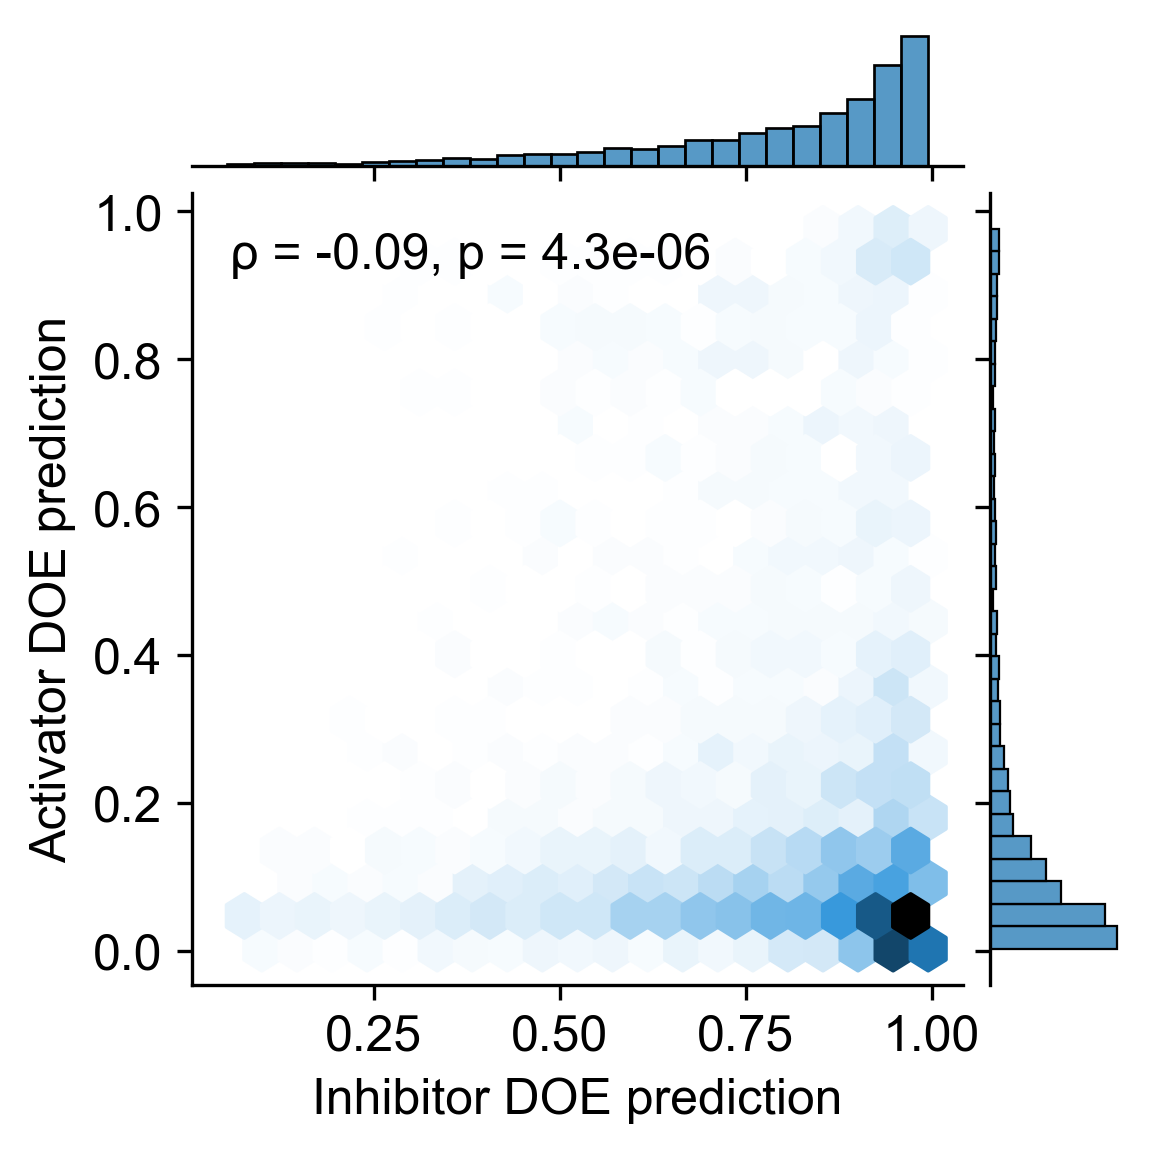

In [93]:
x = 'pred_neg'
y = 'pred_pos'
temp = do.dropna(subset=[x,y])

g = sns.jointplot(data=temp, x=x, y=y, kind="hex", joint_kws={'gridsize': 20}, height=4)
g.fig.set_dpi(300)

rho, p_value = spearmanr(temp[x], temp[y])
annotation = f'ρ = {rho:.2f}, p = {p_value:.1e}'
g.ax_joint.text(0.05, 0.95, annotation, transform=g.ax_joint.transAxes,
                ha='left', va='top', fontsize=12)

plt.xlabel('Inhibitor DOE prediction')
plt.ylabel('Activator DOE prediction')
plt.show()


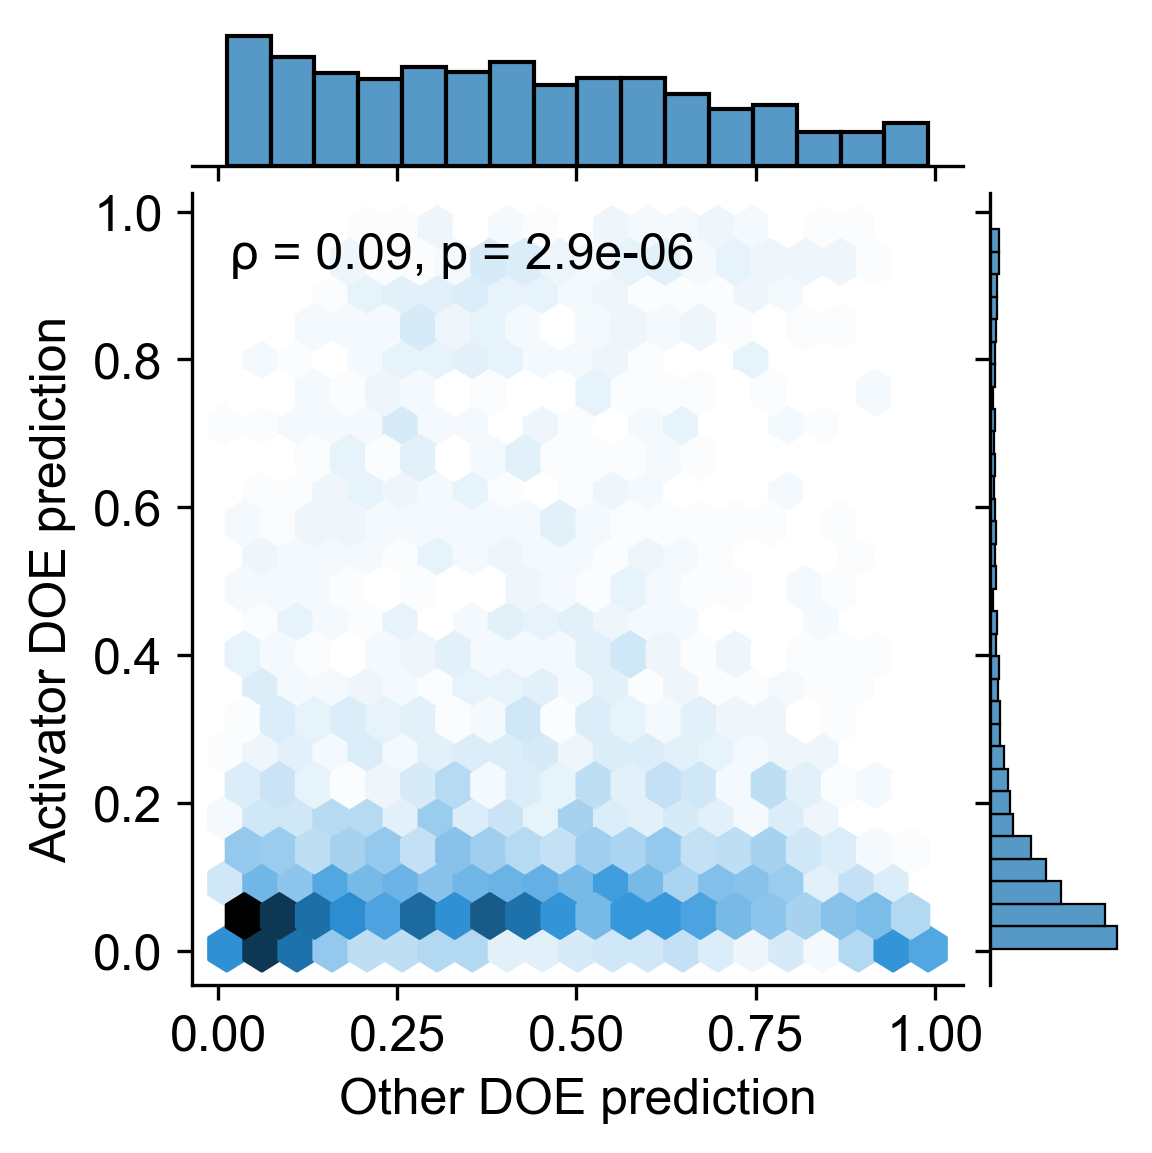

In [94]:
x = 'pred_other'
y = 'pred_pos'
temp = do.dropna(subset=[x,y])

g = sns.jointplot(data=temp, x=x, y=y, kind="hex", joint_kws={'gridsize': 20}, height=4)
g.fig.set_dpi(300)

rho, p_value = spearmanr(temp[x], temp[y])
annotation = f'ρ = {rho:.2f}, p = {p_value:.1e}'
g.ax_joint.text(0.05, 0.95, annotation, transform=g.ax_joint.transAxes,
                ha='left', va='top', fontsize=12)

plt.xlabel('Other DOE prediction')
plt.ylabel('Activator DOE prediction')
plt.show()


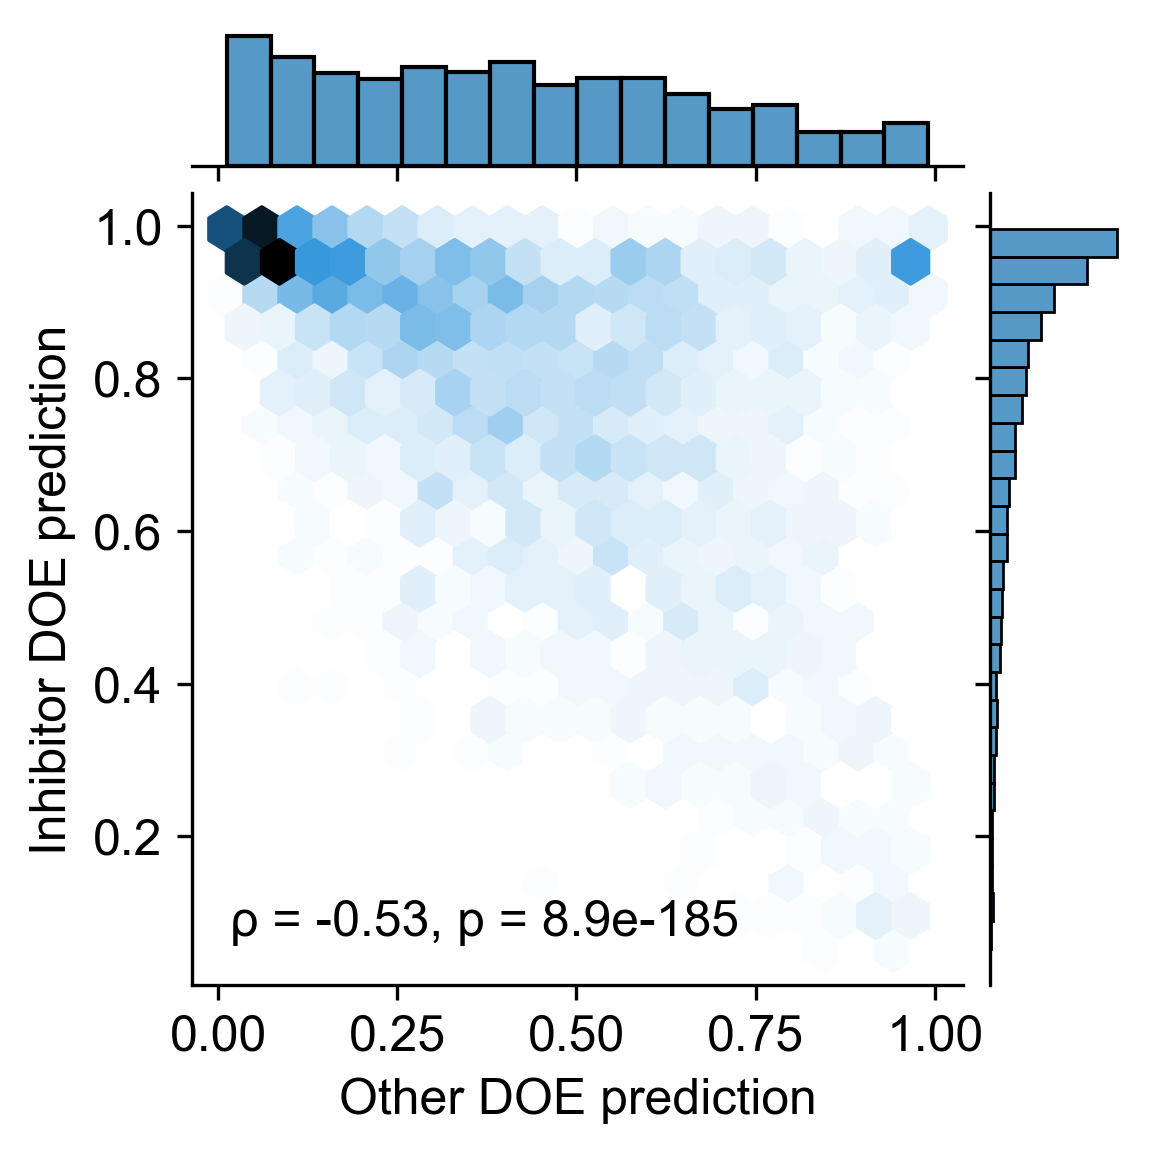

In [96]:
x = 'pred_other'
y = 'pred_neg'
temp = do.dropna(subset=[x,y])

g = sns.jointplot(data=temp, x=x, y=y, kind="hex", joint_kws={'gridsize': 20}, height=4)
g.fig.set_dpi(300)

rho, p_value = spearmanr(temp[x], temp[y])
annotation = f'ρ = {rho:.2f}, p = {p_value:.1e}'
g.ax_joint.text(0.05, 0.05, annotation, transform=g.ax_joint.transAxes,
                ha='left', va='bottom', fontsize=12)

plt.xlabel('Other DOE prediction')
plt.ylabel('Inhibitor DOE prediction')
plt.show()


### Precision recall plots

In [10]:
data = pd.read_pickle('./OT/Final/gene_direction.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos']]
pred = pd.read_csv(f'./Training/Predictions/doe_all_holdout_predictions.csv').merge(data)


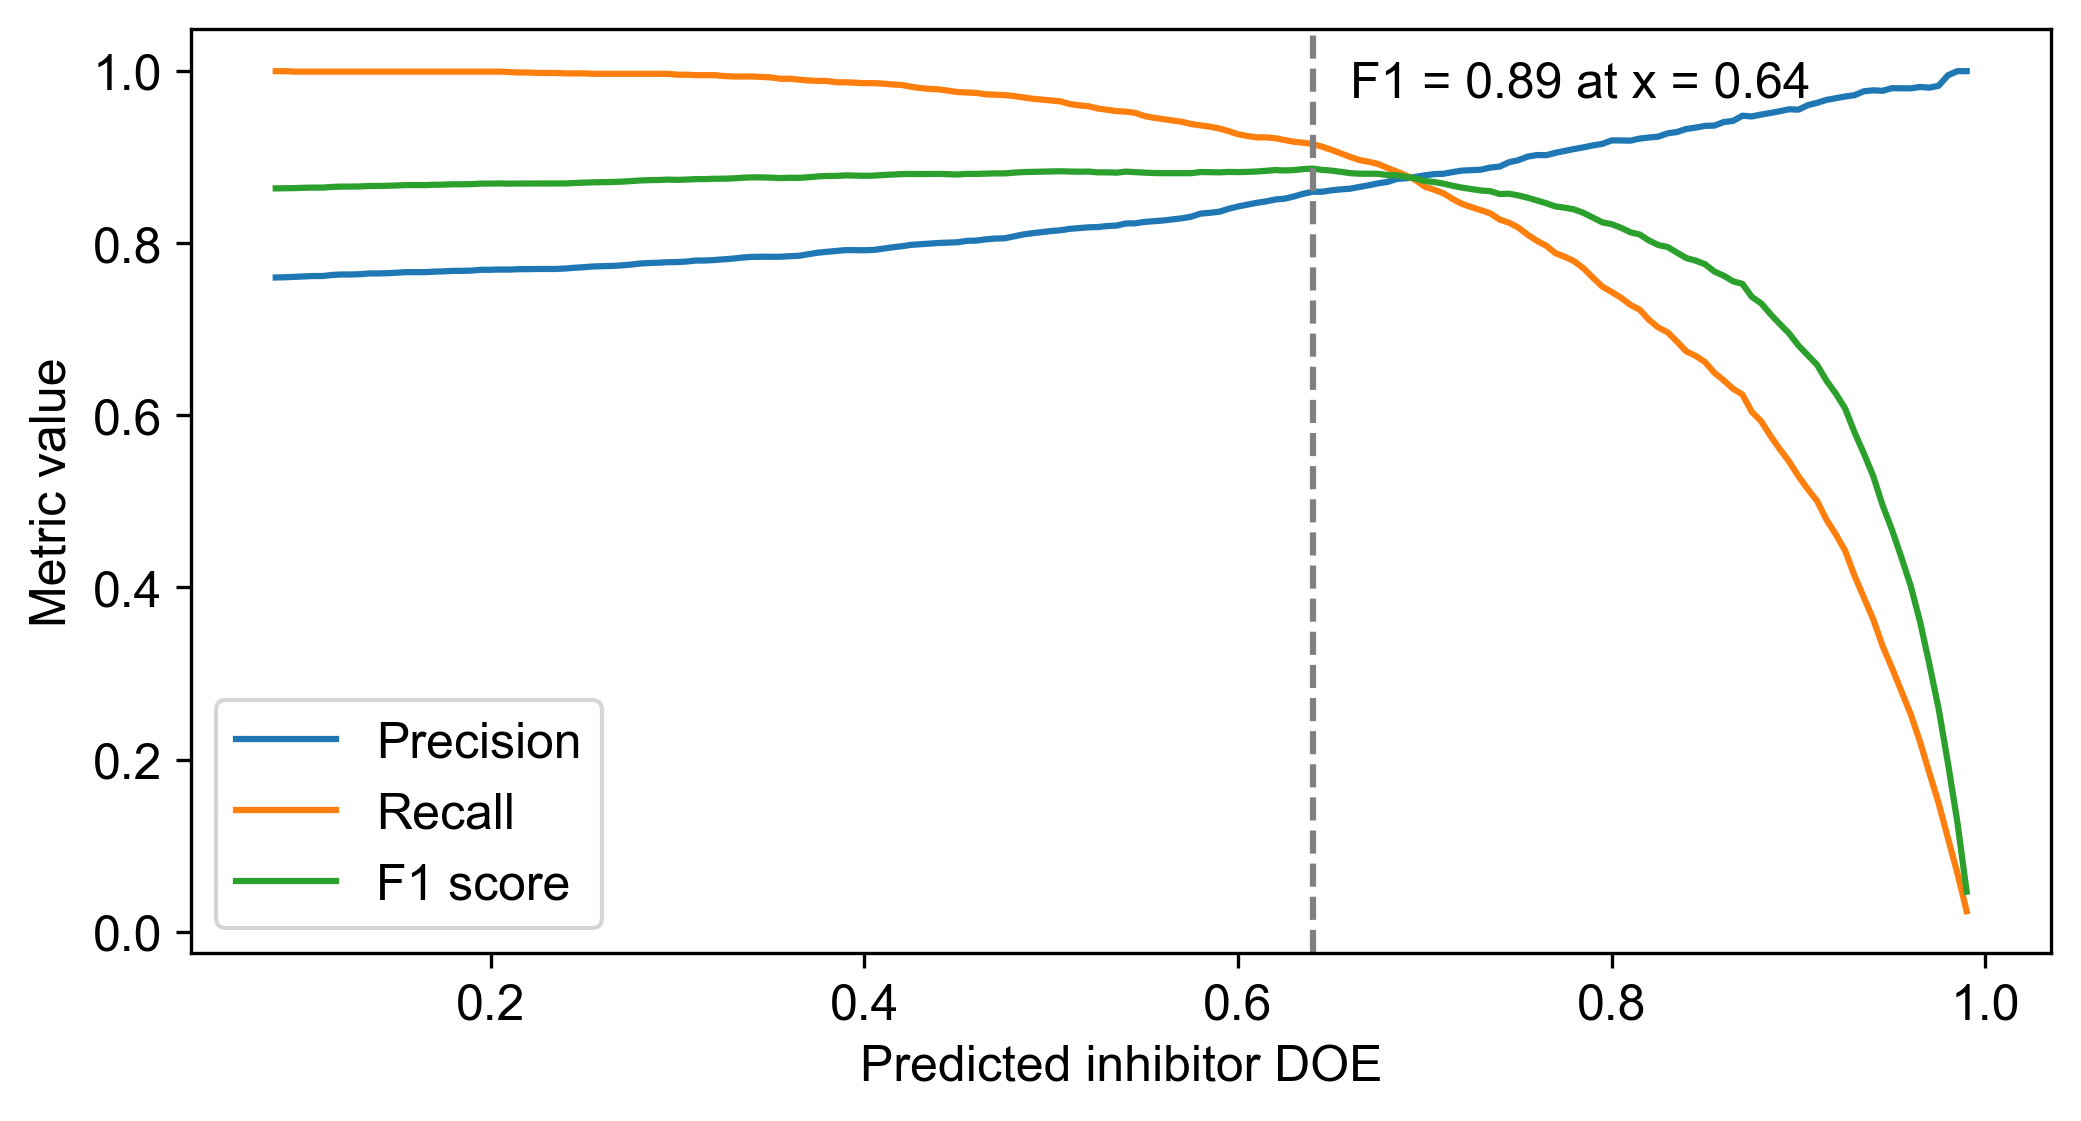

In [11]:
plt.figure(figsize=(8,4), dpi=300)
thresholds=np.arange(0,1.0001,0.005)
rows=[]
for t in thresholds:
    b=(pred['pred_neg']>=t).astype(int)
    if b.sum()>=5 and (len(b)-b.sum())>=5:
        p=precision_score(pred['neg'],b,zero_division=0)
        r=recall_score(pred['neg'],b,zero_division=0)
        f=f1_score(pred['neg'],b,zero_division=0)
        rows.extend([[t,'Precision',p],[t,'Recall',r],[t,'F1 score',f]])
df=pd.DataFrame(rows,columns=['threshold','metric','value'])
best_f1=df[df['metric']=='F1 score']
bt=best_f1.loc[best_f1['value'].idxmax(),'threshold'] if not best_f1.empty else None
sns.lineplot(x='threshold',y='value',hue='metric',data=df)
if bt is not None:
    plt.axvline(x=bt,linestyle='--',color='gray')
    max_f1=best_f1['value'].max()
    plt.annotate(f'F1 = {max_f1:.2f} at x = {bt:.2f}',xy=(bt+0.02,0.97))
plt.legend(title='')
plt.xlabel('Predicted inhibitor DOE')
plt.ylabel('Metric value')
plt.show()


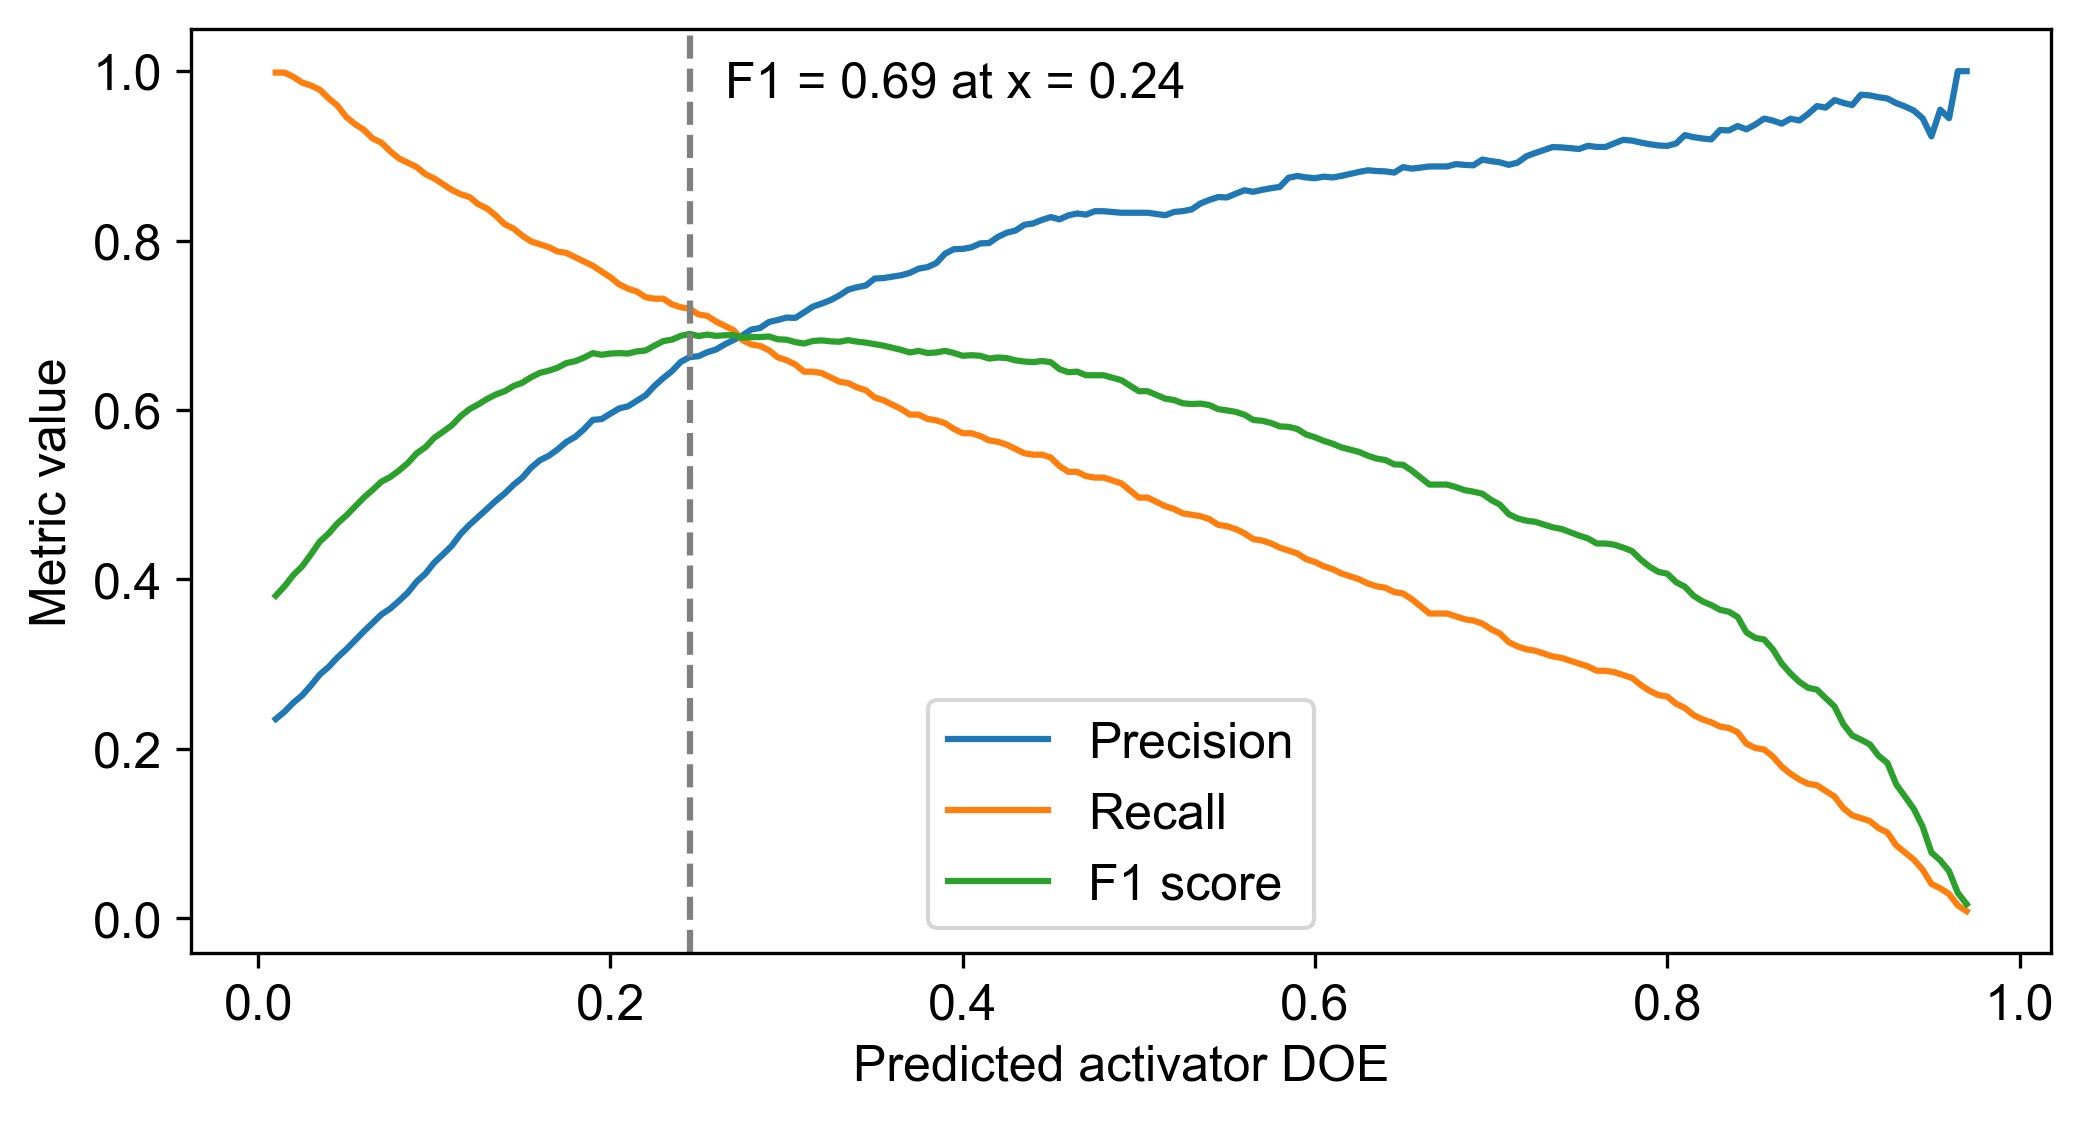

In [12]:
plt.figure(figsize=(8,4), dpi=300)
thresholds=np.arange(0,1.0001,0.005)
rows=[]
for t in thresholds:
    b=(pred['pred_pos']>=t).astype(int)
    if b.sum()>=5 and (len(b)-b.sum())>=5:
        p=precision_score(pred['pos'],b,zero_division=0)
        r=recall_score(pred['pos'],b,zero_division=0)
        f=f1_score(pred['pos'],b,zero_division=0)
        rows.extend([[t,'Precision',p],[t,'Recall',r],[t,'F1 score',f]])
df=pd.DataFrame(rows,columns=['threshold','metric','value'])
best_f1=df[df['metric']=='F1 score']
bt=best_f1.loc[best_f1['value'].idxmax(),'threshold'] if not best_f1.empty else None
sns.lineplot(x='threshold',y='value',hue='metric',data=df)
if bt is not None:
    plt.axvline(x=bt,linestyle='--',color='gray')
    max_f1=best_f1['value'].max()
    plt.annotate(f'F1 = {max_f1:.2f} at x = {bt:.2f}',xy=(bt+0.02,0.97))
plt.legend(title='')
plt.xlabel('Predicted activator DOE')
plt.ylabel('Metric value')
plt.show()


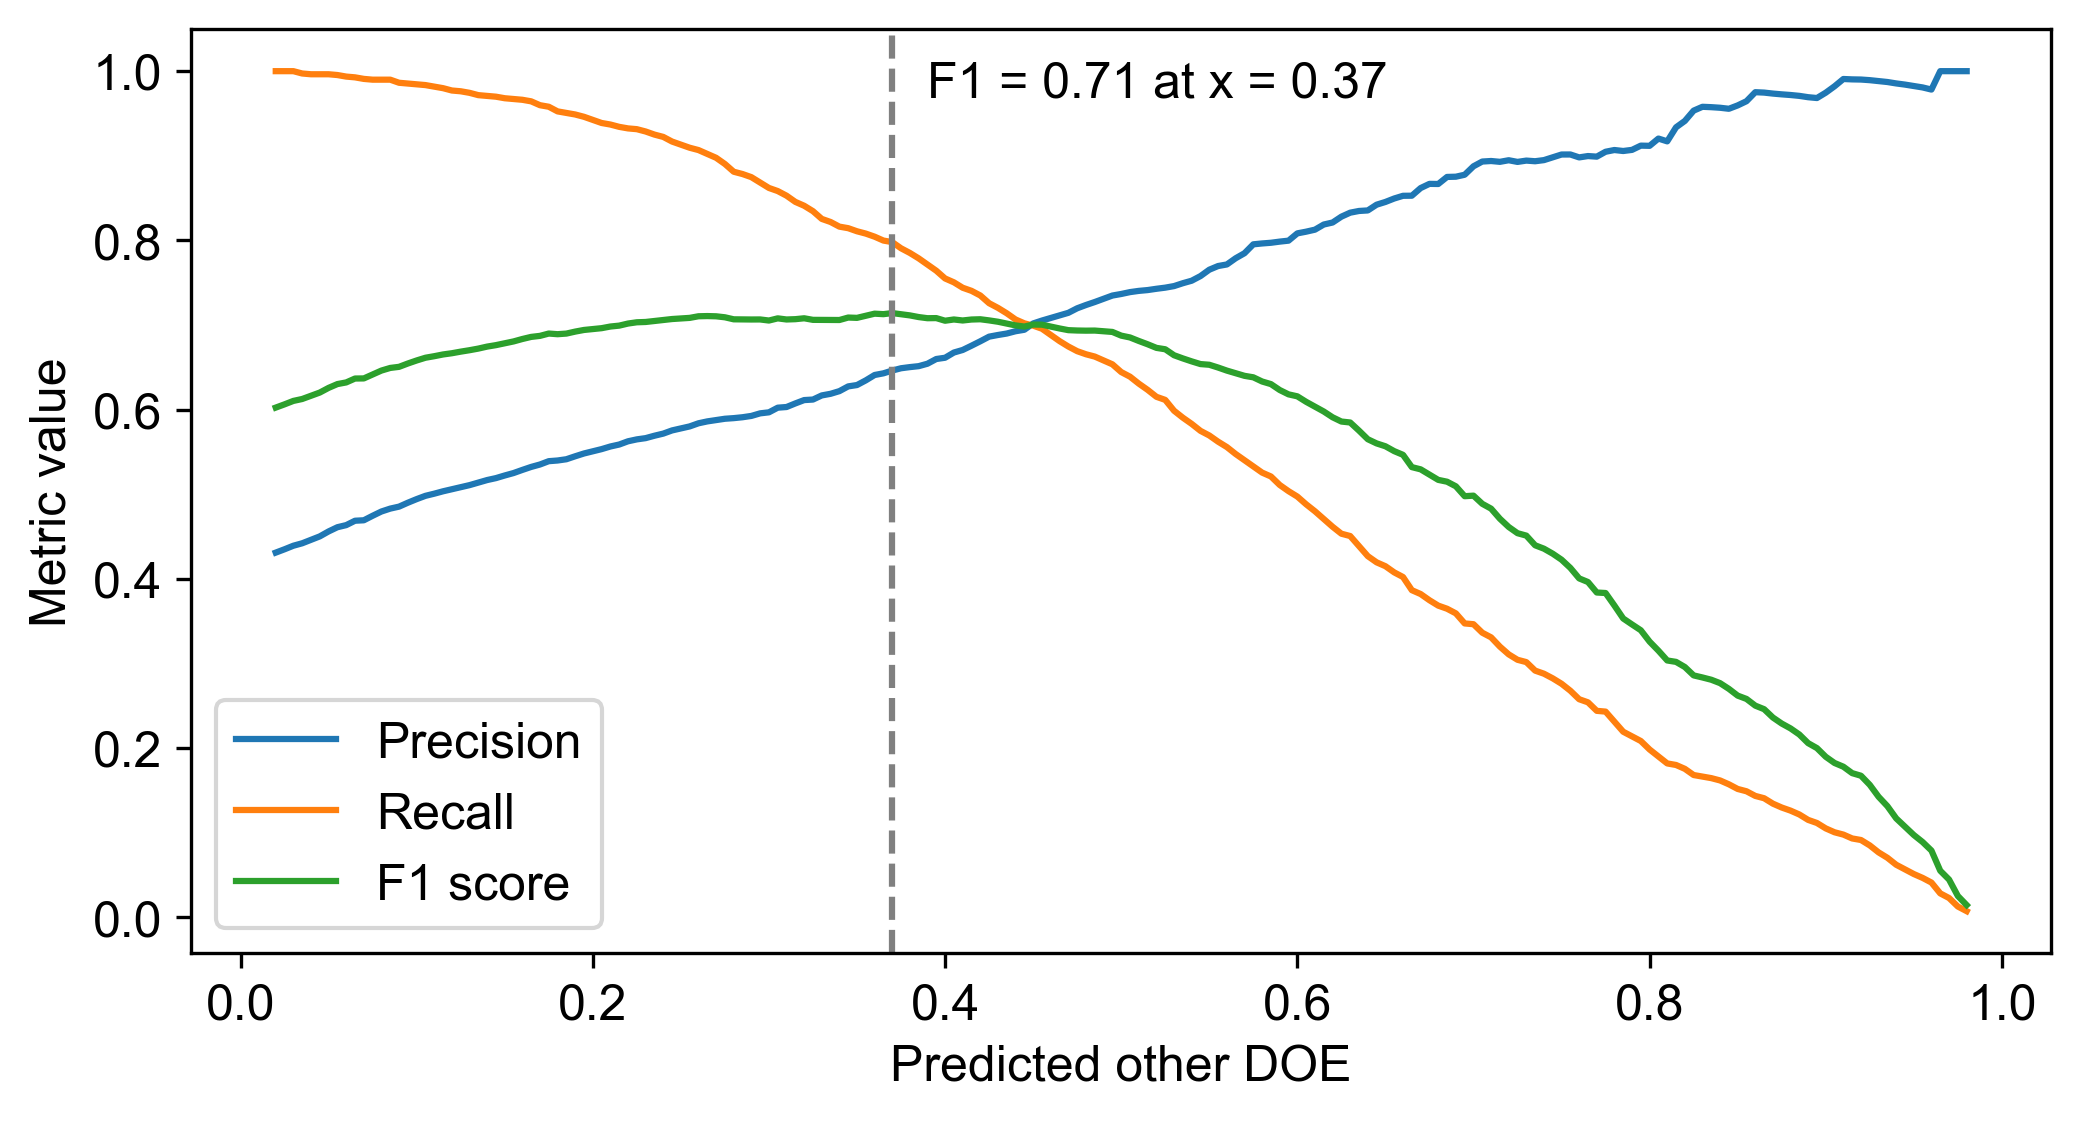

In [13]:
plt.figure(figsize=(8,4), dpi=300)
thresholds=np.arange(0,1.0001,0.005)
rows=[]
for t in thresholds:
    b=(pred['pred_other']>=t).astype(int)
    if b.sum()>=5 and (len(b)-b.sum())>=5:
        p=precision_score(pred['other'],b,zero_division=0)
        r=recall_score(pred['other'],b,zero_division=0)
        f=f1_score(pred['other'],b,zero_division=0)
        rows.extend([[t,'Precision',p],[t,'Recall',r],[t,'F1 score',f]])
df=pd.DataFrame(rows,columns=['threshold','metric','value'])
best_f1=df[df['metric']=='F1 score']
bt=best_f1.loc[best_f1['value'].idxmax(),'threshold'] if not best_f1.empty else None
sns.lineplot(x='threshold',y='value',hue='metric',data=df)
if bt is not None:
    plt.axvline(x=bt,linestyle='--',color='gray')
    max_f1=best_f1['value'].max()
    plt.annotate(f'F1 = {max_f1:.2f} at x = {bt:.2f}',xy=(bt+0.02,0.97))
plt.legend(title='')
plt.xlabel('Predicted other DOE')
plt.ylabel('Metric value')
plt.show()


### Calculating metrics

In [23]:
data = pd.read_pickle('./OT/Final/gene_direction.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos']]

model_names = ['all','gene_embed','prot_embed','all_embed','genetics','drugnomeai']
metrics = pd.DataFrame()

def bootstrap_all_metrics(y_true,y_score,n_boot):
    np.random.seed(42)
    out={f'auroc_{c}':[] for c in ['neg','other','pos']}
    out.update({f'auprc_{c}':[] for c in ['neg','other','pos']})
    out.update({f'brier_{c}':[] for c in ['neg','other','pos']})
    for x in ['auroc_micro','auroc_macro','auprc_micro','auprc_macro','hamming','brier_micro','brier_macro']:
        out[x]=[]
    for _ in range(n_boot):
        idx=np.random.randint(0,len(y_true),len(y_true))
        yt,ys=y_true[idx],y_score[idx]
        for i,c in enumerate(['neg','other','pos']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:,i],ys[:,i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:,i],ys[:,i]))
            out[f'brier_{c}'].append(np.mean((ys[:,i] - yt[:,i])**2))
        out['auroc_micro'].append(roc_auc_score(yt,ys,average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt,ys,average='macro'))
        out['auprc_micro'].append(average_precision_score(yt,ys,average='micro'))
        out['auprc_macro'].append(average_precision_score(yt,ys,average='macro'))
        out['hamming'].append(hamming_loss(yt,(ys>=0.5).astype(int)))
        out['brier_micro'].append(np.mean((ys - yt)**2))
        out['brier_macro'].append(np.mean([(ys[:,i] - yt[:,i])**2 for i in range(yt.shape[1])]))
    return {k:(np.mean(v),np.percentile(v,2.5),np.percentile(v,97.5)) for k,v in out.items()}

for i in model_names:
    if i == 'drugnomeai':
        res=pd.read_csv('./Other/drugnomeai.csv').rename({'Gene Name':'ID'},axis=1).merge(data)
        res['pred_neg']=res['Tclin & Tchem'].copy()
        res['pred_other']=res['Tclin & Tchem'].copy()
        res['pred_pos']=res['Tclin & Tchem'].copy()
    else:
        res=pd.read_csv(f'./Training/Predictions/doe_{i}_holdout_predictions.csv').merge(data)
    y_true=res[['neg','other','pos']].values
    y_score=res[['pred_neg','pred_other','pred_pos']].values
    boot=bootstrap_all_metrics(y_true,y_score,500)
    new_records=[]
    for k,(m,l,h) in boot.items():
        new_records.append({'model':i,'metric':k,'mean':m,'ci_low':l,'ci_high':h})
    metrics=pd.concat([metrics,pd.DataFrame(new_records)],ignore_index=True)

metrics.to_pickle('./Training/Metrics/doe.pkl')



In [24]:
metrics = pd.read_pickle('./Training/Metrics/doe.pkl')
metrics['model'] = metrics['model'].map({'all':'All features',
                                         'gene_embed':'Gene embeddings',
                                         'prot_embed':'Protein embeddings',
                                         'all_embed':'All embeddings',
                                         'genetics':'Tabular features',
                                         'drugnomeai':'DrugnomeAI'})
metrics['model'] = pd.Categorical(metrics['model'], ['Tabular features','Gene embeddings','Protein embeddings',
                                                     'All embeddings','All features','DrugnomeAI'])

data = pd.read_pickle('./OT/Final/gene_direction.pkl').rename({'gene':'ID'},axis=1)
n_ids = data['ID'].nunique()
n_neg = int(data['neg'].sum())
n_other = int(data['other'].sum())
n_pos = int(data['pos'].sum())


In [27]:
table = metrics.copy()
table.loc[table['metric'].str.contains('neg'), 'outcome'] = 'Inhibitor'
table.loc[table['metric'].str.contains('other'), 'outcome'] = 'Other'
table.loc[table['metric'].str.contains('pos'), 'outcome'] = 'Activator'
table.loc[table['metric'].str.contains('macro'), 'outcome'] = 'Macro-average'
table.loc[table['metric'].str.contains('micro'), 'outcome'] = 'Micro-average'
table.loc[table['metric'].str.contains('auroc'), 'metric'] = 'AUROC'
table.loc[table['metric'].str.contains('auprc'), 'metric'] = 'AUPRC'
table.loc[table['metric'].str.contains('brier'), 'metric'] = 'Brier score'
table = table.dropna()
table['outcome'] = pd.Categorical(table['outcome'], ['Activator','Inhibitor','Other','Macro-average','Micro-average'])

table['value'] = table['mean'].round(3).astype(str) + ' (' + table['ci_low'].round(3).astype(str) + '-' + table['ci_high'].round(3).astype(str) + ')'
table = pd.pivot_table(table, index=['outcome','model'], columns='metric', values='value', aggfunc='first').reset_index()
table = table[['outcome','model','AUROC','AUPRC','Brier score']]

table


metric        outcome               model                AUROC  \
0           Activator    Tabular features  0.802 (0.781-0.821)   
1           Activator     Gene embeddings  0.853 (0.833-0.873)   
2           Activator  Protein embeddings    0.83 (0.81-0.851)   
3           Activator      All embeddings  0.863 (0.844-0.882)   
4           Activator        All features  0.874 (0.857-0.891)   
5           Activator          DrugnomeAI   0.69 (0.666-0.714)   
6           Inhibitor    Tabular features    0.76 (0.739-0.78)   
7           Inhibitor     Gene embeddings  0.833 (0.816-0.851)   
8           Inhibitor  Protein embeddings   0.798 (0.78-0.818)   
9           Inhibitor      All embeddings  0.845 (0.829-0.862)   
10          Inhibitor        All features  0.848 (0.831-0.865)   
11          Inhibitor          DrugnomeAI  0.749 (0.727-0.771)   
12              Other    Tabular features  0.726 (0.708-0.746)   
13              Other     Gene embeddings  0.805 (0.789-0.821)   
14              Other  Protein embeddings  0.792 (0.776-0.809)   
15              Other      All embeddings  0.815 (0.801-0.832)   
16              Other        All features   0.825 (0.809-0.84)   
17              Other          DrugnomeAI  0.382 (0.359-0.405)   
18      Macro-average    Tabular features  0.763 (0.751-0.775)   
19      Macro-average     Gene embeddings   0.83 (0.818-0.842)   
20      Macro-average  Protein embeddings   0.807 (0.795-0.82)   
21      Macro-average      All embeddings   0.841 (0.83-0.853)   
22      Macro-average        All features   0.849 (0.839-0.86)   
23      Macro-average          DrugnomeAI  0.607 (0.597-0.619)   
24      Micro-average    Tabular features  0.837 (0.828-0.846)   
25      Micro-average     Gene embeddings  0.877 (0.869-0.886)   
26      Micro-average  Protein embeddings  0.867 (0.858-0.877)   
27      Micro-average      All embeddings  0.885 (0.877-0.893)   
28      Micro-average        All features  0.889 (0.881-0.897)   
29      Micro-average          DrugnomeAI  0.567 (0.558-0.578)   

metric                AUPRC          Brier score  
0       0.597 (0.554-0.645)  0.133 (0.125-0.142)  
1       0.719 (0.681-0.754)  0.112 (0.103-0.121)  
2        0.704 (0.67-0.737)  0.115 (0.107-0.124)  
3       0.745 (0.711-0.778)  0.106 (0.098-0.115)  
4        0.75 (0.717-0.784)  0.105 (0.096-0.113)  
5       0.376 (0.342-0.412)  0.453 (0.436-0.468)  
6       0.903 (0.889-0.918)  0.153 (0.146-0.161)  
7       0.937 (0.926-0.947)  0.136 (0.128-0.144)  
8       0.919 (0.906-0.932)  0.144 (0.136-0.153)  
9       0.943 (0.934-0.953)  0.133 (0.124-0.141)  
10      0.943 (0.933-0.953)  0.131 (0.123-0.139)  
11      0.889 (0.872-0.904)   0.197 (0.185-0.21)  
12      0.676 (0.649-0.704)    0.206 (0.2-0.212)  
13      0.765 (0.736-0.789)   0.177 (0.17-0.185)  
14      0.753 (0.729-0.778)  0.182 (0.175-0.188)  
15      0.782 (0.757-0.805)  0.172 (0.164-0.179)  
16       0.788 (0.763-0.81)  0.168 (0.161-0.176)  
17      0.371 (0.348-0.399)  0.535 (0.518-0.551)  
18      0.725 (0.708-0.743)   0.164 (0.16-0.169)  
19      0.807 (0.791-0.822)  0.142 (0.137-0.147)  
20      0.792 (0.778-0.807)  0.147 (0.142-0.152)  
21      0.823 (0.808-0.838)  0.137 (0.132-0.142)  
22      0.827 (0.812-0.841)   0.134 (0.129-0.14)  
23       0.546 (0.53-0.564)  0.395 (0.387-0.402)  
24      0.822 (0.811-0.834)   0.164 (0.16-0.169)  
25         0.87 (0.86-0.88)  0.142 (0.137-0.147)  
26      0.856 (0.845-0.867)  0.147 (0.142-0.152)  
27       0.88 (0.871-0.889)  0.137 (0.132-0.142)  
28      0.882 (0.872-0.891)   0.134 (0.129-0.14)  
29       0.531 (0.517-0.55)  0.395 (0.387-0.402)

Text(0, 0.5, 'AUROC')

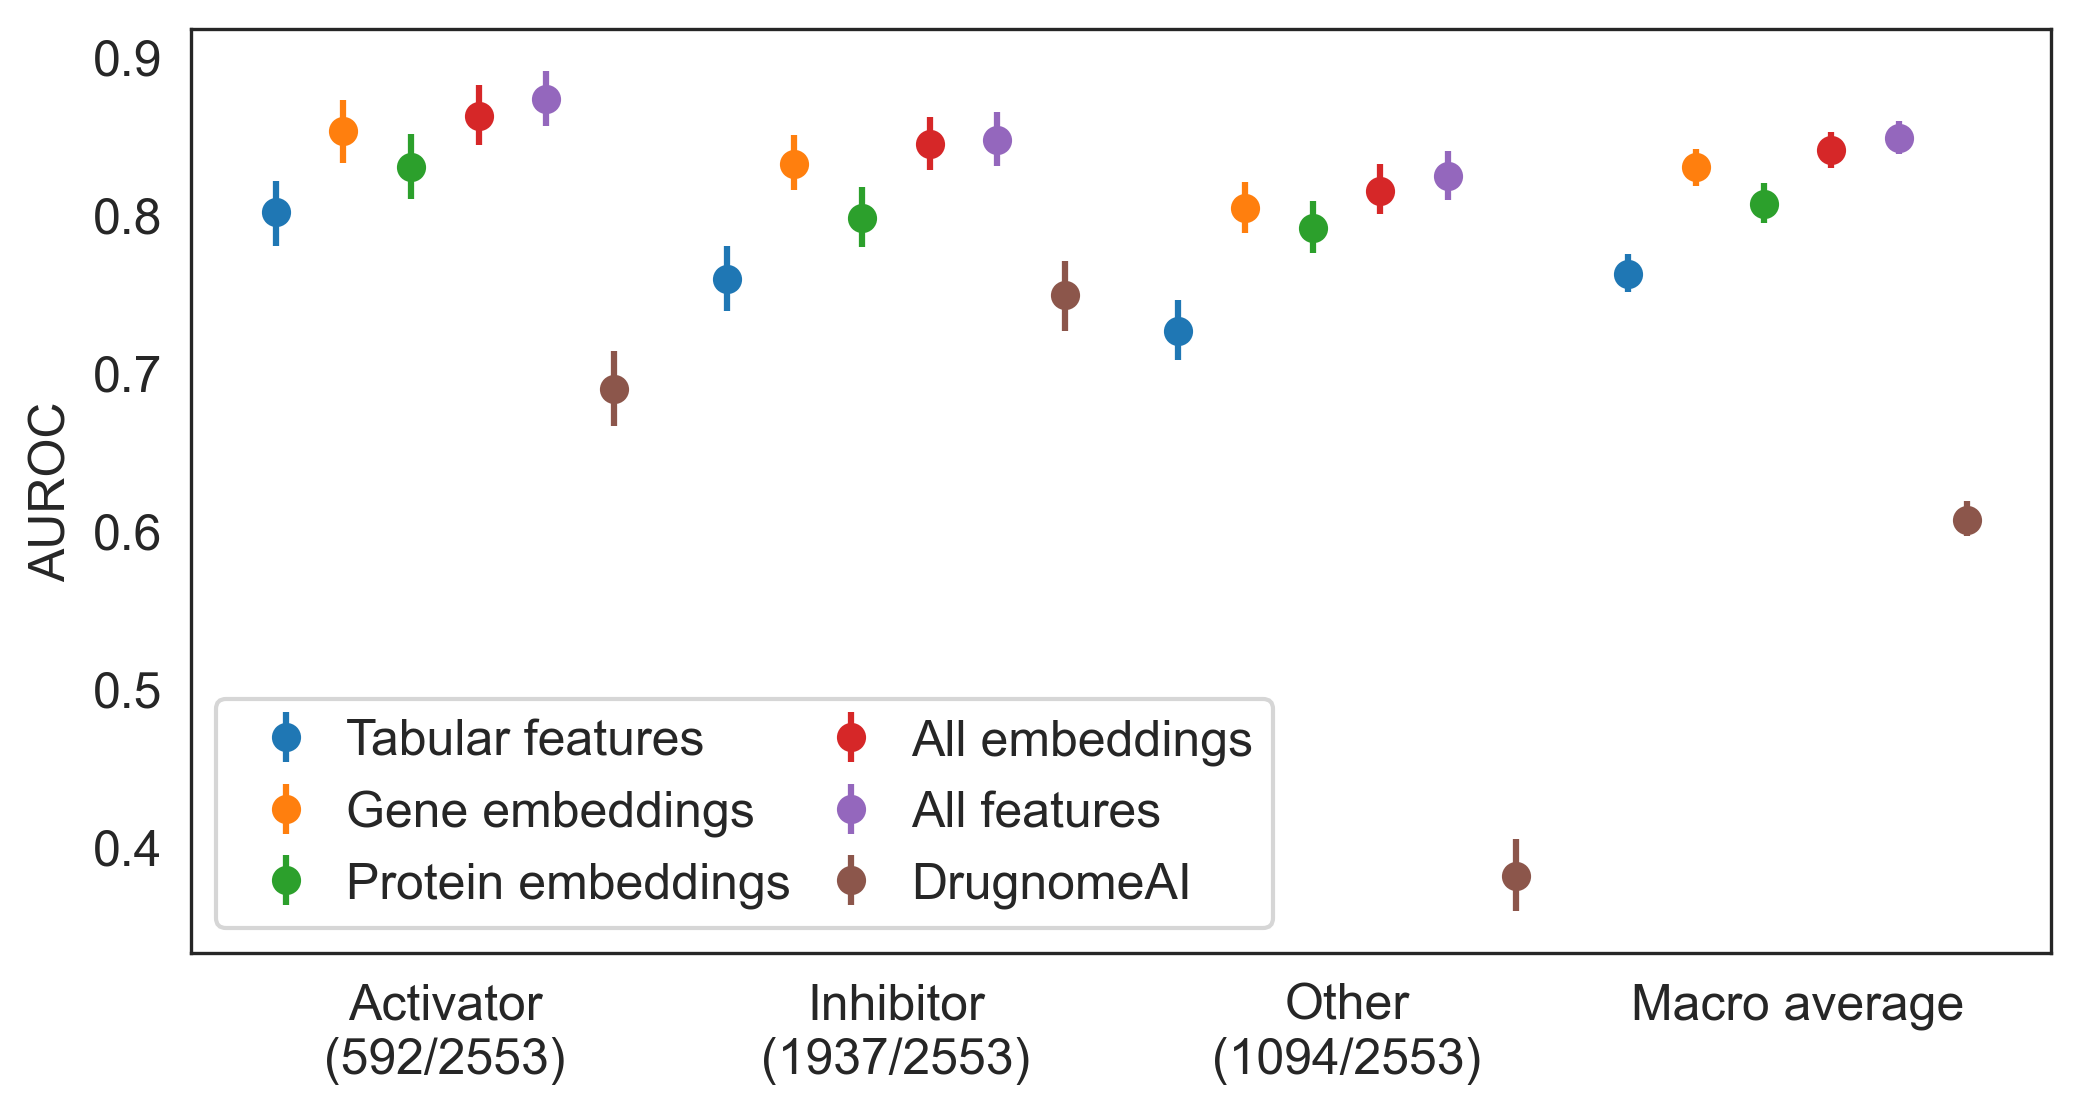

In [167]:
res = metrics.copy()
res = res.loc[~res['metric'].str.contains('micro')]
res = res.loc[res['metric'].str.contains('auroc')]
res['metric'] = res['metric'].map({'auroc_neg':f'Inhibitor\n({n_neg}/{n_ids})',
                                   'auroc_other':f'Other\n({n_other}/{n_ids})',
                                   'auroc_pos':f'Activator\n({n_pos}/{n_ids})',
                                   'auroc_macro':'Macro average'})
res['metric'] = pd.Categorical(res['metric'], [f'Activator\n({n_pos}/{n_ids})',
                                               f'Inhibitor\n({n_neg}/{n_ids})',
                                               f'Other\n({n_other}/{n_ids})',
                                               'Macro average'])
res = res.sort_values(['model','metric'])

sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['model'].unique()
offset = 0.15  # Offset for dodging
x_positions = range(len(res['metric'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['model'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['metric'].unique())))
ax.set_xticklabels(res['metric'].unique())
ax.legend(title='', ncols=2, loc='lower left', columnspacing=0.2, handletextpad=0.2)

#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
plt.xlabel('')
plt.ylabel('AUROC')


Text(0, 0.5, 'AUPRC')

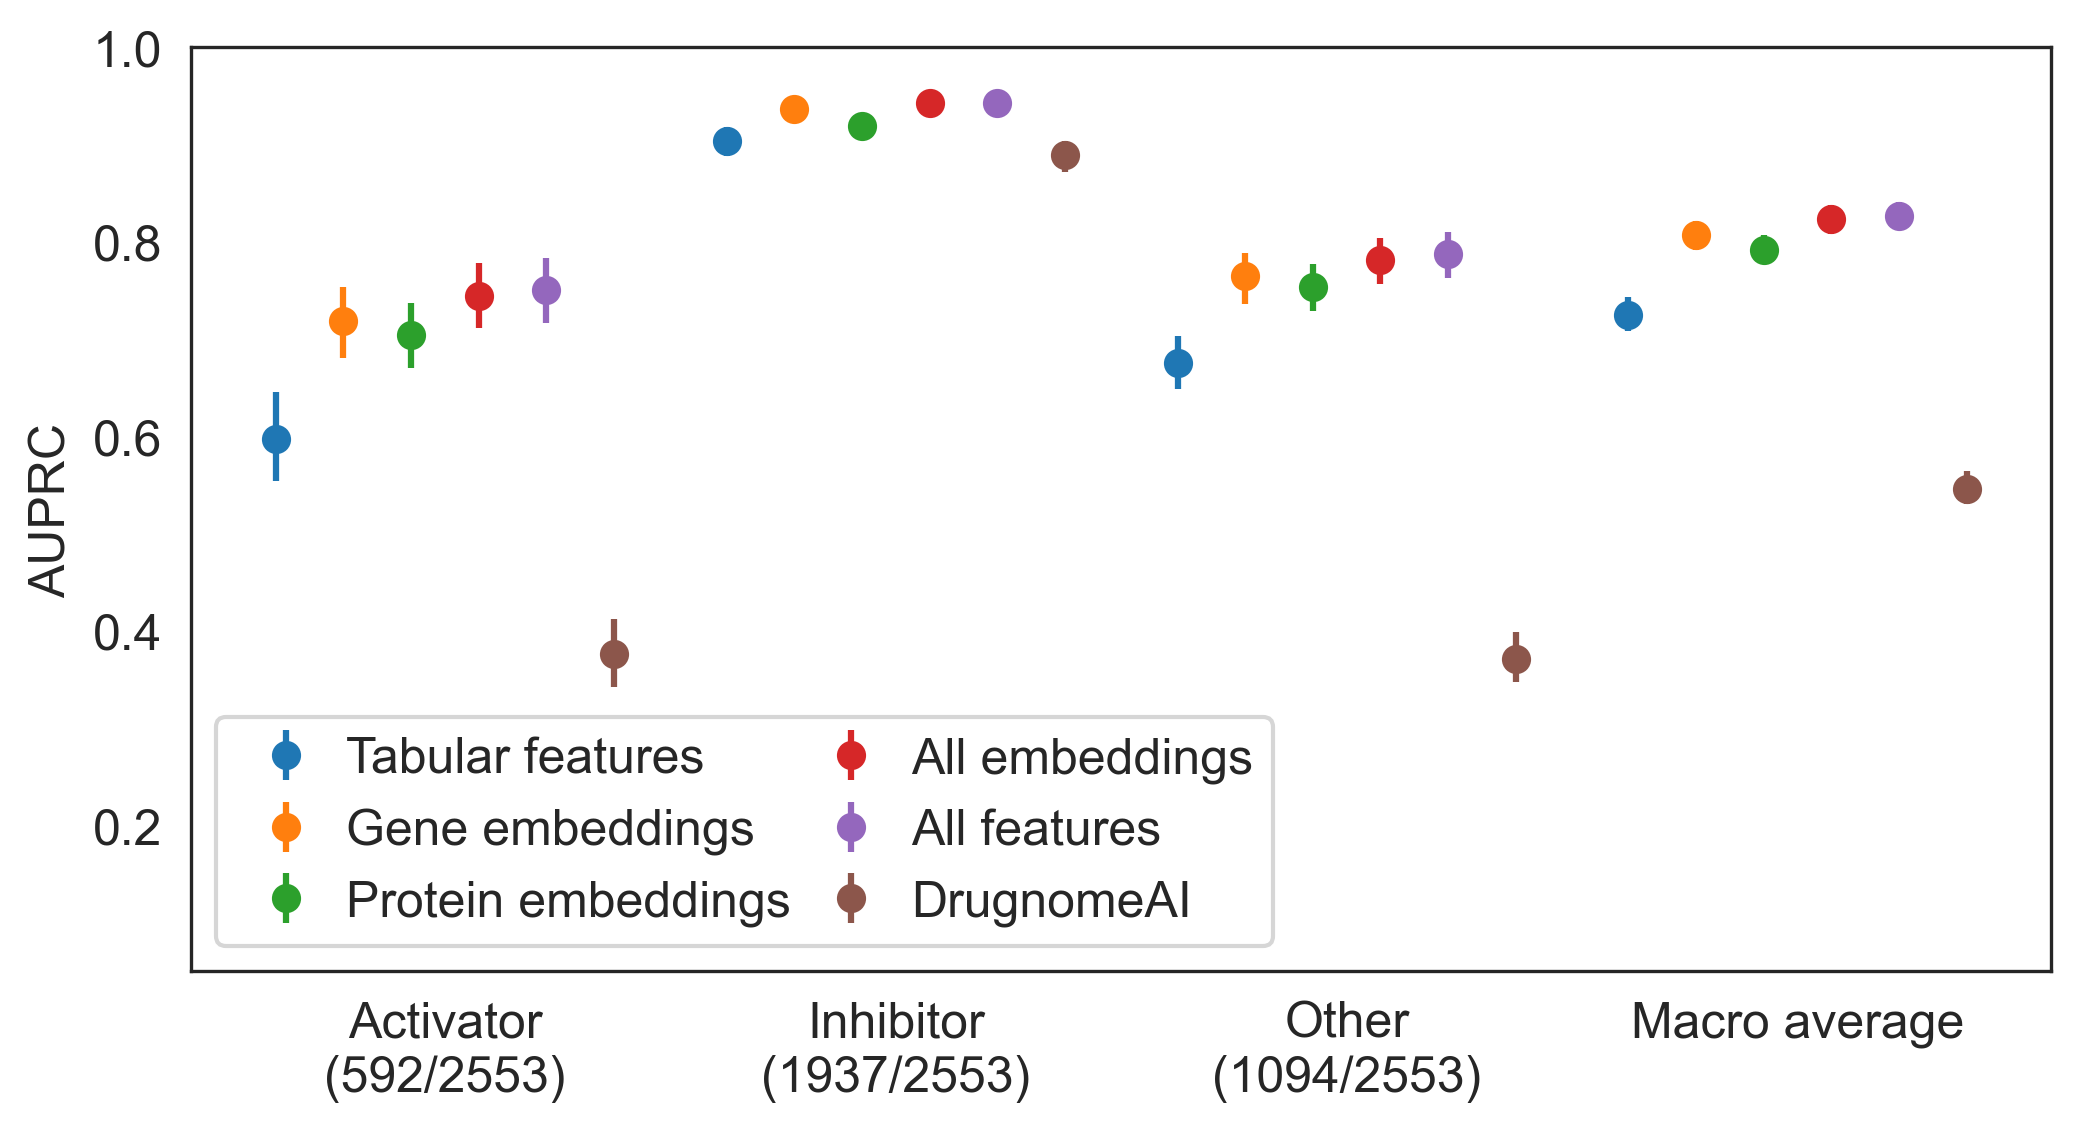

In [168]:
res = metrics.copy()
res = res.loc[~res['metric'].str.contains('micro')]
res = res.loc[res['metric'].str.contains('auprc')]
res['metric'] = res['metric'].map({'auprc_neg':f'Inhibitor\n({n_neg}/{n_ids})',
                                   'auprc_other':f'Other\n({n_other}/{n_ids})',
                                   'auprc_pos':f'Activator\n({n_pos}/{n_ids})',
                                   'auprc_macro':'Macro average'})
res['metric'] = pd.Categorical(res['metric'], [f'Activator\n({n_pos}/{n_ids})',
                                               f'Inhibitor\n({n_neg}/{n_ids})',
                                               f'Other\n({n_other}/{n_ids})',
                                               'Macro average'])
res = res.sort_values(['model','metric'])

sns.set_style('white')

fig, ax = plt.subplots(figsize=(8,4), dpi=300)
mechanisms = res['model'].unique()
offset = 0.15  # Offset for dodging
x_positions = range(len(res['metric'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['model'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['metric'].unique())))
ax.set_xticklabels(res['metric'].unique())
ax.legend(title='', ncols=2, loc='lower left', columnspacing=0.2, handletextpad=0.2)

plt.ylim([0.05,1])
plt.xlabel('')
plt.ylabel('AUPRC')


Text(0, 0.5, 'True proportion')

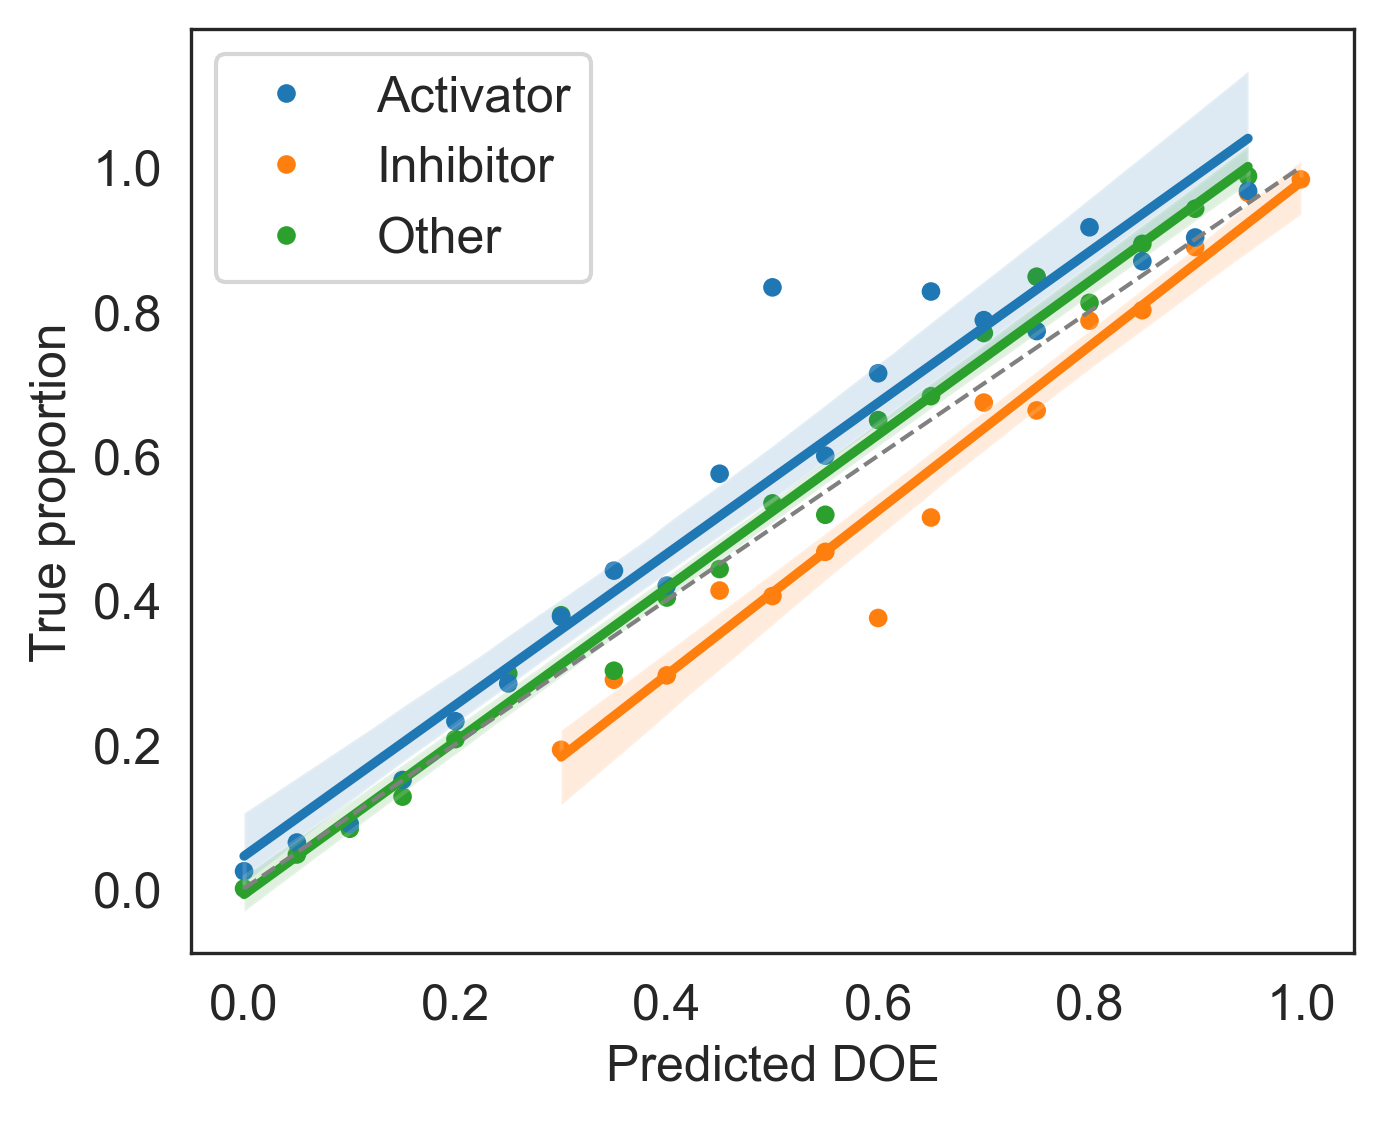

In [5]:
data = pd.read_pickle('./OT/Final/gene_direction.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos']]
data=pd.read_csv(f'./Training/Predictions/doe_all_holdout_predictions.csv').merge(data)

melt_data = pd.DataFrame({
    "pred": data["pred_neg"].apply(round_to_005).tolist() + 
            data["pred_pos"].apply(round_to_005).tolist() + 
            data["pred_other"].apply(round_to_005).tolist(),
    "true": data["neg"].tolist() + 
            data["pos"].tolist() + 
            data["other"].tolist(),
    "hue": ["neg"] * len(data) + ["pos"] * len(data) + ["other"] * len(data)
})

calibration_data = melt_data.groupby(["pred", "hue"]).agg(
    proportion_true=("true", "mean"),
    count=("true", "size")).reset_index()
calibration_data = calibration_data[calibration_data["count"] >= 20]
calibration_data['hue'] = calibration_data['hue'].map({'other':'Other','pos':'Activator','neg':'Inhibitor'})
calibration_data['hue'] = pd.Categorical(calibration_data['hue'], ['Activator','Inhibitor','Other'])

sns.set_style('white')
plt.figure(figsize=(5,4), dpi=300)

sns.scatterplot(data=calibration_data,x='pred',y='proportion_true',hue='hue',edgecolor='none',s=20)
for h,c in zip(['Activator','Inhibitor','Other'],sns.color_palette()[:3]):
    subset=calibration_data[calibration_data['hue']==h]
    sns.regplot(data=subset,x='pred',y='proportion_true',scatter=False,color=c,label=None)
plt.plot([0,1],[0,1],'--',c='gray',lw=1)
plt.legend(title='')
plt.xlabel('Predicted DOE')
plt.ylabel('True proportion')


In [9]:
data = pd.read_pickle('./OT/Final/gene_direction.pkl').rename({'gene':'ID'},axis=1)[['ID','neg','other','pos']]
subsets = pd.read_pickle('./OT/Final/subsets.pkl')

model_names = ['all','drugnomeai']
metrics = pd.DataFrame()

def bootstrap_all_metrics(y_true,y_score,n_boot):
    np.random.seed(42)
    out={f'auroc_{c}':[] for c in ['neg','other','pos']}
    out.update({f'auprc_{c}':[] for c in ['neg','other','pos']})
    for x in ['auroc_micro','auroc_macro','auprc_micro','auprc_macro','hamming']:
        out[x]=[]
    for _ in range(n_boot):
        idx=np.random.randint(0,len(y_true),len(y_true))
        yt,ys=y_true[idx],y_score[idx]
        for i,c in enumerate(['neg','other','pos']):
            out[f'auroc_{c}'].append(roc_auc_score(yt[:,i],ys[:,i]))
            out[f'auprc_{c}'].append(average_precision_score(yt[:,i],ys[:,i]))
        out['auroc_micro'].append(roc_auc_score(yt,ys,average='micro'))
        out['auroc_macro'].append(roc_auc_score(yt,ys,average='macro'))
        out['auprc_micro'].append(average_precision_score(yt,ys,average='micro'))
        out['auprc_macro'].append(average_precision_score(yt,ys,average='macro'))
        out['hamming'].append(hamming_loss(yt,(ys>=0.5).astype(int)))
    return {k:(np.mean(v),np.percentile(v,2.5),np.percentile(v,97.5)) for k,v in out.items()}

for i in model_names:
    for subset in ['all','class_enzyme','class_transporter','class_tf','class_gpcr','class_vgic','constrained','not_constrained','novel']:
        if subset == 'all':
            inc_genes = data['ID'].unique()
        else:
            inc_genes = subsets.loc[subsets[subset] == 1]['gene'].to_list()
        for i in model_names:
            try:
                if i == 'drugnomeai':
                    res=pd.read_csv('./Other/drugnomeai.csv').rename({'Gene Name':'ID'},axis=1).merge(data)
                    res['pred_neg']=res['Tclin & Tchem'].copy()
                    res['pred_other']=res['Tclin & Tchem'].copy()
                    res['pred_pos']=res['Tclin & Tchem'].copy()
                else:
                    res=pd.read_csv(f'./Training/Predictions/doe_{i}_holdout_predictions.csv').merge(data)
                res = res.loc[res['ID'].isin(inc_genes)]
                y_true=res[['neg','other','pos']].values
                y_score=res[['pred_neg','pred_other','pred_pos']].values
                boot=bootstrap_all_metrics(y_true,y_score,500)
                new_records=[]
                for k,(m,l,h) in boot.items():
                    new_records.append({'subset':subset,'model':i,'metric':k,'mean':m,'ci_low':l,'ci_high':h})
                metrics=pd.concat([metrics,pd.DataFrame(new_records)],ignore_index=True)
            except:
                continue

metrics.to_pickle('./Training/Metrics/doe_subset.pkl')


In [111]:
metrics = pd.read_pickle('./Training/Metrics/doe_subset.pkl')
metrics['model'] = metrics['model'].map({'all':'All features',
                                         'drugnomeai':'DrugnomeAI'})
metrics['model'] = pd.Categorical(metrics['model'], ['All features','DrugnomeAI'])
metrics['subset'] = metrics['subset'].map({'all':'All',
                                           'class_enzyme':'Enzyme','class_transporter':'Transporter',
                                           'class_tf':'TF','class_gpcr':'GPCR',
                                           'class_vgic':'VGIC','constrained':'LOEUF < 0.6',
                                           'not_constrained':'LOEUF ≥ 0.6',
                                           'novel':'Novel'})
metrics['subset'] = pd.Categorical(metrics['subset'], ['All','Enzyme','GPCR','TF','Transporter','VGIC','LOEUF < 0.6','LOEUF ≥ 0.6','Novel'])

data = pd.read_pickle('./OT/Final/gene_direction.pkl').rename({'gene':'ID'},axis=1)
n_ids = data['ID'].nunique()


Text(0, 0.5, 'AUROC')

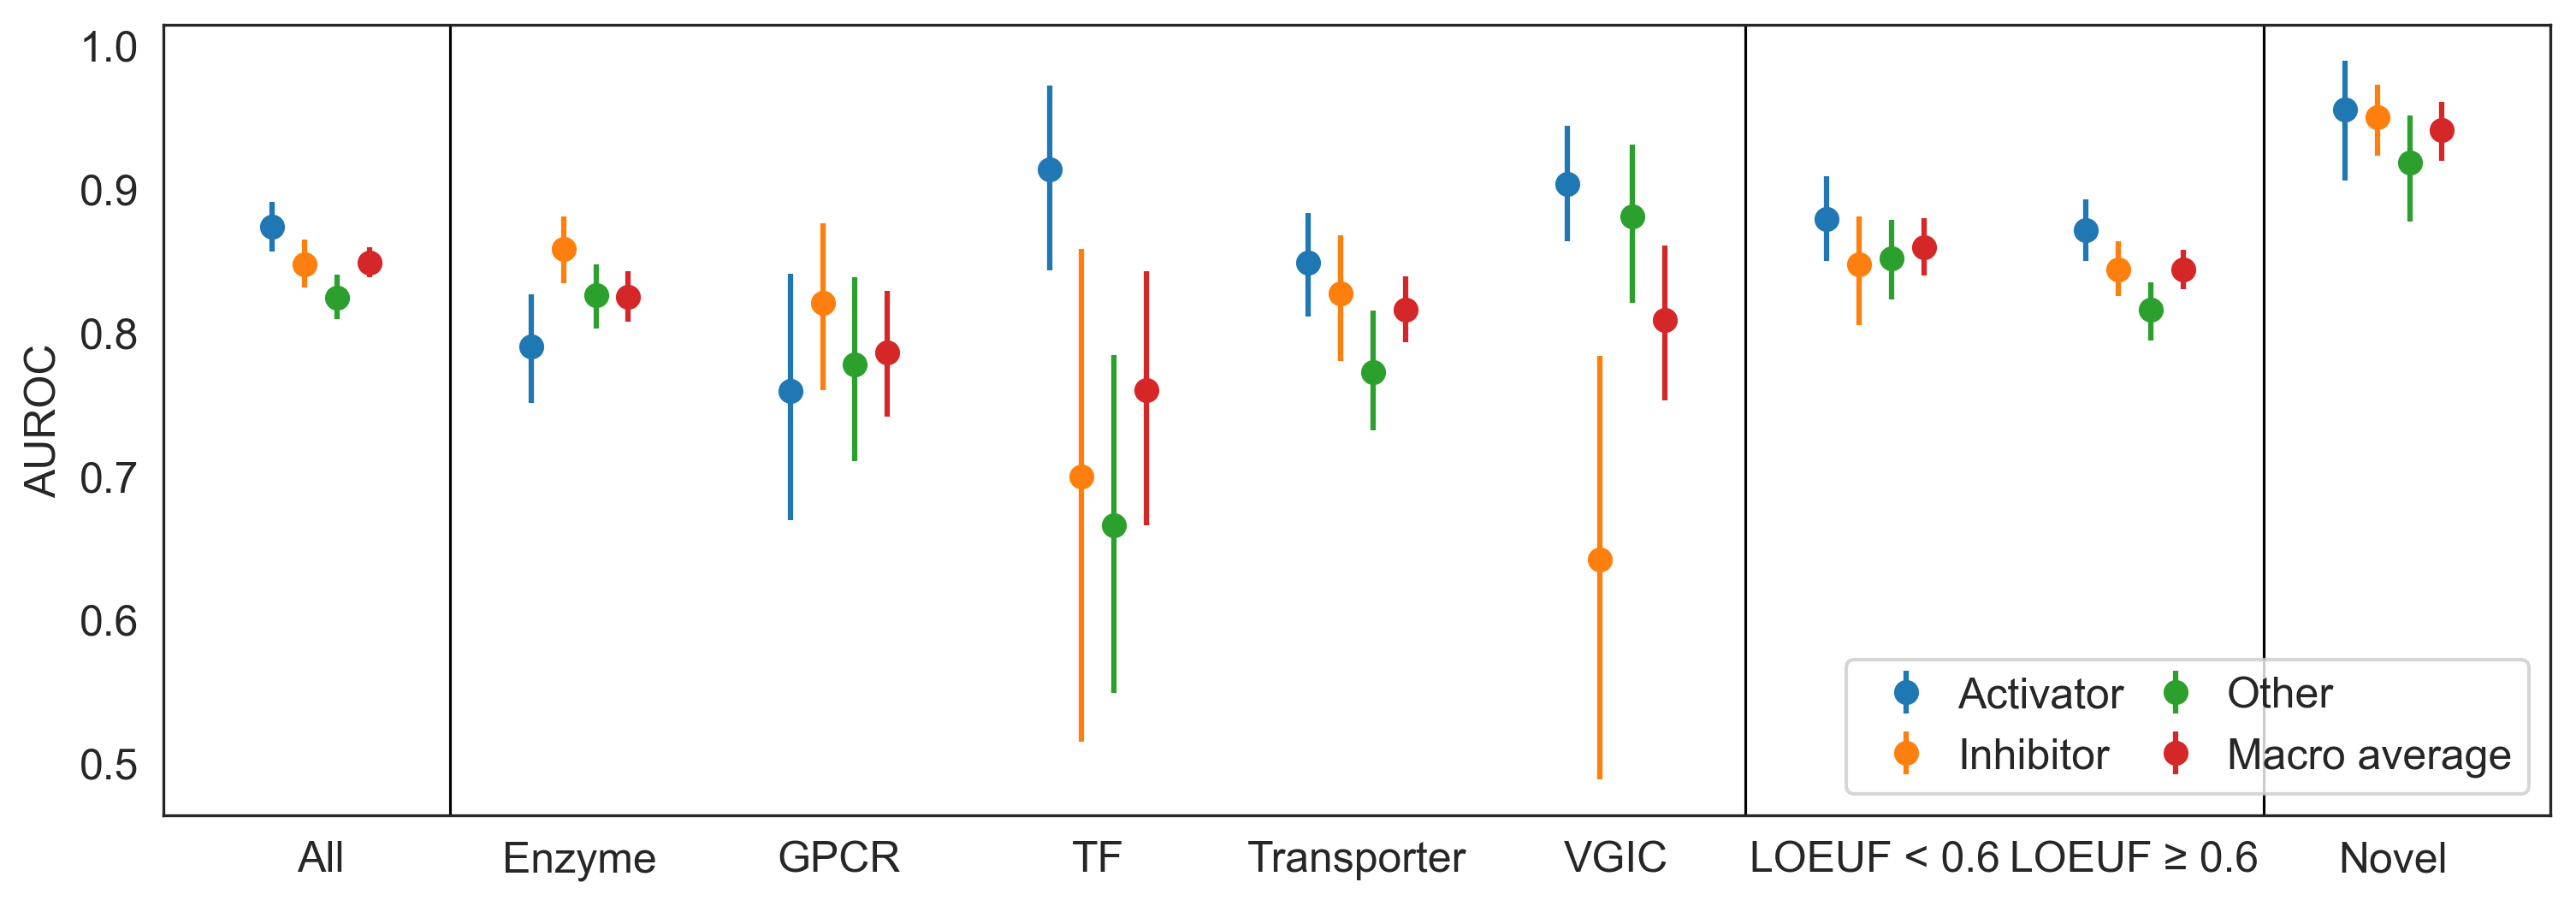

In [113]:
res = metrics.copy().drop_duplicates()
res = res.loc[res['model'] == 'All features']
res = res.loc[res['metric'].str.contains('auroc')]
res['metric'] = res['metric'].map({'auroc_neg':'Inhibitor',
                                   'auroc_other':'Other',
                                   'auroc_pos':'Activator',
                                   'auroc_macro':'Macro average'})
res['metric'] = pd.Categorical(res['metric'], ['Activator','Inhibitor','Other','Macro average'])
res = res.sort_values(['model','subset','metric']).dropna(subset='metric')

sns.set_style('white')

fig, ax = plt.subplots(figsize=(12,4), dpi=300)
mechanisms = res['metric'].unique()
offset = 0.125  # Offset for dodging
x_positions = range(len(res['subset'].unique()))  # Base x positions for each column

for i, mech in enumerate(mechanisms):
    subset = res[res['metric'] == mech]
    mech_positions = [x + (i - len(mechanisms) / 2 + 0.5) * offset for x in x_positions]
    ax.errorbar(mech_positions, subset['mean'], 
                yerr=[subset['mean'] - subset['ci_low'], subset['ci_high'] - subset['mean']], 
                fmt='o', label=mech)

ax.set_xticks(range(len(res['subset'].unique())))
ax.set_xticklabels(res['subset'].unique())
ax.legend(title='', ncols=2, loc='lower right', columnspacing=0.2, handletextpad=0.2)

#plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1)
plt.axvline(x=0.5, color='black', linewidth=0.75)
plt.axvline(x=5.5, color='black', linewidth=0.75)
plt.axvline(x=7.5, color='black', linewidth=0.75)

#plt.ylim([0.875,0.975])
plt.xlabel('')
plt.ylabel('AUROC')
